<big><h2 align="center">Сustomer preferences when purchasing air tickets from Holiday Indus airlines.</h2></big>

<big><font color="grey"><b>Aksana Lefter</b></font></big>

Any customer, when searching for air tickets, is guided by a set of preferences, based on which he or she subsequently buys a ticket from one or another airline. Based on the dataset from Holiday Indus containing information about the customer's purchases and non-purchases, we will analyze which preferences influence the purchase of tickets and create a model that, based on these preferences, can predict whether the customer will buy a ticket.

## Data analysis

In [1]:
# Library installation
!pip install pandas -q
!pip install numpy -q
!pip install matplotlib -q
!pip install seaborn -q
!pip install scikit-learn -q
!pip install scipy -q
!pip install xgboost -q
!pip install catboost -q
!pip install gdown -q

In [2]:
# Library import
import gdown
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import statsmodels.api as sm  
from statsmodels.formula.api import ols  
import scipy.stats as stats 
from IPython.display import display, HTML

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from imblearn.combine import SMOTEENN
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as imPipeline
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load data first 7 lines
try:
    data = pd.read_csv("Passanger_booking_data.csv")
    print("uploaded locally")
except:
    file_id = '1PIArux28LgAU6O7lKXq58pDIDcnj7lU_'
    url = f'https://drive.google.com/uc?id={file_id}'
    output = 'indus_airlines_name.csv'
    gdown.download(url, output, quiet=False)
    data = pd.read_csv(output)
    print("data download")
data.head(7)

uploaded locally


,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,1,Internet,RoundTrip,21,12,6,Tue,AKLHGH,Australia,0,0,0,7.21,1
1,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
2,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
3,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
4,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
5,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0
6,1,Internet,RoundTrip,3,48,20,Thu,AKLDEL,New Zealand,1,0,1,5.52,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50002 entries, 0 to 50001
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50002 non-null  int64  
 1   sales_channel          50002 non-null  object 
 2   trip_type              50002 non-null  object 
 3   purchase_lead          50002 non-null  int64  
 4   length_of_stay         50002 non-null  int64  
 5   flight_hour            50002 non-null  int64  
 6   flight_day             50002 non-null  object 
 7   route                  50002 non-null  object 
 8   booking_origin         50002 non-null  object 
 9   wants_extra_baggage    50002 non-null  int64  
 10  wants_preferred_seat   50002 non-null  int64  
 11  wants_in_flight_meals  50002 non-null  int64  
 12  flight_duration        50002 non-null  float64
 13  booking_complete       50002 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

So, we see that dataset contains 50002 records with the following attributes:

<strong>num_passengers</strong> - the number of passengers associated with each booking

<strong>sales_channel</strong> - how customer reached to our website

<strong>trip_type</strong> - specifies whether the booking is for a one-way or round trip

<strong>purchase_lead</strong> - the duration between the booking date and the date of travel

<strong>length_of_stay</strong> - the duration of the holiday stay

<strong>flight_hour</strong> - specifies the hour of the flight

<strong>flight_day</strong> - indicates the day of the week for the flight

<strong>route</strong> - specifies the flight route taken by the customer

<strong>booking_origin</strong> - describes the source of the booking i.e. country

<strong>wants_extra_baggage</strong> - indicates whether the customer expressed a desire for extra baggage allowance

<strong>wants_preferred_seat</strong> - specifications

<strong>wants_in_flight_meals</strong> - specifies if the customer expressed a desire for a meal during the flight

<strong>flight_duration</strong> - duration of flight

<strong>booking_complete</strong> - indicates whether the customer successfully booked a holiday or not

Let's check if there are duplicates in the dataset.

In [5]:
print(f'There are {data.duplicated().sum()} duplicates in our dataframe.')

There are 719 duplicates in our dataframe.


Delete duplicates.

In [6]:
data = data.drop_duplicates() 

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49283 entries, 0 to 50001
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         49283 non-null  int64  
 1   sales_channel          49283 non-null  object 
 2   trip_type              49283 non-null  object 
 3   purchase_lead          49283 non-null  int64  
 4   length_of_stay         49283 non-null  int64  
 5   flight_hour            49283 non-null  int64  
 6   flight_day             49283 non-null  object 
 7   route                  49283 non-null  object 
 8   booking_origin         49283 non-null  object 
 9   wants_extra_baggage    49283 non-null  int64  
 10  wants_preferred_seat   49283 non-null  int64  
 11  wants_in_flight_meals  49283 non-null  int64  
 12  flight_duration        49283 non-null  float64
 13  booking_complete       49283 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.6+ 

In [8]:
data.isnull().sum()

num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64

After removing duplicates, 49283 records remain without missing data. So let's start visualizing.

Let's see how many customers in our dataset did and did not buy tickets.

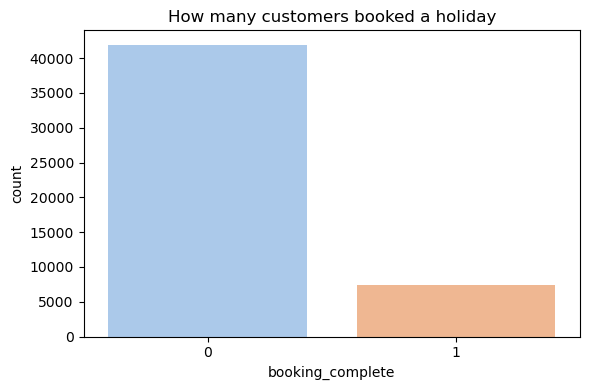

In [9]:
plt.figure(figsize = (6,4))
plt.subplot()
sns.countplot(data = data, x = 'booking_complete', palette="pastel").set(title="How many customers booked a holiday")
plt.tight_layout()
display(HTML("<center>"))
plt.show()
display(HTML("</center>"))

A significant part of the customers in our data are those who have not made a purchase.
Since our data contains two customer categories, those who have made a purchase and those who have not, it is worth considering the data criteria for these two categories.  Let's take a look at how these two customer categories look based on the following attributes: sales channel, trip type, day of the week to fly, and number of passengers.

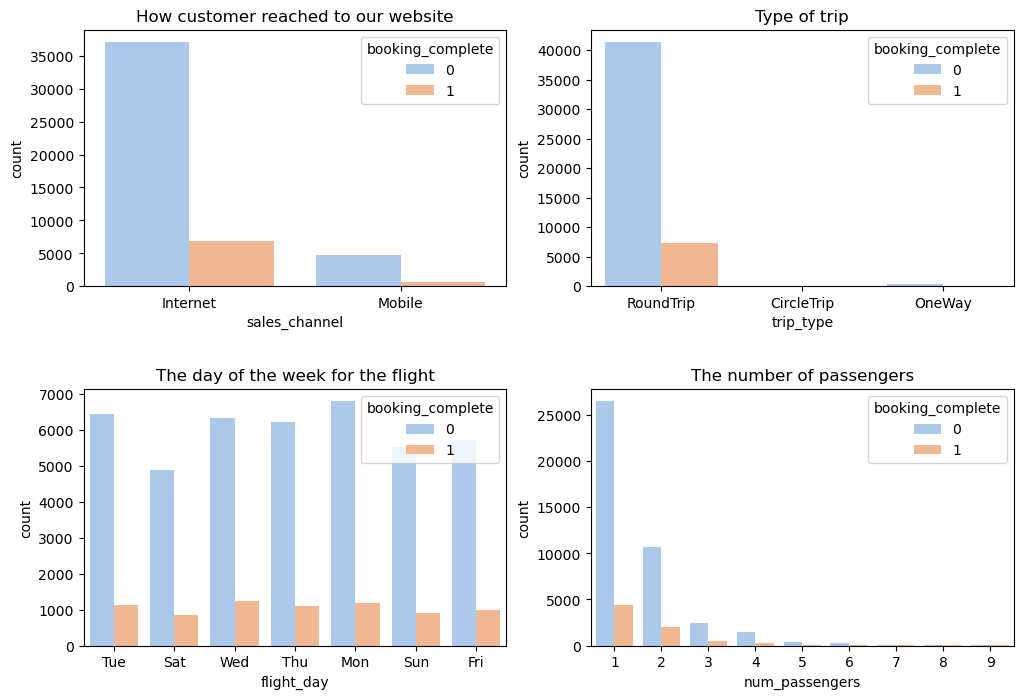

In [10]:
plt.figure(figsize = (12,8))
plt.subplot(221)
sns.countplot(data = data, x = 'sales_channel', palette = "pastel",hue = 'booking_complete')\
.set(title = "How customer reached to our website")
plt.subplot(222)
sns.countplot(data = data, x = 'trip_type', palette = "pastel",hue = 'booking_complete')\
.set(title = "Type of trip")
plt.subplot(223)
sns.countplot(data = data, x = 'flight_day', palette = "pastel",hue = 'booking_complete')\
.set(title = "The day of the week for the flight")
plt.subplot(224)
sns.countplot(data = data, x = 'num_passengers', palette = "pastel",hue = 'booking_complete')\
.set(title = "The number of passengers")

plt.subplots_adjust(wspace = 0.2,hspace = 0.4)

Since more customers in the dataset have not made a purchase than those who did, they will naturally prevail in the categories under consideration due to their number. However, despite this, it can be observed from the charts above that most customers book their holidays online, with round-trip purchases predominating. When it comes to the number of customers, we notice a decrease from 1 and above. This is quite expected, as people rarely book tickets for a large group; mostly, it's for 1-2 individuals or, in the case of families, 3 or more people.

Regarding the days of the week for flights, there doesn't seem to be a significant difference affecting customer choice. Purchases seem to be distributed fairly evenly throughout the week. While a statistical test could be conducted to check for differences between days, the graph doesn't show any sharp spikes on a particular day, leading me to believe it might not be worthwhile to perform the test.

Now let's see which countries customers are booking their holidays from.

In [11]:
# Select only customers who have made a purchase.
booked = data[data['booking_complete']==1]

[Text(0.0, 0, '0'),
 Text(500.0, 0, '500'),
 Text(1000.0, 0, '1000'),
 Text(1500.0, 0, '1500'),
 Text(2000.0, 0, '2000'),
 Text(2500.0, 0, '2500'),
 Text(3000.0, 0, '3000')]

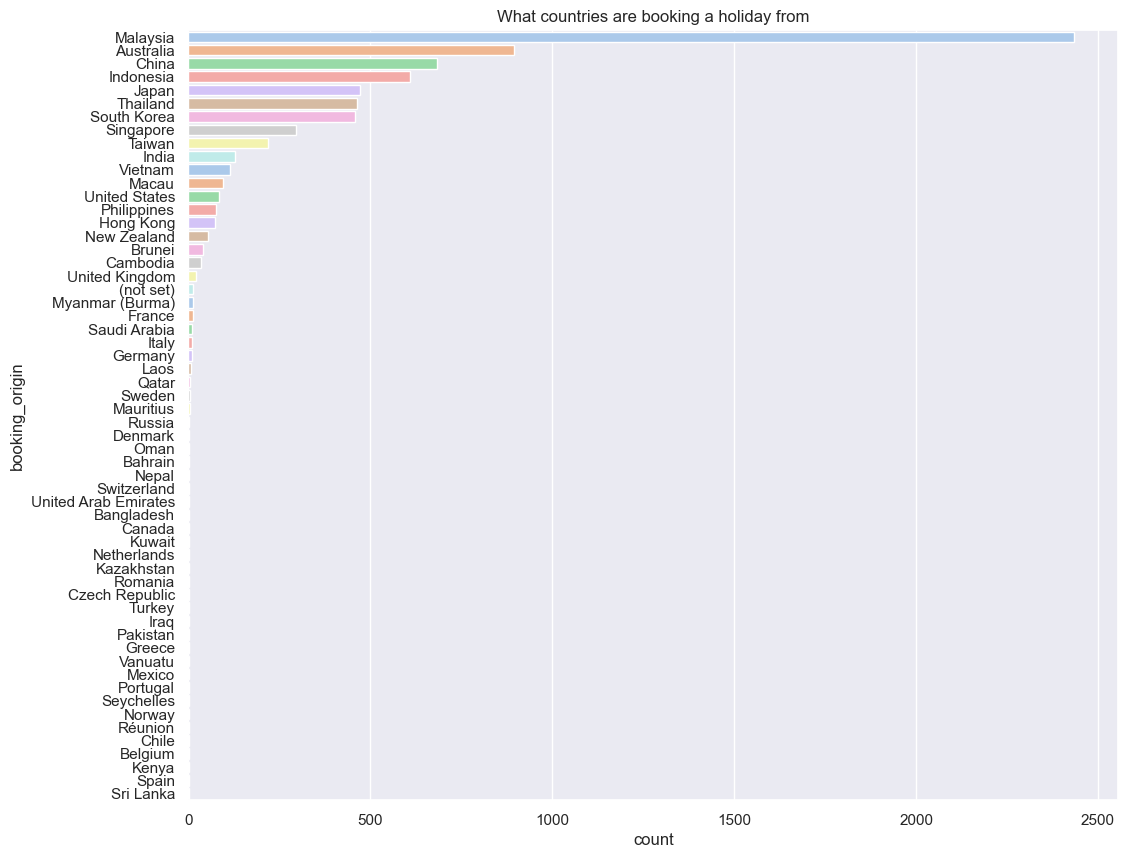

In [13]:
ax = sns.countplot(data = booked, y = 'booking_origin', order=booked["booking_origin"].value_counts().index,\
                   palette = "pastel")
sns.set(rc={'figure.figsize':(12,10)})
ax.set(title = "What countries are booking a holiday from")
ax.set_xticklabels(ax.get_xticklabels(),rotation = 0)

So we see that most customers are buying tickets from Malaysia. Then come Australia, China, and Indonesia. Let's take another look at how many buy and don't buy tickets for optional services.

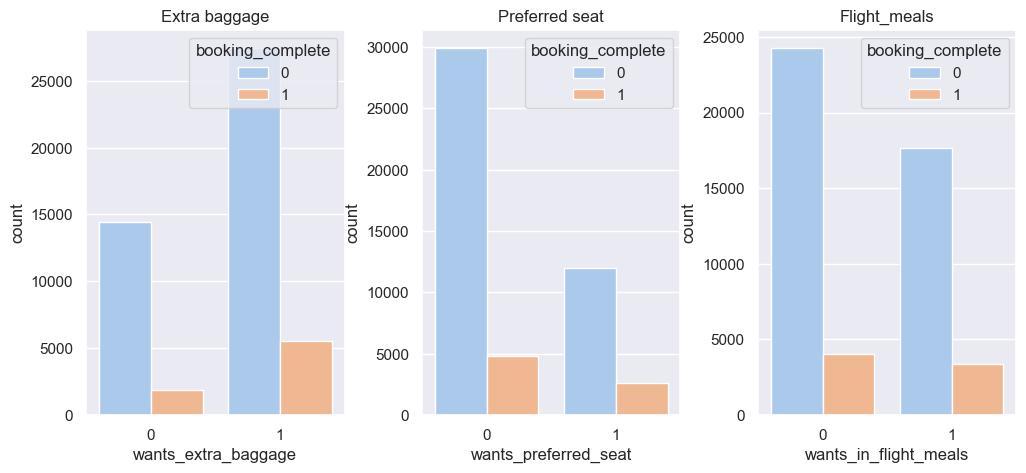

In [14]:
plt.figure(figsize = (12,5))
plt.subplot(131)
sns.countplot(data = data, x = 'wants_extra_baggage', palette = "pastel",hue = 'booking_complete')\
.set(title = "Extra baggage")
plt.subplot(132)
sns.countplot(data = data, x = 'wants_preferred_seat', palette = "pastel",hue = 'booking_complete')\
.set(title = "Preferred seat")
plt.subplot(133)
sns.countplot(data = data, x = 'wants_in_flight_meals', palette = "pastel",hue = 'booking_complete')\
.set(title = "Flight_meals")

plt.subplots_adjust(wspace = 0.3)

From the three charts above, you can see that customers who booked vacations tend to take extra luggage. The other two categories, according to the graph, are almost similar. If there are any differences, they are most likely small, and it is unlikely that this will have a significant impact on the client's decision.

Now, let's use the describe() function and examine our data in terms of descriptive statistics, specifically focusing on the data about the customers who made a purchase.

In [15]:
booked.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,7392.000000,7392.000000,7392.00000,7392.000000,7392.000000,7392.000000,7392.000000,7392.000000,7392.0
mean,1.648404,79.951705,19.66369,9.156656,0.744859,0.350108,0.457657,6.900517,1.0
std,1.062211,89.751879,33.99364,5.235783,0.435970,0.477036,0.498238,1.528078,0.0
min,1.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,4.670000,1.0
25%,1.000000,18.000000,5.00000,5.000000,0.000000,0.000000,0.000000,5.520000,1.0
50%,1.000000,46.000000,6.00000,9.000000,1.000000,0.000000,0.000000,6.620000,1.0
75%,2.000000,106.000000,23.00000,13.000000,1.000000,1.000000,1.000000,8.670000,1.0
max,9.000000,867.000000,778.00000,23.000000,1.000000,1.000000,1.000000,9.500000,1.0


From our data, we can see that customers who have made a purchase have an average flight time of 6.9 hours, a duration between the booking date and the travel date of approximately 80 days, and a vacation duration of approximately 20 days. The attributes purchase_lead and length_of_stay are also worth considering, taking into account the standard deviation, which is 89.75 and 33.99, respectively.

This tells us that each value in the purchase_lead and length_of_stay samples, on average, deviates by 89.75 and 33.99 from the average value.

Main conclusions based on the EDA (Exploratory data analysis refers to the critical process of performing initial investigations on data so as to discover patterns, to spot anomalies, to test hypothesis and to check assumptions with the help of summary statistics and graphical representations.[1]):

- Customers mainly make ticket purchases through the sales channel - Internet
- Customers mostly buy round-trip tickets.
- People from Malaysia buy the most tickets.
- Tickets are predominantly purchased for long flights (average flight time of 6.9 hours).
- On average, customers who bought tickets spend 19 days on their vacations.

## Modeling

Copy the dataset in case we want to go back to the original dataset.

In [16]:
df=data.copy()

Let's divide the dataset into training and test samples.

In [17]:
features = df.drop(['booking_complete'], axis=1)

target = df['booking_complete']

RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(
    features, target, stratify=target, test_size=0.25, random_state=RANDOM_STATE
)

There are unbalanced data in our dataset. We will use Pipeline from imblearn.pipeline to include balanced processing methods, namely SMOTE.

SMOTE is an oversampling technique where the synthetic samples are generated for the minority class. This algorithm helps to overcome the overfitting problem posed by random oversampling. It focuses on the feature space to generate new instances with the help of interpolation between the positive instances that lie together.[2]

In our case, the best SMOTE method would be SMOTE+ENN.

SMOTE does not work well with a large number of columns. So we will use Ordinal Encoder to avoid increasing the number of columns.

Let's try to create several models and choose the one that performs best. We will try Dummy Classifier, Random Forest, Desicion Trees, CatBoost, XGBoost and Naive Bayes.

To evaluate the results of our model, we will use metric ROC AUC score. The Receiver Operator Characteristic (ROC) curve is an evaluation metric for binary classification problems. It is a probability curve that plots the TPR against FPR at various threshold values and essentially separates the ‘signal’ from the ‘noise.’ In other words, it shows the performance of a classification model at all classification thresholds. The Area Under the Curve (AUC) is the measure of the ability of a binary classifier to distinguish between classes and is used as a summary of the ROC curve. [3]

In [18]:
cols = ['route', 'booking_origin', 'sales_channel', 'trip_type', 'flight_day']

# Create a ColumnTransformer object
preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cols)
    ],
    remainder='passthrough'  # Other columns will be passed through without changes
)

# Create a SMOTEENN object
smote_enn = SMOTEENN(random_state=42)

# Create a DummyClassifier object
dummy_model = DummyClassifier()

# Create a RandomForestClassifier object
Rfc = RandomForestClassifier(random_state=42)

# Create a DecisionTreeClassifier object
clf = tree.DecisionTreeClassifier()

# Create a CatBoostClassifier object
cb = CatBoostClassifier()

# Create a XGBClassifier object
xgb = xgb.XGBClassifier()

# Create a GaussianNB object
gnb = GaussianNB()


# Create a pipeline for the Dummy Classifier model
pipeline_dummy = imPipeline([
    ('preprocessor', preprocessor),
    ('smote', smote_enn),
    ('dummy_model', dummy_model)
])

# Create a pipeline for the RandomForest model with hyperparameter optimization
pipeline_rfc = imPipeline([
    ('preprocessor', preprocessor),
    ('smote', smote_enn),
    ('random_forest', Rfc)
])

param_grid_rfc = {
    'random_forest__n_estimators': [50, 100, 150, 200, 250, 300, 350, 400],
    'random_forest__max_depth': [None, 10, 20, 30],
    'random_forest__min_samples_split': [2, 5, 10],
    'random_forest__min_samples_leaf': [1, 2, 4]
}

# Create a pipeline for the Decision Tree model with hyperparameter optimization
pipeline_clf = imPipeline([
    ('preprocessor', preprocessor),
    ('smote', smote_enn),
    ('decision_tree', clf)
])

param_grid_clf = {
    'decision_tree__criterion': ['gini', 'entropy'],
    'decision_tree__max_depth': [None, 5, 10, 15],
    'decision_tree__min_samples_split': [2, 5, 10],
    'decision_tree__min_samples_leaf': [1, 2, 4]
}

# Create a pipeline for the CatBoost model with hyperparameter optimization
pipeline_cb = imPipeline([
    ('preprocessor', preprocessor),
    ('smote', smote_enn),
    ('catboost', cb)
])

param_grid_cb = {
    'catboost__iterations': [100, 200, 300],        
    'catboost__learning_rate': [0.01, 0.1, 0.2],    
    'catboost__depth': [4, 6, 8] 
}

# Create a pipeline for the XGBoost model with hyperparameter optimization

pipeline_xgb = imPipeline([
    ('preprocessor', preprocessor),
    ('smote', smote_enn),
    ('xgboost', xgb)
])

param_grid_xgb = {
    'xgboost__learning_rate': [0.01, 0.1, 0.2],       
    'xgboost__max_depth': [3, 5, 7],                  
    'xgboost__n_estimators': [100, 200, 300]
}

# Create a pipeline for the Naive Bayes with hyperparameter optimization

pipeline_gnb = imPipeline([
    ('preprocessor', preprocessor),
    ('smote', smote_enn),
    ('gnb', gnb)
])

param_grid_gnb = {
    'gnb__var_smoothing': [1e-9, 1e-8, 1e-7] 
}


Let's take a look at the results of our models.

In [19]:
scores_dm = cross_val_score(pipeline_dummy, X_train, y_train, cv=5,scoring="roc_auc")
print('ROC AUC Score', scores_dm.mean())

ROC AUC Score 0.5


In [20]:
halving_cv = HalvingGridSearchCV(pipeline_rfc, param_grid=param_grid_rfc, n_jobs=-1,cv=5, scoring="roc_auc")
halving_cv.fit(X_train, y_train)

print("The best hyperparameters:", halving_cv.best_params_)
print("ROC AUC score for the best hyperparameters:", halving_cv.best_score_)

The best hyperparameters: {'random_forest__max_depth': 20, 'random_forest__min_samples_leaf': 4, 'random_forest__min_samples_split': 10, 'random_forest__n_estimators': 250}
ROC AUC score for the best hyperparameters: 0.74338246255229


In [21]:
grid_search_clf = GridSearchCV(pipeline_clf, param_grid=param_grid_clf, cv=5, scoring="roc_auc")
grid_search_clf.fit(X_train, y_train)
print("The best hyperparameters: ", grid_search_clf.best_params_)
print("ROC AUC score for the best hyperparameters: ", grid_search_clf.best_score_)

The best hyperparameters:  {'decision_tree__criterion': 'entropy', 'decision_tree__max_depth': 10, 'decision_tree__min_samples_leaf': 4, 'decision_tree__min_samples_split': 5}
ROC AUC score for the best hyperparameters:  0.7335432971307695


In [22]:
grid_search_cb = GridSearchCV(pipeline_cb, param_grid=param_grid_cb, cv=5, scoring="roc_auc")
grid_search_cb.fit(X_train, y_train)
print("The best hyperparameters: ", grid_search_cb.best_params_)
print("ROC AUC score for the best hyperparameters: ", grid_search_cb.best_score_)

0:	learn: 0.6888651	total: 60.2ms	remaining: 5.96s
1:	learn: 0.6846265	total: 62.4ms	remaining: 3.06s
2:	learn: 0.6805688	total: 64.4ms	remaining: 2.08s
3:	learn: 0.6765606	total: 66.4ms	remaining: 1.59s
4:	learn: 0.6725454	total: 68.7ms	remaining: 1.3s
5:	learn: 0.6686157	total: 70.7ms	remaining: 1.11s
6:	learn: 0.6649114	total: 73ms	remaining: 970ms
7:	learn: 0.6612366	total: 75ms	remaining: 862ms
8:	learn: 0.6574269	total: 77.2ms	remaining: 780ms
9:	learn: 0.6537741	total: 78.9ms	remaining: 710ms
10:	learn: 0.6500800	total: 80.7ms	remaining: 653ms
11:	learn: 0.6466227	total: 82.6ms	remaining: 606ms
12:	learn: 0.6432729	total: 84.6ms	remaining: 566ms
13:	learn: 0.6399192	total: 86.7ms	remaining: 532ms
14:	learn: 0.6366400	total: 88.8ms	remaining: 503ms
15:	learn: 0.6334224	total: 90.7ms	remaining: 476ms
16:	learn: 0.6300453	total: 92.9ms	remaining: 454ms
17:	learn: 0.6268668	total: 95.1ms	remaining: 433ms
18:	learn: 0.6239615	total: 97.5ms	remaining: 416ms
19:	learn: 0.6209980	total:

94:	learn: 0.4737534	total: 200ms	remaining: 10.5ms
95:	learn: 0.4727363	total: 202ms	remaining: 8.42ms
96:	learn: 0.4717593	total: 204ms	remaining: 6.31ms
97:	learn: 0.4704515	total: 206ms	remaining: 4.21ms
98:	learn: 0.4694841	total: 209ms	remaining: 2.11ms
99:	learn: 0.4684580	total: 211ms	remaining: 0us
0:	learn: 0.6888818	total: 2.39ms	remaining: 237ms
1:	learn: 0.6846796	total: 4.66ms	remaining: 228ms
2:	learn: 0.6806021	total: 6.78ms	remaining: 219ms
3:	learn: 0.6765830	total: 9.02ms	remaining: 217ms
4:	learn: 0.6725928	total: 10.9ms	remaining: 207ms
5:	learn: 0.6686790	total: 12.9ms	remaining: 203ms
6:	learn: 0.6649245	total: 14.9ms	remaining: 199ms
7:	learn: 0.6612288	total: 17.2ms	remaining: 198ms
8:	learn: 0.6574086	total: 19.2ms	remaining: 194ms
9:	learn: 0.6537825	total: 21.6ms	remaining: 194ms
10:	learn: 0.6500825	total: 23.7ms	remaining: 192ms
11:	learn: 0.6464669	total: 25.6ms	remaining: 188ms
12:	learn: 0.6430910	total: 27.6ms	remaining: 184ms
13:	learn: 0.6397178	tota

95:	learn: 0.4752967	total: 200ms	remaining: 8.34ms
96:	learn: 0.4739948	total: 203ms	remaining: 6.27ms
97:	learn: 0.4726548	total: 205ms	remaining: 4.18ms
98:	learn: 0.4713019	total: 207ms	remaining: 2.09ms
99:	learn: 0.4700623	total: 209ms	remaining: 0us
0:	learn: 0.6889062	total: 2.7ms	remaining: 268ms
1:	learn: 0.6847295	total: 4.92ms	remaining: 241ms
2:	learn: 0.6807034	total: 6.83ms	remaining: 221ms
3:	learn: 0.6767548	total: 9.06ms	remaining: 218ms
4:	learn: 0.6727904	total: 11ms	remaining: 210ms
5:	learn: 0.6689425	total: 13.3ms	remaining: 209ms
6:	learn: 0.6652158	total: 15.5ms	remaining: 206ms
7:	learn: 0.6616001	total: 17.7ms	remaining: 204ms
8:	learn: 0.6577946	total: 19.7ms	remaining: 200ms
9:	learn: 0.6541880	total: 22.1ms	remaining: 199ms
10:	learn: 0.6506116	total: 24.2ms	remaining: 196ms
11:	learn: 0.6472001	total: 26ms	remaining: 191ms
12:	learn: 0.6438905	total: 28.3ms	remaining: 189ms
13:	learn: 0.6405846	total: 30.4ms	remaining: 186ms
14:	learn: 0.6373910	total: 32

95:	learn: 0.2399572	total: 201ms	remaining: 8.38ms
96:	learn: 0.2390687	total: 203ms	remaining: 6.28ms
97:	learn: 0.2383853	total: 206ms	remaining: 4.19ms
98:	learn: 0.2380143	total: 208ms	remaining: 2.1ms
99:	learn: 0.2374973	total: 211ms	remaining: 0us
0:	learn: 0.6518648	total: 2.73ms	remaining: 270ms
1:	learn: 0.6161142	total: 4.88ms	remaining: 239ms
2:	learn: 0.5874924	total: 6.87ms	remaining: 222ms
3:	learn: 0.5632688	total: 8.9ms	remaining: 214ms
4:	learn: 0.5397824	total: 11ms	remaining: 209ms
5:	learn: 0.5203690	total: 13.1ms	remaining: 206ms
6:	learn: 0.5016369	total: 15.1ms	remaining: 200ms
7:	learn: 0.4858274	total: 17.2ms	remaining: 198ms
8:	learn: 0.4721787	total: 19.5ms	remaining: 197ms
9:	learn: 0.4601716	total: 21.6ms	remaining: 194ms
10:	learn: 0.4516801	total: 23.5ms	remaining: 190ms
11:	learn: 0.4415160	total: 25.6ms	remaining: 188ms
12:	learn: 0.4349466	total: 27.4ms	remaining: 183ms
13:	learn: 0.4283213	total: 29.3ms	remaining: 180ms
14:	learn: 0.4199551	total: 3

87:	learn: 0.2446319	total: 202ms	remaining: 27.6ms
88:	learn: 0.2440058	total: 204ms	remaining: 25.3ms
89:	learn: 0.2432496	total: 206ms	remaining: 22.9ms
90:	learn: 0.2421753	total: 209ms	remaining: 20.6ms
91:	learn: 0.2418402	total: 211ms	remaining: 18.3ms
92:	learn: 0.2414362	total: 213ms	remaining: 16ms
93:	learn: 0.2409686	total: 215ms	remaining: 13.7ms
94:	learn: 0.2405483	total: 218ms	remaining: 11.5ms
95:	learn: 0.2392325	total: 220ms	remaining: 9.18ms
96:	learn: 0.2382397	total: 222ms	remaining: 6.87ms
97:	learn: 0.2376317	total: 224ms	remaining: 4.58ms
98:	learn: 0.2362774	total: 229ms	remaining: 2.31ms
99:	learn: 0.2359598	total: 231ms	remaining: 0us
0:	learn: 0.6521820	total: 2.17ms	remaining: 214ms
1:	learn: 0.6181689	total: 4.57ms	remaining: 224ms
2:	learn: 0.5901418	total: 6.53ms	remaining: 211ms
3:	learn: 0.5668918	total: 8.42ms	remaining: 202ms
4:	learn: 0.5422330	total: 10.2ms	remaining: 194ms
5:	learn: 0.5247772	total: 12.2ms	remaining: 191ms
6:	learn: 0.5060353	tot

94:	learn: 0.2398756	total: 202ms	remaining: 10.6ms
95:	learn: 0.2390767	total: 204ms	remaining: 8.51ms
96:	learn: 0.2380202	total: 207ms	remaining: 6.41ms
97:	learn: 0.2373909	total: 209ms	remaining: 4.28ms
98:	learn: 0.2362075	total: 212ms	remaining: 2.14ms
99:	learn: 0.2354390	total: 214ms	remaining: 0us
0:	learn: 0.6155166	total: 2.31ms	remaining: 228ms
1:	learn: 0.5570454	total: 4.63ms	remaining: 227ms
2:	learn: 0.5182328	total: 6.81ms	remaining: 220ms
3:	learn: 0.4836508	total: 9.09ms	remaining: 218ms
4:	learn: 0.4589195	total: 11.2ms	remaining: 213ms
5:	learn: 0.4431318	total: 13.6ms	remaining: 213ms
6:	learn: 0.4304000	total: 15.6ms	remaining: 208ms
7:	learn: 0.4159745	total: 18ms	remaining: 207ms
8:	learn: 0.3990267	total: 20.2ms	remaining: 204ms
9:	learn: 0.3842754	total: 22.4ms	remaining: 201ms
10:	learn: 0.3776113	total: 24.3ms	remaining: 197ms
11:	learn: 0.3632189	total: 26.5ms	remaining: 194ms
12:	learn: 0.3550823	total: 28.5ms	remaining: 191ms
13:	learn: 0.3447202	total:

84:	learn: 0.2035973	total: 201ms	remaining: 35.4ms
85:	learn: 0.2023273	total: 203ms	remaining: 33.1ms
86:	learn: 0.2020157	total: 206ms	remaining: 30.8ms
87:	learn: 0.2007965	total: 209ms	remaining: 28.4ms
88:	learn: 0.1992555	total: 211ms	remaining: 26ms
89:	learn: 0.1988915	total: 213ms	remaining: 23.7ms
90:	learn: 0.1987119	total: 215ms	remaining: 21.3ms
91:	learn: 0.1981630	total: 218ms	remaining: 18.9ms
92:	learn: 0.1966345	total: 220ms	remaining: 16.5ms
93:	learn: 0.1960210	total: 222ms	remaining: 14.2ms
94:	learn: 0.1943356	total: 224ms	remaining: 11.8ms
95:	learn: 0.1939984	total: 226ms	remaining: 9.43ms
96:	learn: 0.1937407	total: 228ms	remaining: 7.06ms
97:	learn: 0.1929327	total: 231ms	remaining: 4.71ms
98:	learn: 0.1923052	total: 232ms	remaining: 2.35ms
99:	learn: 0.1919890	total: 235ms	remaining: 0us
0:	learn: 0.6158298	total: 2.58ms	remaining: 256ms
1:	learn: 0.5565485	total: 4.83ms	remaining: 237ms
2:	learn: 0.5182936	total: 7.15ms	remaining: 231ms
3:	learn: 0.4833812	

95:	learn: 0.1933382	total: 199ms	remaining: 8.31ms
96:	learn: 0.1930297	total: 202ms	remaining: 6.25ms
97:	learn: 0.1926503	total: 204ms	remaining: 4.16ms
98:	learn: 0.1924082	total: 206ms	remaining: 2.08ms
99:	learn: 0.1916835	total: 208ms	remaining: 0us
0:	learn: 0.6162914	total: 2.9ms	remaining: 287ms
1:	learn: 0.5578642	total: 4.96ms	remaining: 243ms
2:	learn: 0.5195264	total: 7.09ms	remaining: 229ms
3:	learn: 0.4841334	total: 9.94ms	remaining: 238ms
4:	learn: 0.4571916	total: 12.4ms	remaining: 235ms
5:	learn: 0.4367656	total: 14.6ms	remaining: 229ms
6:	learn: 0.4247673	total: 16.8ms	remaining: 223ms
7:	learn: 0.4112744	total: 18.7ms	remaining: 215ms
8:	learn: 0.3975659	total: 21.2ms	remaining: 214ms
9:	learn: 0.3839309	total: 23.2ms	remaining: 209ms
10:	learn: 0.3744096	total: 26.4ms	remaining: 214ms
11:	learn: 0.3679304	total: 28.5ms	remaining: 209ms
12:	learn: 0.3525095	total: 30.4ms	remaining: 203ms
13:	learn: 0.3436812	total: 34ms	remaining: 209ms
14:	learn: 0.3380615	total: 

84:	learn: 0.3926879	total: 412ms	remaining: 557ms
85:	learn: 0.3921414	total: 415ms	remaining: 551ms
86:	learn: 0.3914718	total: 419ms	remaining: 545ms
87:	learn: 0.3891498	total: 424ms	remaining: 539ms
88:	learn: 0.3865652	total: 428ms	remaining: 534ms
89:	learn: 0.3842490	total: 433ms	remaining: 529ms
90:	learn: 0.3836289	total: 437ms	remaining: 524ms
91:	learn: 0.3830893	total: 442ms	remaining: 519ms
92:	learn: 0.3825284	total: 446ms	remaining: 513ms
93:	learn: 0.3816116	total: 451ms	remaining: 508ms
94:	learn: 0.3807532	total: 455ms	remaining: 503ms
95:	learn: 0.3783234	total: 460ms	remaining: 498ms
96:	learn: 0.3776976	total: 465ms	remaining: 493ms
97:	learn: 0.3771462	total: 470ms	remaining: 489ms
98:	learn: 0.3766185	total: 474ms	remaining: 484ms
99:	learn: 0.3757516	total: 479ms	remaining: 479ms
100:	learn: 0.3752882	total: 483ms	remaining: 473ms
101:	learn: 0.3747296	total: 487ms	remaining: 468ms
102:	learn: 0.3727035	total: 492ms	remaining: 463ms
103:	learn: 0.3707074	total:

44:	learn: 0.4595815	total: 205ms	remaining: 705ms
45:	learn: 0.4579350	total: 209ms	remaining: 699ms
46:	learn: 0.4534345	total: 214ms	remaining: 697ms
47:	learn: 0.4521700	total: 219ms	remaining: 692ms
48:	learn: 0.4483050	total: 224ms	remaining: 689ms
49:	learn: 0.4467997	total: 228ms	remaining: 683ms
50:	learn: 0.4455287	total: 233ms	remaining: 680ms
51:	learn: 0.4431046	total: 239ms	remaining: 679ms
52:	learn: 0.4416700	total: 243ms	remaining: 673ms
53:	learn: 0.4395088	total: 247ms	remaining: 669ms
54:	learn: 0.4373408	total: 252ms	remaining: 665ms
55:	learn: 0.4363441	total: 257ms	remaining: 660ms
56:	learn: 0.4344773	total: 262ms	remaining: 657ms
57:	learn: 0.4334534	total: 266ms	remaining: 651ms
58:	learn: 0.4324554	total: 270ms	remaining: 646ms
59:	learn: 0.4312273	total: 275ms	remaining: 642ms
60:	learn: 0.4275120	total: 279ms	remaining: 636ms
61:	learn: 0.4265394	total: 284ms	remaining: 632ms
62:	learn: 0.4255462	total: 288ms	remaining: 626ms
63:	learn: 0.4243823	total: 292

43:	learn: 0.4616013	total: 206ms	remaining: 730ms
44:	learn: 0.4573717	total: 211ms	remaining: 727ms
45:	learn: 0.4527842	total: 216ms	remaining: 723ms
46:	learn: 0.4502124	total: 220ms	remaining: 717ms
47:	learn: 0.4460866	total: 225ms	remaining: 711ms
48:	learn: 0.4445652	total: 229ms	remaining: 706ms
49:	learn: 0.4408700	total: 234ms	remaining: 703ms
50:	learn: 0.4394824	total: 239ms	remaining: 699ms
51:	learn: 0.4380895	total: 244ms	remaining: 693ms
52:	learn: 0.4368375	total: 248ms	remaining: 687ms
53:	learn: 0.4356231	total: 252ms	remaining: 682ms
54:	learn: 0.4343283	total: 257ms	remaining: 676ms
55:	learn: 0.4332438	total: 261ms	remaining: 670ms
56:	learn: 0.4314217	total: 265ms	remaining: 666ms
57:	learn: 0.4302684	total: 269ms	remaining: 659ms
58:	learn: 0.4290470	total: 274ms	remaining: 654ms
59:	learn: 0.4281421	total: 278ms	remaining: 649ms
60:	learn: 0.4270093	total: 283ms	remaining: 644ms
61:	learn: 0.4261306	total: 287ms	remaining: 639ms
62:	learn: 0.4252742	total: 291

41:	learn: 0.4684494	total: 203ms	remaining: 765ms
42:	learn: 0.4667391	total: 208ms	remaining: 759ms
43:	learn: 0.4626628	total: 212ms	remaining: 753ms
44:	learn: 0.4610617	total: 217ms	remaining: 747ms
45:	learn: 0.4594657	total: 221ms	remaining: 741ms
46:	learn: 0.4580707	total: 226ms	remaining: 737ms
47:	learn: 0.4566613	total: 231ms	remaining: 732ms
48:	learn: 0.4551178	total: 236ms	remaining: 728ms
49:	learn: 0.4539229	total: 240ms	remaining: 720ms
50:	learn: 0.4501351	total: 244ms	remaining: 714ms
51:	learn: 0.4488312	total: 250ms	remaining: 710ms
52:	learn: 0.4442916	total: 255ms	remaining: 706ms
53:	learn: 0.4429301	total: 259ms	remaining: 701ms
54:	learn: 0.4409918	total: 264ms	remaining: 697ms
55:	learn: 0.4398338	total: 269ms	remaining: 691ms
56:	learn: 0.4365460	total: 273ms	remaining: 686ms
57:	learn: 0.4325495	total: 278ms	remaining: 680ms
58:	learn: 0.4314978	total: 283ms	remaining: 677ms
59:	learn: 0.4303057	total: 287ms	remaining: 671ms
60:	learn: 0.4268957	total: 293

0:	learn: 0.6834881	total: 4.41ms	remaining: 878ms
1:	learn: 0.6741310	total: 9.01ms	remaining: 892ms
2:	learn: 0.6653953	total: 13.5ms	remaining: 887ms
3:	learn: 0.6569551	total: 19.1ms	remaining: 937ms
4:	learn: 0.6487114	total: 23.6ms	remaining: 919ms
5:	learn: 0.6408160	total: 28.6ms	remaining: 924ms
6:	learn: 0.6333856	total: 33.4ms	remaining: 920ms
7:	learn: 0.6262560	total: 38.2ms	remaining: 916ms
8:	learn: 0.6195926	total: 42.5ms	remaining: 902ms
9:	learn: 0.6098883	total: 47ms	remaining: 893ms
10:	learn: 0.6035783	total: 51.7ms	remaining: 889ms
11:	learn: 0.5948026	total: 56.2ms	remaining: 881ms
12:	learn: 0.5914308	total: 63ms	remaining: 907ms
13:	learn: 0.5832761	total: 68.5ms	remaining: 910ms
14:	learn: 0.5754271	total: 73ms	remaining: 900ms
15:	learn: 0.5699663	total: 78ms	remaining: 897ms
16:	learn: 0.5627235	total: 82.4ms	remaining: 886ms
17:	learn: 0.5544547	total: 88.1ms	remaining: 891ms
18:	learn: 0.5517933	total: 92.4ms	remaining: 880ms
19:	learn: 0.5467905	total: 96

176:	learn: 0.3168617	total: 813ms	remaining: 106ms
177:	learn: 0.3156962	total: 818ms	remaining: 101ms
178:	learn: 0.3151372	total: 823ms	remaining: 96.6ms
179:	learn: 0.3147780	total: 828ms	remaining: 92ms
180:	learn: 0.3141024	total: 833ms	remaining: 87.4ms
181:	learn: 0.3138249	total: 837ms	remaining: 82.7ms
182:	learn: 0.3136067	total: 842ms	remaining: 78.2ms
183:	learn: 0.3133295	total: 846ms	remaining: 73.5ms
184:	learn: 0.3123186	total: 850ms	remaining: 69ms
185:	learn: 0.3118662	total: 855ms	remaining: 64.4ms
186:	learn: 0.3105655	total: 860ms	remaining: 59.8ms
187:	learn: 0.3100822	total: 864ms	remaining: 55.2ms
188:	learn: 0.3091254	total: 869ms	remaining: 50.6ms
189:	learn: 0.3087830	total: 873ms	remaining: 45.9ms
190:	learn: 0.3076721	total: 877ms	remaining: 41.3ms
191:	learn: 0.3071981	total: 882ms	remaining: 36.8ms
192:	learn: 0.3061777	total: 887ms	remaining: 32.2ms
193:	learn: 0.3051612	total: 891ms	remaining: 27.6ms
194:	learn: 0.3049543	total: 895ms	remaining: 22.9ms

169:	learn: 0.1758244	total: 815ms	remaining: 144ms
170:	learn: 0.1755835	total: 819ms	remaining: 139ms
171:	learn: 0.1754620	total: 825ms	remaining: 134ms
172:	learn: 0.1753595	total: 830ms	remaining: 130ms
173:	learn: 0.1751560	total: 834ms	remaining: 125ms
174:	learn: 0.1750890	total: 839ms	remaining: 120ms
175:	learn: 0.1750354	total: 848ms	remaining: 116ms
176:	learn: 0.1749107	total: 853ms	remaining: 111ms
177:	learn: 0.1746778	total: 857ms	remaining: 106ms
178:	learn: 0.1745346	total: 861ms	remaining: 101ms
179:	learn: 0.1744371	total: 867ms	remaining: 96.3ms
180:	learn: 0.1743167	total: 871ms	remaining: 91.4ms
181:	learn: 0.1740509	total: 876ms	remaining: 86.6ms
182:	learn: 0.1738120	total: 880ms	remaining: 81.7ms
183:	learn: 0.1736535	total: 885ms	remaining: 76.9ms
184:	learn: 0.1735243	total: 889ms	remaining: 72.1ms
185:	learn: 0.1734250	total: 894ms	remaining: 67.3ms
186:	learn: 0.1733453	total: 899ms	remaining: 62.5ms
187:	learn: 0.1730935	total: 904ms	remaining: 57.7ms
188

132:	learn: 0.1873836	total: 611ms	remaining: 308ms
133:	learn: 0.1866323	total: 615ms	remaining: 303ms
134:	learn: 0.1864217	total: 620ms	remaining: 298ms
135:	learn: 0.1856689	total: 624ms	remaining: 294ms
136:	learn: 0.1843990	total: 629ms	remaining: 289ms
137:	learn: 0.1841829	total: 634ms	remaining: 285ms
138:	learn: 0.1835663	total: 639ms	remaining: 281ms
139:	learn: 0.1834449	total: 643ms	remaining: 276ms
140:	learn: 0.1833577	total: 648ms	remaining: 271ms
141:	learn: 0.1829821	total: 652ms	remaining: 266ms
142:	learn: 0.1828757	total: 657ms	remaining: 262ms
143:	learn: 0.1825520	total: 661ms	remaining: 257ms
144:	learn: 0.1823350	total: 666ms	remaining: 253ms
145:	learn: 0.1820047	total: 670ms	remaining: 248ms
146:	learn: 0.1818283	total: 675ms	remaining: 243ms
147:	learn: 0.1816720	total: 679ms	remaining: 239ms
148:	learn: 0.1815896	total: 684ms	remaining: 234ms
149:	learn: 0.1813708	total: 688ms	remaining: 229ms
150:	learn: 0.1811726	total: 692ms	remaining: 224ms
151:	learn: 

133:	learn: 0.1893930	total: 607ms	remaining: 299ms
134:	learn: 0.1881740	total: 614ms	remaining: 295ms
135:	learn: 0.1868242	total: 619ms	remaining: 291ms
136:	learn: 0.1866932	total: 623ms	remaining: 287ms
137:	learn: 0.1865674	total: 628ms	remaining: 282ms
138:	learn: 0.1863833	total: 632ms	remaining: 278ms
139:	learn: 0.1861541	total: 636ms	remaining: 273ms
140:	learn: 0.1856028	total: 641ms	remaining: 268ms
141:	learn: 0.1854574	total: 646ms	remaining: 264ms
142:	learn: 0.1852327	total: 650ms	remaining: 259ms
143:	learn: 0.1844393	total: 655ms	remaining: 255ms
144:	learn: 0.1842617	total: 660ms	remaining: 250ms
145:	learn: 0.1839921	total: 664ms	remaining: 246ms
146:	learn: 0.1834893	total: 669ms	remaining: 241ms
147:	learn: 0.1827207	total: 673ms	remaining: 237ms
148:	learn: 0.1826160	total: 678ms	remaining: 232ms
149:	learn: 0.1824453	total: 682ms	remaining: 227ms
150:	learn: 0.1823502	total: 687ms	remaining: 223ms
151:	learn: 0.1821305	total: 692ms	remaining: 218ms
152:	learn: 

131:	learn: 0.1880711	total: 605ms	remaining: 312ms
132:	learn: 0.1870329	total: 611ms	remaining: 308ms
133:	learn: 0.1865664	total: 616ms	remaining: 303ms
134:	learn: 0.1857595	total: 621ms	remaining: 299ms
135:	learn: 0.1851669	total: 625ms	remaining: 294ms
136:	learn: 0.1849821	total: 629ms	remaining: 289ms
137:	learn: 0.1844922	total: 634ms	remaining: 285ms
138:	learn: 0.1831501	total: 641ms	remaining: 281ms
139:	learn: 0.1825348	total: 646ms	remaining: 277ms
140:	learn: 0.1820431	total: 650ms	remaining: 272ms
141:	learn: 0.1818385	total: 655ms	remaining: 267ms
142:	learn: 0.1813452	total: 659ms	remaining: 263ms
143:	learn: 0.1812059	total: 663ms	remaining: 258ms
144:	learn: 0.1808473	total: 668ms	remaining: 253ms
145:	learn: 0.1807175	total: 673ms	remaining: 249ms
146:	learn: 0.1805076	total: 677ms	remaining: 244ms
147:	learn: 0.1800255	total: 682ms	remaining: 240ms
148:	learn: 0.1794878	total: 687ms	remaining: 235ms
149:	learn: 0.1794125	total: 693ms	remaining: 231ms
150:	learn: 

133:	learn: 0.1858990	total: 607ms	remaining: 299ms
134:	learn: 0.1857079	total: 612ms	remaining: 295ms
135:	learn: 0.1855687	total: 616ms	remaining: 290ms
136:	learn: 0.1853258	total: 621ms	remaining: 286ms
137:	learn: 0.1851099	total: 625ms	remaining: 281ms
138:	learn: 0.1850199	total: 630ms	remaining: 277ms
139:	learn: 0.1848008	total: 635ms	remaining: 272ms
140:	learn: 0.1837831	total: 640ms	remaining: 268ms
141:	learn: 0.1835910	total: 645ms	remaining: 263ms
142:	learn: 0.1830209	total: 649ms	remaining: 259ms
143:	learn: 0.1828864	total: 653ms	remaining: 254ms
144:	learn: 0.1826679	total: 658ms	remaining: 250ms
145:	learn: 0.1825252	total: 663ms	remaining: 245ms
146:	learn: 0.1824092	total: 668ms	remaining: 241ms
147:	learn: 0.1822593	total: 672ms	remaining: 236ms
148:	learn: 0.1819180	total: 676ms	remaining: 231ms
149:	learn: 0.1817038	total: 681ms	remaining: 227ms
150:	learn: 0.1816058	total: 685ms	remaining: 222ms
151:	learn: 0.1813773	total: 690ms	remaining: 218ms
152:	learn: 

132:	learn: 0.1584865	total: 608ms	remaining: 307ms
133:	learn: 0.1581491	total: 613ms	remaining: 302ms
134:	learn: 0.1579883	total: 618ms	remaining: 298ms
135:	learn: 0.1577041	total: 623ms	remaining: 293ms
136:	learn: 0.1575139	total: 627ms	remaining: 288ms
137:	learn: 0.1572748	total: 632ms	remaining: 284ms
138:	learn: 0.1570340	total: 636ms	remaining: 279ms
139:	learn: 0.1567672	total: 641ms	remaining: 275ms
140:	learn: 0.1565386	total: 645ms	remaining: 270ms
141:	learn: 0.1564191	total: 650ms	remaining: 265ms
142:	learn: 0.1562536	total: 654ms	remaining: 261ms
143:	learn: 0.1561674	total: 659ms	remaining: 256ms
144:	learn: 0.1560271	total: 663ms	remaining: 251ms
145:	learn: 0.1559070	total: 667ms	remaining: 247ms
146:	learn: 0.1557364	total: 672ms	remaining: 242ms
147:	learn: 0.1555871	total: 676ms	remaining: 238ms
148:	learn: 0.1555549	total: 681ms	remaining: 233ms
149:	learn: 0.1553626	total: 685ms	remaining: 228ms
150:	learn: 0.1551700	total: 689ms	remaining: 224ms
151:	learn: 

133:	learn: 0.1606583	total: 606ms	remaining: 298ms
134:	learn: 0.1602503	total: 610ms	remaining: 294ms
135:	learn: 0.1601423	total: 615ms	remaining: 289ms
136:	learn: 0.1600307	total: 619ms	remaining: 285ms
137:	learn: 0.1595689	total: 625ms	remaining: 281ms
138:	learn: 0.1592914	total: 629ms	remaining: 276ms
139:	learn: 0.1590942	total: 634ms	remaining: 272ms
140:	learn: 0.1589673	total: 638ms	remaining: 267ms
141:	learn: 0.1587894	total: 643ms	remaining: 263ms
142:	learn: 0.1584892	total: 647ms	remaining: 258ms
143:	learn: 0.1583476	total: 652ms	remaining: 254ms
144:	learn: 0.1581960	total: 657ms	remaining: 249ms
145:	learn: 0.1580199	total: 662ms	remaining: 245ms
146:	learn: 0.1579142	total: 666ms	remaining: 240ms
147:	learn: 0.1577755	total: 671ms	remaining: 236ms
148:	learn: 0.1576350	total: 675ms	remaining: 231ms
149:	learn: 0.1573014	total: 680ms	remaining: 227ms
150:	learn: 0.1569994	total: 684ms	remaining: 222ms
151:	learn: 0.1569190	total: 688ms	remaining: 217ms
152:	learn: 

133:	learn: 0.1624430	total: 611ms	remaining: 301ms
134:	learn: 0.1621921	total: 616ms	remaining: 297ms
135:	learn: 0.1620606	total: 622ms	remaining: 292ms
136:	learn: 0.1619452	total: 626ms	remaining: 288ms
137:	learn: 0.1618015	total: 630ms	remaining: 283ms
138:	learn: 0.1616169	total: 635ms	remaining: 278ms
139:	learn: 0.1615012	total: 639ms	remaining: 274ms
140:	learn: 0.1613165	total: 643ms	remaining: 269ms
141:	learn: 0.1610334	total: 647ms	remaining: 264ms
142:	learn: 0.1609131	total: 653ms	remaining: 260ms
143:	learn: 0.1607263	total: 657ms	remaining: 256ms
144:	learn: 0.1604757	total: 661ms	remaining: 251ms
145:	learn: 0.1603452	total: 666ms	remaining: 246ms
146:	learn: 0.1600884	total: 670ms	remaining: 242ms
147:	learn: 0.1599845	total: 675ms	remaining: 237ms
148:	learn: 0.1598013	total: 679ms	remaining: 232ms
149:	learn: 0.1596332	total: 684ms	remaining: 228ms
150:	learn: 0.1594950	total: 688ms	remaining: 223ms
151:	learn: 0.1593894	total: 693ms	remaining: 219ms
152:	learn: 

132:	learn: 0.1604627	total: 612ms	remaining: 308ms
133:	learn: 0.1602053	total: 617ms	remaining: 304ms
134:	learn: 0.1599791	total: 622ms	remaining: 299ms
135:	learn: 0.1597799	total: 626ms	remaining: 295ms
136:	learn: 0.1596560	total: 631ms	remaining: 290ms
137:	learn: 0.1595302	total: 636ms	remaining: 286ms
138:	learn: 0.1594529	total: 641ms	remaining: 281ms
139:	learn: 0.1593555	total: 646ms	remaining: 277ms
140:	learn: 0.1591483	total: 650ms	remaining: 272ms
141:	learn: 0.1590175	total: 655ms	remaining: 267ms
142:	learn: 0.1588771	total: 659ms	remaining: 263ms
143:	learn: 0.1587666	total: 664ms	remaining: 258ms
144:	learn: 0.1586237	total: 669ms	remaining: 254ms
145:	learn: 0.1584080	total: 673ms	remaining: 249ms
146:	learn: 0.1582308	total: 677ms	remaining: 244ms
147:	learn: 0.1581009	total: 681ms	remaining: 239ms
148:	learn: 0.1579049	total: 686ms	remaining: 235ms
149:	learn: 0.1576850	total: 691ms	remaining: 230ms
150:	learn: 0.1575644	total: 699ms	remaining: 227ms
151:	learn: 

131:	learn: 0.1623700	total: 601ms	remaining: 310ms
132:	learn: 0.1621984	total: 606ms	remaining: 305ms
133:	learn: 0.1620732	total: 611ms	remaining: 301ms
134:	learn: 0.1618872	total: 615ms	remaining: 296ms
135:	learn: 0.1617501	total: 620ms	remaining: 292ms
136:	learn: 0.1611786	total: 624ms	remaining: 287ms
137:	learn: 0.1609469	total: 628ms	remaining: 282ms
138:	learn: 0.1606901	total: 633ms	remaining: 278ms
139:	learn: 0.1603710	total: 638ms	remaining: 273ms
140:	learn: 0.1601691	total: 643ms	remaining: 269ms
141:	learn: 0.1600421	total: 648ms	remaining: 264ms
142:	learn: 0.1598758	total: 652ms	remaining: 260ms
143:	learn: 0.1596704	total: 657ms	remaining: 255ms
144:	learn: 0.1594699	total: 661ms	remaining: 251ms
145:	learn: 0.1591450	total: 665ms	remaining: 246ms
146:	learn: 0.1589530	total: 670ms	remaining: 241ms
147:	learn: 0.1588031	total: 674ms	remaining: 237ms
148:	learn: 0.1586487	total: 679ms	remaining: 232ms
149:	learn: 0.1585470	total: 683ms	remaining: 228ms
150:	learn: 

133:	learn: 0.3473936	total: 608ms	remaining: 753ms
134:	learn: 0.3469508	total: 612ms	remaining: 748ms
135:	learn: 0.3452309	total: 617ms	remaining: 744ms
136:	learn: 0.3448684	total: 621ms	remaining: 739ms
137:	learn: 0.3445616	total: 625ms	remaining: 734ms
138:	learn: 0.3441076	total: 629ms	remaining: 729ms
139:	learn: 0.3438043	total: 634ms	remaining: 724ms
140:	learn: 0.3435020	total: 638ms	remaining: 720ms
141:	learn: 0.3421712	total: 643ms	remaining: 716ms
142:	learn: 0.3407381	total: 648ms	remaining: 712ms
143:	learn: 0.3394572	total: 653ms	remaining: 707ms
144:	learn: 0.3391195	total: 657ms	remaining: 702ms
145:	learn: 0.3387406	total: 661ms	remaining: 697ms
146:	learn: 0.3383017	total: 665ms	remaining: 693ms
147:	learn: 0.3380207	total: 669ms	remaining: 687ms
148:	learn: 0.3376997	total: 674ms	remaining: 683ms
149:	learn: 0.3370003	total: 679ms	remaining: 679ms
150:	learn: 0.3365291	total: 683ms	remaining: 674ms
151:	learn: 0.3359986	total: 688ms	remaining: 669ms
152:	learn: 

0:	learn: 0.6831617	total: 4.93ms	remaining: 1.47s
1:	learn: 0.6736495	total: 9.33ms	remaining: 1.39s
2:	learn: 0.6647817	total: 13.9ms	remaining: 1.38s
3:	learn: 0.6540396	total: 19.1ms	remaining: 1.41s
4:	learn: 0.6453710	total: 23.7ms	remaining: 1.4s
5:	learn: 0.6372703	total: 28.3ms	remaining: 1.39s
6:	learn: 0.6296401	total: 32.9ms	remaining: 1.38s
7:	learn: 0.6222520	total: 37.8ms	remaining: 1.38s
8:	learn: 0.6152667	total: 42.5ms	remaining: 1.37s
9:	learn: 0.6057062	total: 47.4ms	remaining: 1.37s
10:	learn: 0.5992485	total: 52.2ms	remaining: 1.37s
11:	learn: 0.5929275	total: 56.9ms	remaining: 1.36s
12:	learn: 0.5894853	total: 61.9ms	remaining: 1.36s
13:	learn: 0.5813194	total: 66.5ms	remaining: 1.36s
14:	learn: 0.5734992	total: 70.8ms	remaining: 1.34s
15:	learn: 0.5678650	total: 75.3ms	remaining: 1.34s
16:	learn: 0.5606418	total: 79.7ms	remaining: 1.33s
17:	learn: 0.5524686	total: 84.1ms	remaining: 1.32s
18:	learn: 0.5497837	total: 88.1ms	remaining: 1.3s
19:	learn: 0.5449206	tot

174:	learn: 0.3167875	total: 808ms	remaining: 577ms
175:	learn: 0.3162415	total: 814ms	remaining: 574ms
176:	learn: 0.3159257	total: 818ms	remaining: 569ms
177:	learn: 0.3156195	total: 823ms	remaining: 564ms
178:	learn: 0.3153136	total: 826ms	remaining: 559ms
179:	learn: 0.3136786	total: 831ms	remaining: 554ms
180:	learn: 0.3134439	total: 835ms	remaining: 549ms
181:	learn: 0.3129641	total: 840ms	remaining: 544ms
182:	learn: 0.3123365	total: 844ms	remaining: 540ms
183:	learn: 0.3120636	total: 848ms	remaining: 534ms
184:	learn: 0.3118490	total: 852ms	remaining: 530ms
185:	learn: 0.3108846	total: 857ms	remaining: 525ms
186:	learn: 0.3106584	total: 861ms	remaining: 520ms
187:	learn: 0.3101719	total: 866ms	remaining: 516ms
188:	learn: 0.3093188	total: 871ms	remaining: 511ms
189:	learn: 0.3090770	total: 875ms	remaining: 506ms
190:	learn: 0.3087952	total: 880ms	remaining: 502ms
191:	learn: 0.3082358	total: 884ms	remaining: 497ms
192:	learn: 0.3079574	total: 888ms	remaining: 493ms
193:	learn: 

44:	learn: 0.4573717	total: 206ms	remaining: 1.17s
45:	learn: 0.4527842	total: 211ms	remaining: 1.17s
46:	learn: 0.4502124	total: 216ms	remaining: 1.16s
47:	learn: 0.4460866	total: 221ms	remaining: 1.16s
48:	learn: 0.4445652	total: 225ms	remaining: 1.15s
49:	learn: 0.4408700	total: 230ms	remaining: 1.15s
50:	learn: 0.4394824	total: 234ms	remaining: 1.14s
51:	learn: 0.4380895	total: 238ms	remaining: 1.14s
52:	learn: 0.4368375	total: 242ms	remaining: 1.13s
53:	learn: 0.4356231	total: 247ms	remaining: 1.12s
54:	learn: 0.4343283	total: 251ms	remaining: 1.12s
55:	learn: 0.4332438	total: 256ms	remaining: 1.11s
56:	learn: 0.4314217	total: 260ms	remaining: 1.11s
57:	learn: 0.4302684	total: 264ms	remaining: 1.1s
58:	learn: 0.4290470	total: 269ms	remaining: 1.1s
59:	learn: 0.4281421	total: 274ms	remaining: 1.09s
60:	learn: 0.4270093	total: 278ms	remaining: 1.09s
61:	learn: 0.4261306	total: 283ms	remaining: 1.08s
62:	learn: 0.4252742	total: 287ms	remaining: 1.08s
63:	learn: 0.4236517	total: 292ms

223:	learn: 0.2905254	total: 1.01s	remaining: 343ms
224:	learn: 0.2897793	total: 1.01s	remaining: 338ms
225:	learn: 0.2893037	total: 1.02s	remaining: 334ms
226:	learn: 0.2891370	total: 1.02s	remaining: 329ms
227:	learn: 0.2889060	total: 1.03s	remaining: 324ms
228:	learn: 0.2882402	total: 1.03s	remaining: 320ms
229:	learn: 0.2879926	total: 1.04s	remaining: 316ms
230:	learn: 0.2875649	total: 1.04s	remaining: 311ms
231:	learn: 0.2869515	total: 1.04s	remaining: 306ms
232:	learn: 0.2866997	total: 1.05s	remaining: 302ms
233:	learn: 0.2860449	total: 1.05s	remaining: 297ms
234:	learn: 0.2850165	total: 1.06s	remaining: 293ms
235:	learn: 0.2848047	total: 1.06s	remaining: 288ms
236:	learn: 0.2843076	total: 1.07s	remaining: 284ms
237:	learn: 0.2840349	total: 1.07s	remaining: 279ms
238:	learn: 0.2836060	total: 1.08s	remaining: 275ms
239:	learn: 0.2834345	total: 1.08s	remaining: 271ms
240:	learn: 0.2832460	total: 1.09s	remaining: 266ms
241:	learn: 0.2830743	total: 1.09s	remaining: 261ms
242:	learn: 

85:	learn: 0.3859364	total: 414ms	remaining: 1.03s
86:	learn: 0.3853180	total: 419ms	remaining: 1.03s
87:	learn: 0.3843915	total: 424ms	remaining: 1.02s
88:	learn: 0.3824694	total: 428ms	remaining: 1.01s
89:	learn: 0.3817859	total: 432ms	remaining: 1.01s
90:	learn: 0.3812275	total: 436ms	remaining: 1s
91:	learn: 0.3804148	total: 440ms	remaining: 996ms
92:	learn: 0.3778674	total: 445ms	remaining: 990ms
93:	learn: 0.3769376	total: 450ms	remaining: 986ms
94:	learn: 0.3763987	total: 454ms	remaining: 980ms
95:	learn: 0.3757082	total: 458ms	remaining: 973ms
96:	learn: 0.3752022	total: 463ms	remaining: 968ms
97:	learn: 0.3746827	total: 467ms	remaining: 963ms
98:	learn: 0.3740064	total: 472ms	remaining: 958ms
99:	learn: 0.3731593	total: 477ms	remaining: 953ms
100:	learn: 0.3726934	total: 480ms	remaining: 947ms
101:	learn: 0.3722046	total: 484ms	remaining: 940ms
102:	learn: 0.3717368	total: 489ms	remaining: 935ms
103:	learn: 0.3710729	total: 493ms	remaining: 929ms
104:	learn: 0.3703633	total: 4

265:	learn: 0.2720481	total: 1.22s	remaining: 156ms
266:	learn: 0.2717162	total: 1.22s	remaining: 151ms
267:	learn: 0.2715615	total: 1.23s	remaining: 147ms
268:	learn: 0.2714584	total: 1.23s	remaining: 142ms
269:	learn: 0.2713337	total: 1.24s	remaining: 138ms
270:	learn: 0.2709994	total: 1.24s	remaining: 133ms
271:	learn: 0.2705853	total: 1.25s	remaining: 128ms
272:	learn: 0.2698737	total: 1.25s	remaining: 124ms
273:	learn: 0.2697351	total: 1.26s	remaining: 119ms
274:	learn: 0.2696186	total: 1.26s	remaining: 115ms
275:	learn: 0.2694474	total: 1.26s	remaining: 110ms
276:	learn: 0.2689240	total: 1.27s	remaining: 105ms
277:	learn: 0.2684048	total: 1.27s	remaining: 101ms
278:	learn: 0.2682785	total: 1.28s	remaining: 96.2ms
279:	learn: 0.2681815	total: 1.28s	remaining: 91.7ms
280:	learn: 0.2680223	total: 1.29s	remaining: 87.1ms
281:	learn: 0.2676020	total: 1.29s	remaining: 82.5ms
282:	learn: 0.2669903	total: 1.3s	remaining: 77.9ms
283:	learn: 0.2668413	total: 1.3s	remaining: 73.4ms
284:	lea

133:	learn: 0.3480543	total: 613ms	remaining: 759ms
134:	learn: 0.3475606	total: 617ms	remaining: 754ms
135:	learn: 0.3462398	total: 622ms	remaining: 750ms
136:	learn: 0.3457213	total: 626ms	remaining: 745ms
137:	learn: 0.3452636	total: 631ms	remaining: 741ms
138:	learn: 0.3440993	total: 635ms	remaining: 736ms
139:	learn: 0.3438261	total: 640ms	remaining: 731ms
140:	learn: 0.3423817	total: 647ms	remaining: 730ms
141:	learn: 0.3418999	total: 652ms	remaining: 725ms
142:	learn: 0.3415514	total: 655ms	remaining: 719ms
143:	learn: 0.3412709	total: 660ms	remaining: 715ms
144:	learn: 0.3395776	total: 664ms	remaining: 710ms
145:	learn: 0.3391566	total: 668ms	remaining: 705ms
146:	learn: 0.3388552	total: 672ms	remaining: 700ms
147:	learn: 0.3384044	total: 677ms	remaining: 696ms
148:	learn: 0.3375493	total: 682ms	remaining: 691ms
149:	learn: 0.3369698	total: 687ms	remaining: 687ms
150:	learn: 0.3361087	total: 691ms	remaining: 682ms
151:	learn: 0.3353314	total: 697ms	remaining: 678ms
152:	learn: 

0:	learn: 0.6061982	total: 4.5ms	remaining: 1.34s
1:	learn: 0.5517713	total: 9.62ms	remaining: 1.43s
2:	learn: 0.4911660	total: 14.7ms	remaining: 1.45s
3:	learn: 0.4704169	total: 19.3ms	remaining: 1.43s
4:	learn: 0.4497186	total: 24.1ms	remaining: 1.42s
5:	learn: 0.4108504	total: 28.8ms	remaining: 1.41s
6:	learn: 0.4014309	total: 32.6ms	remaining: 1.36s
7:	learn: 0.3938471	total: 36.8ms	remaining: 1.34s
8:	learn: 0.3812719	total: 41.2ms	remaining: 1.33s
9:	learn: 0.3733660	total: 45.9ms	remaining: 1.33s
10:	learn: 0.3644895	total: 50.8ms	remaining: 1.33s
11:	learn: 0.3467963	total: 55.6ms	remaining: 1.33s
12:	learn: 0.3425991	total: 60ms	remaining: 1.32s
13:	learn: 0.3393544	total: 64.1ms	remaining: 1.31s
14:	learn: 0.3263798	total: 68.6ms	remaining: 1.3s
15:	learn: 0.3240217	total: 73.4ms	remaining: 1.3s
16:	learn: 0.3207042	total: 77.3ms	remaining: 1.29s
17:	learn: 0.3123064	total: 83.4ms	remaining: 1.31s
18:	learn: 0.3002565	total: 88.2ms	remaining: 1.3s
19:	learn: 0.2972529	total: 

176:	learn: 0.1749107	total: 811ms	remaining: 564ms
177:	learn: 0.1746778	total: 815ms	remaining: 559ms
178:	learn: 0.1745346	total: 820ms	remaining: 554ms
179:	learn: 0.1744371	total: 824ms	remaining: 549ms
180:	learn: 0.1743167	total: 829ms	remaining: 545ms
181:	learn: 0.1740509	total: 833ms	remaining: 540ms
182:	learn: 0.1738120	total: 838ms	remaining: 535ms
183:	learn: 0.1736535	total: 842ms	remaining: 531ms
184:	learn: 0.1735243	total: 846ms	remaining: 526ms
185:	learn: 0.1734250	total: 851ms	remaining: 521ms
186:	learn: 0.1733453	total: 855ms	remaining: 517ms
187:	learn: 0.1730935	total: 860ms	remaining: 512ms
188:	learn: 0.1729900	total: 865ms	remaining: 508ms
189:	learn: 0.1727461	total: 869ms	remaining: 503ms
190:	learn: 0.1725836	total: 874ms	remaining: 499ms
191:	learn: 0.1724545	total: 878ms	remaining: 494ms
192:	learn: 0.1719579	total: 883ms	remaining: 490ms
193:	learn: 0.1718420	total: 888ms	remaining: 485ms
194:	learn: 0.1717591	total: 892ms	remaining: 480ms
195:	learn: 

45:	learn: 0.2375647	total: 207ms	remaining: 1.14s
46:	learn: 0.2368820	total: 211ms	remaining: 1.14s
47:	learn: 0.2362131	total: 215ms	remaining: 1.13s
48:	learn: 0.2351168	total: 220ms	remaining: 1.13s
49:	learn: 0.2345035	total: 225ms	remaining: 1.13s
50:	learn: 0.2339397	total: 229ms	remaining: 1.12s
51:	learn: 0.2335171	total: 234ms	remaining: 1.12s
52:	learn: 0.2328100	total: 239ms	remaining: 1.11s
53:	learn: 0.2304941	total: 243ms	remaining: 1.11s
54:	learn: 0.2301290	total: 248ms	remaining: 1.1s
55:	learn: 0.2276763	total: 253ms	remaining: 1.1s
56:	learn: 0.2252334	total: 258ms	remaining: 1.1s
57:	learn: 0.2244670	total: 262ms	remaining: 1.09s
58:	learn: 0.2208556	total: 267ms	remaining: 1.09s
59:	learn: 0.2191712	total: 272ms	remaining: 1.09s
60:	learn: 0.2188740	total: 276ms	remaining: 1.08s
61:	learn: 0.2169322	total: 280ms	remaining: 1.07s
62:	learn: 0.2166725	total: 285ms	remaining: 1.07s
63:	learn: 0.2161396	total: 289ms	remaining: 1.07s
64:	learn: 0.2153264	total: 294ms	

223:	learn: 0.1691730	total: 1.01s	remaining: 342ms
224:	learn: 0.1686029	total: 1.01s	remaining: 338ms
225:	learn: 0.1685109	total: 1.02s	remaining: 334ms
226:	learn: 0.1684584	total: 1.02s	remaining: 329ms
227:	learn: 0.1683734	total: 1.03s	remaining: 325ms
228:	learn: 0.1680335	total: 1.03s	remaining: 320ms
229:	learn: 0.1679472	total: 1.04s	remaining: 316ms
230:	learn: 0.1677552	total: 1.04s	remaining: 311ms
231:	learn: 0.1676541	total: 1.05s	remaining: 307ms
232:	learn: 0.1675668	total: 1.05s	remaining: 302ms
233:	learn: 0.1674743	total: 1.06s	remaining: 298ms
234:	learn: 0.1673336	total: 1.06s	remaining: 294ms
235:	learn: 0.1672210	total: 1.06s	remaining: 289ms
236:	learn: 0.1671460	total: 1.07s	remaining: 284ms
237:	learn: 0.1668176	total: 1.07s	remaining: 280ms
238:	learn: 0.1665775	total: 1.08s	remaining: 275ms
239:	learn: 0.1664863	total: 1.08s	remaining: 271ms
240:	learn: 0.1663530	total: 1.09s	remaining: 266ms
241:	learn: 0.1662799	total: 1.09s	remaining: 262ms
242:	learn: 

90:	learn: 0.2057598	total: 408ms	remaining: 936ms
91:	learn: 0.2053037	total: 412ms	remaining: 931ms
92:	learn: 0.2028825	total: 417ms	remaining: 928ms
93:	learn: 0.2026799	total: 422ms	remaining: 926ms
94:	learn: 0.2023461	total: 427ms	remaining: 920ms
95:	learn: 0.2021321	total: 431ms	remaining: 916ms
96:	learn: 0.2018750	total: 436ms	remaining: 912ms
97:	learn: 0.2014960	total: 440ms	remaining: 907ms
98:	learn: 0.2012635	total: 445ms	remaining: 903ms
99:	learn: 0.2010700	total: 449ms	remaining: 898ms
100:	learn: 0.2008013	total: 453ms	remaining: 893ms
101:	learn: 0.2004397	total: 457ms	remaining: 888ms
102:	learn: 0.2002146	total: 461ms	remaining: 883ms
103:	learn: 0.1999420	total: 466ms	remaining: 879ms
104:	learn: 0.1997850	total: 471ms	remaining: 875ms
105:	learn: 0.1995340	total: 475ms	remaining: 869ms
106:	learn: 0.1994143	total: 480ms	remaining: 865ms
107:	learn: 0.1987868	total: 485ms	remaining: 861ms
108:	learn: 0.1986578	total: 489ms	remaining: 857ms
109:	learn: 0.1984790	

266:	learn: 0.1631468	total: 1.22s	remaining: 150ms
267:	learn: 0.1630634	total: 1.22s	remaining: 146ms
268:	learn: 0.1629638	total: 1.23s	remaining: 141ms
269:	learn: 0.1628486	total: 1.23s	remaining: 137ms
270:	learn: 0.1627999	total: 1.23s	remaining: 132ms
271:	learn: 0.1627228	total: 1.24s	remaining: 128ms
272:	learn: 0.1626550	total: 1.24s	remaining: 123ms
273:	learn: 0.1625890	total: 1.25s	remaining: 119ms
274:	learn: 0.1625010	total: 1.25s	remaining: 114ms
275:	learn: 0.1624037	total: 1.26s	remaining: 109ms
276:	learn: 0.1623239	total: 1.26s	remaining: 105ms
277:	learn: 0.1622688	total: 1.27s	remaining: 100ms
278:	learn: 0.1622030	total: 1.27s	remaining: 95.7ms
279:	learn: 0.1621452	total: 1.28s	remaining: 91.2ms
280:	learn: 0.1619875	total: 1.28s	remaining: 86.6ms
281:	learn: 0.1619249	total: 1.28s	remaining: 82ms
282:	learn: 0.1618228	total: 1.29s	remaining: 77.5ms
283:	learn: 0.1616332	total: 1.29s	remaining: 72.9ms
284:	learn: 0.1615538	total: 1.3s	remaining: 68.4ms
285:	lea

131:	learn: 0.1880711	total: 610ms	remaining: 776ms
132:	learn: 0.1870329	total: 614ms	remaining: 771ms
133:	learn: 0.1865664	total: 619ms	remaining: 767ms
134:	learn: 0.1857595	total: 624ms	remaining: 762ms
135:	learn: 0.1851669	total: 628ms	remaining: 757ms
136:	learn: 0.1849821	total: 632ms	remaining: 752ms
137:	learn: 0.1844922	total: 637ms	remaining: 747ms
138:	learn: 0.1831501	total: 641ms	remaining: 742ms
139:	learn: 0.1825348	total: 646ms	remaining: 738ms
140:	learn: 0.1820431	total: 650ms	remaining: 733ms
141:	learn: 0.1818385	total: 655ms	remaining: 729ms
142:	learn: 0.1813452	total: 660ms	remaining: 724ms
143:	learn: 0.1812059	total: 664ms	remaining: 719ms
144:	learn: 0.1808473	total: 669ms	remaining: 715ms
145:	learn: 0.1807175	total: 675ms	remaining: 712ms
146:	learn: 0.1805076	total: 680ms	remaining: 708ms
147:	learn: 0.1800255	total: 685ms	remaining: 703ms
148:	learn: 0.1794878	total: 689ms	remaining: 699ms
149:	learn: 0.1794125	total: 694ms	remaining: 694ms
150:	learn: 

0:	learn: 0.6097766	total: 4.45ms	remaining: 1.33s
1:	learn: 0.5576442	total: 8.79ms	remaining: 1.31s
2:	learn: 0.4916370	total: 13.6ms	remaining: 1.34s
3:	learn: 0.4442042	total: 18.1ms	remaining: 1.34s
4:	learn: 0.4311504	total: 23ms	remaining: 1.36s
5:	learn: 0.4178586	total: 27.6ms	remaining: 1.35s
6:	learn: 0.4092610	total: 32.5ms	remaining: 1.36s
7:	learn: 0.4020947	total: 37ms	remaining: 1.35s
8:	learn: 0.3960636	total: 41.3ms	remaining: 1.33s
9:	learn: 0.3883932	total: 45.6ms	remaining: 1.32s
10:	learn: 0.3684603	total: 50.2ms	remaining: 1.32s
11:	learn: 0.3647326	total: 54.2ms	remaining: 1.3s
12:	learn: 0.3572854	total: 58.4ms	remaining: 1.29s
13:	learn: 0.3520277	total: 62.6ms	remaining: 1.28s
14:	learn: 0.3474082	total: 66.7ms	remaining: 1.27s
15:	learn: 0.3377555	total: 71.3ms	remaining: 1.26s
16:	learn: 0.3297674	total: 76ms	remaining: 1.26s
17:	learn: 0.3201160	total: 80.2ms	remaining: 1.26s
18:	learn: 0.3091241	total: 84.9ms	remaining: 1.26s
19:	learn: 0.2982202	total: 8

176:	learn: 0.1734446	total: 808ms	remaining: 562ms
177:	learn: 0.1733255	total: 813ms	remaining: 557ms
178:	learn: 0.1730621	total: 818ms	remaining: 553ms
179:	learn: 0.1729102	total: 822ms	remaining: 548ms
180:	learn: 0.1728234	total: 827ms	remaining: 544ms
181:	learn: 0.1726977	total: 831ms	remaining: 539ms
182:	learn: 0.1726234	total: 836ms	remaining: 534ms
183:	learn: 0.1724937	total: 840ms	remaining: 530ms
184:	learn: 0.1723884	total: 846ms	remaining: 526ms
185:	learn: 0.1722523	total: 850ms	remaining: 521ms
186:	learn: 0.1720692	total: 855ms	remaining: 517ms
187:	learn: 0.1719597	total: 859ms	remaining: 512ms
188:	learn: 0.1718076	total: 864ms	remaining: 507ms
189:	learn: 0.1716717	total: 868ms	remaining: 503ms
190:	learn: 0.1715898	total: 873ms	remaining: 498ms
191:	learn: 0.1714875	total: 877ms	remaining: 493ms
192:	learn: 0.1714012	total: 882ms	remaining: 489ms
193:	learn: 0.1713036	total: 886ms	remaining: 484ms
194:	learn: 0.1712449	total: 891ms	remaining: 480ms
195:	learn: 

44:	learn: 0.2043818	total: 205ms	remaining: 1.16s
45:	learn: 0.2026868	total: 210ms	remaining: 1.16s
46:	learn: 0.2004684	total: 215ms	remaining: 1.16s
47:	learn: 0.2001065	total: 220ms	remaining: 1.15s
48:	learn: 0.1998079	total: 224ms	remaining: 1.15s
49:	learn: 0.1989163	total: 229ms	remaining: 1.14s
50:	learn: 0.1984452	total: 233ms	remaining: 1.14s
51:	learn: 0.1962310	total: 238ms	remaining: 1.13s
52:	learn: 0.1956047	total: 243ms	remaining: 1.13s
53:	learn: 0.1951549	total: 247ms	remaining: 1.12s
54:	learn: 0.1945617	total: 251ms	remaining: 1.12s
55:	learn: 0.1940460	total: 256ms	remaining: 1.11s
56:	learn: 0.1935660	total: 260ms	remaining: 1.11s
57:	learn: 0.1929379	total: 265ms	remaining: 1.11s
58:	learn: 0.1925507	total: 270ms	remaining: 1.1s
59:	learn: 0.1920128	total: 274ms	remaining: 1.1s
60:	learn: 0.1917884	total: 278ms	remaining: 1.09s
61:	learn: 0.1911509	total: 283ms	remaining: 1.09s
62:	learn: 0.1898620	total: 288ms	remaining: 1.08s
63:	learn: 0.1894535	total: 293ms

218:	learn: 0.1444074	total: 1.01s	remaining: 373ms
219:	learn: 0.1442967	total: 1.01s	remaining: 368ms
220:	learn: 0.1441312	total: 1.02s	remaining: 364ms
221:	learn: 0.1440092	total: 1.02s	remaining: 359ms
222:	learn: 0.1438891	total: 1.02s	remaining: 354ms
223:	learn: 0.1437660	total: 1.03s	remaining: 350ms
224:	learn: 0.1436038	total: 1.03s	remaining: 345ms
225:	learn: 0.1434990	total: 1.04s	remaining: 340ms
226:	learn: 0.1433803	total: 1.04s	remaining: 336ms
227:	learn: 0.1432108	total: 1.05s	remaining: 331ms
228:	learn: 0.1430803	total: 1.05s	remaining: 327ms
229:	learn: 0.1426645	total: 1.06s	remaining: 322ms
230:	learn: 0.1425847	total: 1.06s	remaining: 317ms
231:	learn: 0.1424588	total: 1.07s	remaining: 313ms
232:	learn: 0.1423273	total: 1.07s	remaining: 308ms
233:	learn: 0.1421490	total: 1.07s	remaining: 303ms
234:	learn: 0.1419926	total: 1.08s	remaining: 298ms
235:	learn: 0.1418550	total: 1.08s	remaining: 294ms
236:	learn: 0.1417294	total: 1.09s	remaining: 289ms
237:	learn: 

90:	learn: 0.1733157	total: 408ms	remaining: 937ms
91:	learn: 0.1724964	total: 412ms	remaining: 932ms
92:	learn: 0.1722508	total: 417ms	remaining: 928ms
93:	learn: 0.1721037	total: 422ms	remaining: 924ms
94:	learn: 0.1718934	total: 426ms	remaining: 920ms
95:	learn: 0.1715780	total: 430ms	remaining: 914ms
96:	learn: 0.1705470	total: 435ms	remaining: 910ms
97:	learn: 0.1702994	total: 444ms	remaining: 914ms
98:	learn: 0.1700148	total: 448ms	remaining: 909ms
99:	learn: 0.1698521	total: 452ms	remaining: 904ms
100:	learn: 0.1695900	total: 457ms	remaining: 899ms
101:	learn: 0.1694595	total: 461ms	remaining: 895ms
102:	learn: 0.1691779	total: 465ms	remaining: 890ms
103:	learn: 0.1688062	total: 470ms	remaining: 885ms
104:	learn: 0.1686001	total: 475ms	remaining: 881ms
105:	learn: 0.1684105	total: 480ms	remaining: 878ms
106:	learn: 0.1682373	total: 484ms	remaining: 873ms
107:	learn: 0.1680605	total: 488ms	remaining: 868ms
108:	learn: 0.1670205	total: 493ms	remaining: 864ms
109:	learn: 0.1665072	

264:	learn: 0.1403910	total: 1.21s	remaining: 160ms
265:	learn: 0.1403142	total: 1.22s	remaining: 156ms
266:	learn: 0.1402433	total: 1.22s	remaining: 151ms
267:	learn: 0.1400971	total: 1.23s	remaining: 147ms
268:	learn: 0.1399835	total: 1.23s	remaining: 142ms
269:	learn: 0.1398490	total: 1.24s	remaining: 138ms
270:	learn: 0.1397694	total: 1.25s	remaining: 133ms
271:	learn: 0.1396392	total: 1.25s	remaining: 129ms
272:	learn: 0.1395738	total: 1.25s	remaining: 124ms
273:	learn: 0.1394900	total: 1.26s	remaining: 120ms
274:	learn: 0.1393314	total: 1.26s	remaining: 115ms
275:	learn: 0.1392336	total: 1.27s	remaining: 110ms
276:	learn: 0.1390406	total: 1.27s	remaining: 106ms
277:	learn: 0.1389795	total: 1.28s	remaining: 101ms
278:	learn: 0.1388601	total: 1.28s	remaining: 96.6ms
279:	learn: 0.1387086	total: 1.29s	remaining: 92ms
280:	learn: 0.1386176	total: 1.29s	remaining: 87.4ms
281:	learn: 0.1385470	total: 1.3s	remaining: 82.9ms
282:	learn: 0.1384008	total: 1.3s	remaining: 78.2ms
283:	learn:

128:	learn: 0.1633784	total: 603ms	remaining: 800ms
129:	learn: 0.1632009	total: 609ms	remaining: 796ms
130:	learn: 0.1630443	total: 613ms	remaining: 791ms
131:	learn: 0.1628925	total: 618ms	remaining: 786ms
132:	learn: 0.1626308	total: 622ms	remaining: 781ms
133:	learn: 0.1624430	total: 626ms	remaining: 776ms
134:	learn: 0.1621921	total: 631ms	remaining: 771ms
135:	learn: 0.1620606	total: 636ms	remaining: 767ms
136:	learn: 0.1619452	total: 640ms	remaining: 762ms
137:	learn: 0.1618015	total: 644ms	remaining: 756ms
138:	learn: 0.1616169	total: 649ms	remaining: 751ms
139:	learn: 0.1615012	total: 653ms	remaining: 746ms
140:	learn: 0.1613165	total: 658ms	remaining: 742ms
141:	learn: 0.1610334	total: 663ms	remaining: 737ms
142:	learn: 0.1609131	total: 667ms	remaining: 732ms
143:	learn: 0.1607263	total: 672ms	remaining: 728ms
144:	learn: 0.1604757	total: 676ms	remaining: 723ms
145:	learn: 0.1603452	total: 681ms	remaining: 719ms
146:	learn: 0.1600884	total: 686ms	remaining: 714ms
147:	learn: 

0:	learn: 0.5502113	total: 4.71ms	remaining: 1.41s
1:	learn: 0.4498508	total: 9.29ms	remaining: 1.38s
2:	learn: 0.4203775	total: 14.5ms	remaining: 1.43s
3:	learn: 0.3653750	total: 19.3ms	remaining: 1.43s
4:	learn: 0.3534882	total: 23.1ms	remaining: 1.36s
5:	learn: 0.3458696	total: 27.6ms	remaining: 1.35s
6:	learn: 0.3183174	total: 31.9ms	remaining: 1.33s
7:	learn: 0.3116114	total: 36.1ms	remaining: 1.32s
8:	learn: 0.3050810	total: 40ms	remaining: 1.29s
9:	learn: 0.2969580	total: 44.8ms	remaining: 1.3s
10:	learn: 0.2819139	total: 49.4ms	remaining: 1.3s
11:	learn: 0.2788985	total: 53.5ms	remaining: 1.28s
12:	learn: 0.2743441	total: 57.2ms	remaining: 1.26s
13:	learn: 0.2652778	total: 61.8ms	remaining: 1.26s
14:	learn: 0.2619832	total: 66.2ms	remaining: 1.26s
15:	learn: 0.2605177	total: 70.2ms	remaining: 1.25s
16:	learn: 0.2585591	total: 74.6ms	remaining: 1.24s
17:	learn: 0.2550161	total: 79.2ms	remaining: 1.24s
18:	learn: 0.2488579	total: 83.8ms	remaining: 1.24s
19:	learn: 0.2471381	total

173:	learn: 0.1536778	total: 807ms	remaining: 584ms
174:	learn: 0.1533549	total: 810ms	remaining: 579ms
175:	learn: 0.1531542	total: 815ms	remaining: 574ms
176:	learn: 0.1530318	total: 820ms	remaining: 570ms
177:	learn: 0.1528651	total: 824ms	remaining: 565ms
178:	learn: 0.1527501	total: 829ms	remaining: 560ms
179:	learn: 0.1525608	total: 833ms	remaining: 556ms
180:	learn: 0.1523926	total: 840ms	remaining: 552ms
181:	learn: 0.1522196	total: 845ms	remaining: 548ms
182:	learn: 0.1520277	total: 849ms	remaining: 543ms
183:	learn: 0.1518826	total: 854ms	remaining: 538ms
184:	learn: 0.1517905	total: 859ms	remaining: 534ms
185:	learn: 0.1516239	total: 863ms	remaining: 529ms
186:	learn: 0.1514194	total: 868ms	remaining: 524ms
187:	learn: 0.1512279	total: 872ms	remaining: 519ms
188:	learn: 0.1511271	total: 877ms	remaining: 515ms
189:	learn: 0.1510595	total: 881ms	remaining: 510ms
190:	learn: 0.1509386	total: 886ms	remaining: 505ms
191:	learn: 0.1508533	total: 890ms	remaining: 501ms
192:	learn: 

45:	learn: 0.1996500	total: 206ms	remaining: 1.14s
46:	learn: 0.1989556	total: 210ms	remaining: 1.13s
47:	learn: 0.1985247	total: 215ms	remaining: 1.13s
48:	learn: 0.1981896	total: 220ms	remaining: 1.13s
49:	learn: 0.1978222	total: 224ms	remaining: 1.12s
50:	learn: 0.1975654	total: 229ms	remaining: 1.12s
51:	learn: 0.1970017	total: 233ms	remaining: 1.11s
52:	learn: 0.1963037	total: 237ms	remaining: 1.1s
53:	learn: 0.1958395	total: 241ms	remaining: 1.1s
54:	learn: 0.1954718	total: 246ms	remaining: 1.09s
55:	learn: 0.1949724	total: 250ms	remaining: 1.09s
56:	learn: 0.1947021	total: 255ms	remaining: 1.08s
57:	learn: 0.1935489	total: 260ms	remaining: 1.08s
58:	learn: 0.1932560	total: 265ms	remaining: 1.08s
59:	learn: 0.1920357	total: 269ms	remaining: 1.08s
60:	learn: 0.1915000	total: 275ms	remaining: 1.07s
61:	learn: 0.1909480	total: 279ms	remaining: 1.07s
62:	learn: 0.1905431	total: 284ms	remaining: 1.07s
63:	learn: 0.1891770	total: 288ms	remaining: 1.06s
64:	learn: 0.1869315	total: 292ms

220:	learn: 0.1468670	total: 1.01s	remaining: 361ms
221:	learn: 0.1467596	total: 1.01s	remaining: 356ms
222:	learn: 0.1466931	total: 1.02s	remaining: 352ms
223:	learn: 0.1462270	total: 1.02s	remaining: 347ms
224:	learn: 0.1461303	total: 1.03s	remaining: 343ms
225:	learn: 0.1460441	total: 1.03s	remaining: 338ms
226:	learn: 0.1458749	total: 1.04s	remaining: 334ms
227:	learn: 0.1457187	total: 1.04s	remaining: 329ms
228:	learn: 0.1456549	total: 1.05s	remaining: 325ms
229:	learn: 0.1455564	total: 1.05s	remaining: 321ms
230:	learn: 0.1454214	total: 1.06s	remaining: 316ms
231:	learn: 0.1453786	total: 1.06s	remaining: 311ms
232:	learn: 0.1452540	total: 1.07s	remaining: 307ms
233:	learn: 0.1451391	total: 1.07s	remaining: 303ms
234:	learn: 0.1449669	total: 1.08s	remaining: 298ms
235:	learn: 0.1447935	total: 1.08s	remaining: 294ms
236:	learn: 0.1447196	total: 1.09s	remaining: 289ms
237:	learn: 0.1445845	total: 1.09s	remaining: 285ms
238:	learn: 0.1445030	total: 1.1s	remaining: 280ms
239:	learn: 0

0:	learn: 0.6884154	total: 2.96ms	remaining: 293ms
1:	learn: 0.6837034	total: 5.95ms	remaining: 292ms
2:	learn: 0.6788488	total: 8.89ms	remaining: 287ms
3:	learn: 0.6740848	total: 11.9ms	remaining: 285ms
4:	learn: 0.6696377	total: 14.9ms	remaining: 283ms
5:	learn: 0.6654154	total: 17.5ms	remaining: 274ms
6:	learn: 0.6607803	total: 20.3ms	remaining: 270ms
7:	learn: 0.6562775	total: 23.3ms	remaining: 268ms
8:	learn: 0.6518887	total: 26.5ms	remaining: 268ms
9:	learn: 0.6473151	total: 29.6ms	remaining: 266ms
10:	learn: 0.6430274	total: 32.1ms	remaining: 259ms
11:	learn: 0.6390751	total: 34.8ms	remaining: 255ms
12:	learn: 0.6349341	total: 38.1ms	remaining: 255ms
13:	learn: 0.6308104	total: 41.2ms	remaining: 253ms
14:	learn: 0.6267582	total: 44.3ms	remaining: 251ms
15:	learn: 0.6227750	total: 47ms	remaining: 247ms
16:	learn: 0.6188646	total: 49.6ms	remaining: 242ms
17:	learn: 0.6153019	total: 52.3ms	remaining: 238ms
18:	learn: 0.6114381	total: 54.9ms	remaining: 234ms
19:	learn: 0.6076127	tot

67:	learn: 0.4837050	total: 202ms	remaining: 95ms
68:	learn: 0.4817097	total: 205ms	remaining: 92.1ms
69:	learn: 0.4797106	total: 208ms	remaining: 89.3ms
70:	learn: 0.4778329	total: 212ms	remaining: 86.5ms
71:	learn: 0.4763002	total: 214ms	remaining: 83.4ms
72:	learn: 0.4744321	total: 217ms	remaining: 80.3ms
73:	learn: 0.4725682	total: 220ms	remaining: 77.3ms
74:	learn: 0.4709604	total: 223ms	remaining: 74.3ms
75:	learn: 0.4693229	total: 226ms	remaining: 71.3ms
76:	learn: 0.4676840	total: 229ms	remaining: 68.4ms
77:	learn: 0.4660104	total: 232ms	remaining: 65.4ms
78:	learn: 0.4643689	total: 235ms	remaining: 62.6ms
79:	learn: 0.4626163	total: 238ms	remaining: 59.6ms
80:	learn: 0.4609549	total: 241ms	remaining: 56.6ms
81:	learn: 0.4593185	total: 245ms	remaining: 53.9ms
82:	learn: 0.4576704	total: 249ms	remaining: 50.9ms
83:	learn: 0.4563305	total: 252ms	remaining: 47.9ms
84:	learn: 0.4546660	total: 255ms	remaining: 44.9ms
85:	learn: 0.4531393	total: 257ms	remaining: 41.9ms
86:	learn: 0.4

70:	learn: 0.4799839	total: 202ms	remaining: 82.4ms
71:	learn: 0.4784743	total: 205ms	remaining: 79.7ms
72:	learn: 0.4765802	total: 209ms	remaining: 77.2ms
73:	learn: 0.4747063	total: 212ms	remaining: 74.6ms
74:	learn: 0.4730287	total: 215ms	remaining: 71.7ms
75:	learn: 0.4714156	total: 218ms	remaining: 68.8ms
76:	learn: 0.4698110	total: 221ms	remaining: 66ms
77:	learn: 0.4683700	total: 224ms	remaining: 63.1ms
78:	learn: 0.4667678	total: 227ms	remaining: 60.3ms
79:	learn: 0.4649089	total: 230ms	remaining: 57.4ms
80:	learn: 0.4632390	total: 233ms	remaining: 54.6ms
81:	learn: 0.4615836	total: 236ms	remaining: 51.7ms
82:	learn: 0.4597485	total: 239ms	remaining: 48.9ms
83:	learn: 0.4584200	total: 242ms	remaining: 46ms
84:	learn: 0.4567358	total: 245ms	remaining: 43.2ms
85:	learn: 0.4551814	total: 248ms	remaining: 40.3ms
86:	learn: 0.4537125	total: 251ms	remaining: 37.5ms
87:	learn: 0.4520135	total: 254ms	remaining: 34.7ms
88:	learn: 0.4505497	total: 257ms	remaining: 31.8ms
89:	learn: 0.449

69:	learn: 0.2280336	total: 204ms	remaining: 87.3ms
70:	learn: 0.2272463	total: 207ms	remaining: 84.5ms
71:	learn: 0.2264753	total: 210ms	remaining: 81.6ms
72:	learn: 0.2257896	total: 213ms	remaining: 78.7ms
73:	learn: 0.2243343	total: 215ms	remaining: 75.7ms
74:	learn: 0.2237456	total: 218ms	remaining: 72.7ms
75:	learn: 0.2229294	total: 221ms	remaining: 69.9ms
76:	learn: 0.2223172	total: 224ms	remaining: 66.9ms
77:	learn: 0.2216018	total: 227ms	remaining: 64ms
78:	learn: 0.2203443	total: 229ms	remaining: 61ms
79:	learn: 0.2199862	total: 232ms	remaining: 58.1ms
80:	learn: 0.2191342	total: 235ms	remaining: 55.2ms
81:	learn: 0.2185241	total: 239ms	remaining: 52.5ms
82:	learn: 0.2162929	total: 242ms	remaining: 49.6ms
83:	learn: 0.2157409	total: 245ms	remaining: 46.7ms
84:	learn: 0.2151822	total: 248ms	remaining: 43.8ms
85:	learn: 0.2146285	total: 253ms	remaining: 41.2ms
86:	learn: 0.2139638	total: 256ms	remaining: 38.3ms
87:	learn: 0.2128944	total: 259ms	remaining: 35.3ms
88:	learn: 0.212

69:	learn: 0.2282110	total: 204ms	remaining: 87.3ms
70:	learn: 0.2276289	total: 207ms	remaining: 84.4ms
71:	learn: 0.2268489	total: 210ms	remaining: 81.6ms
72:	learn: 0.2261503	total: 213ms	remaining: 78.7ms
73:	learn: 0.2243034	total: 216ms	remaining: 75.9ms
74:	learn: 0.2235717	total: 219ms	remaining: 73.1ms
75:	learn: 0.2232480	total: 222ms	remaining: 70.1ms
76:	learn: 0.2226441	total: 225ms	remaining: 67.1ms
77:	learn: 0.2221532	total: 227ms	remaining: 64.1ms
78:	learn: 0.2201049	total: 230ms	remaining: 61.2ms
79:	learn: 0.2196196	total: 233ms	remaining: 58.1ms
80:	learn: 0.2191877	total: 236ms	remaining: 55.3ms
81:	learn: 0.2187949	total: 239ms	remaining: 52.4ms
82:	learn: 0.2179666	total: 242ms	remaining: 49.5ms
83:	learn: 0.2173178	total: 244ms	remaining: 46.6ms
84:	learn: 0.2169913	total: 247ms	remaining: 43.6ms
85:	learn: 0.2165618	total: 250ms	remaining: 40.7ms
86:	learn: 0.2143770	total: 253ms	remaining: 37.8ms
87:	learn: 0.2136270	total: 256ms	remaining: 34.8ms
88:	learn: 0

69:	learn: 0.1906045	total: 201ms	remaining: 86.3ms
70:	learn: 0.1898770	total: 205ms	remaining: 83.6ms
71:	learn: 0.1895509	total: 208ms	remaining: 80.8ms
72:	learn: 0.1881088	total: 211ms	remaining: 78ms
73:	learn: 0.1869364	total: 214ms	remaining: 75.2ms
74:	learn: 0.1865197	total: 217ms	remaining: 72.3ms
75:	learn: 0.1859774	total: 220ms	remaining: 69.4ms
76:	learn: 0.1856315	total: 223ms	remaining: 66.5ms
77:	learn: 0.1851134	total: 225ms	remaining: 63.5ms
78:	learn: 0.1842012	total: 228ms	remaining: 60.6ms
79:	learn: 0.1834318	total: 231ms	remaining: 57.7ms
80:	learn: 0.1825569	total: 234ms	remaining: 54.8ms
81:	learn: 0.1823591	total: 237ms	remaining: 52.1ms
82:	learn: 0.1819681	total: 240ms	remaining: 49.2ms
83:	learn: 0.1816925	total: 243ms	remaining: 46.4ms
84:	learn: 0.1806120	total: 246ms	remaining: 43.4ms
85:	learn: 0.1803533	total: 250ms	remaining: 40.6ms
86:	learn: 0.1798851	total: 253ms	remaining: 37.7ms
87:	learn: 0.1793012	total: 255ms	remaining: 34.8ms
88:	learn: 0.1

69:	learn: 0.1878321	total: 203ms	remaining: 87.1ms
70:	learn: 0.1874140	total: 206ms	remaining: 84.1ms
71:	learn: 0.1869626	total: 209ms	remaining: 81.3ms
72:	learn: 0.1863496	total: 212ms	remaining: 78.4ms
73:	learn: 0.1857380	total: 215ms	remaining: 75.6ms
74:	learn: 0.1848332	total: 218ms	remaining: 72.7ms
75:	learn: 0.1844828	total: 221ms	remaining: 69.9ms
76:	learn: 0.1838794	total: 225ms	remaining: 67.2ms
77:	learn: 0.1830133	total: 228ms	remaining: 64.3ms
78:	learn: 0.1819280	total: 231ms	remaining: 61.3ms
79:	learn: 0.1809730	total: 233ms	remaining: 58.3ms
80:	learn: 0.1801934	total: 237ms	remaining: 55.5ms
81:	learn: 0.1798309	total: 240ms	remaining: 52.6ms
82:	learn: 0.1789346	total: 243ms	remaining: 49.8ms
83:	learn: 0.1784587	total: 246ms	remaining: 46.8ms
84:	learn: 0.1780583	total: 248ms	remaining: 43.8ms
85:	learn: 0.1777424	total: 252ms	remaining: 41ms
86:	learn: 0.1774659	total: 255ms	remaining: 38.1ms
87:	learn: 0.1771907	total: 258ms	remaining: 35.2ms
88:	learn: 0.1

67:	learn: 0.1904975	total: 202ms	remaining: 95ms
68:	learn: 0.1900803	total: 209ms	remaining: 94.1ms
69:	learn: 0.1895071	total: 213ms	remaining: 91.4ms
70:	learn: 0.1883481	total: 216ms	remaining: 88.2ms
71:	learn: 0.1875441	total: 219ms	remaining: 85.1ms
72:	learn: 0.1870029	total: 222ms	remaining: 82ms
73:	learn: 0.1862039	total: 225ms	remaining: 79ms
74:	learn: 0.1851914	total: 227ms	remaining: 75.8ms
75:	learn: 0.1846792	total: 231ms	remaining: 72.8ms
76:	learn: 0.1841386	total: 235ms	remaining: 70.1ms
77:	learn: 0.1837322	total: 239ms	remaining: 67.4ms
78:	learn: 0.1833506	total: 242ms	remaining: 64.3ms
79:	learn: 0.1827678	total: 245ms	remaining: 61.2ms
80:	learn: 0.1820961	total: 248ms	remaining: 58.1ms
81:	learn: 0.1813194	total: 251ms	remaining: 55ms
82:	learn: 0.1809846	total: 254ms	remaining: 51.9ms
83:	learn: 0.1807606	total: 257ms	remaining: 48.9ms
84:	learn: 0.1803014	total: 260ms	remaining: 45.9ms
85:	learn: 0.1797793	total: 263ms	remaining: 42.8ms
86:	learn: 0.1791277

142:	learn: 0.3027277	total: 804ms	remaining: 321ms
143:	learn: 0.3022899	total: 809ms	remaining: 315ms
144:	learn: 0.3010553	total: 815ms	remaining: 309ms
145:	learn: 0.3005308	total: 821ms	remaining: 303ms
146:	learn: 0.2996361	total: 826ms	remaining: 298ms
147:	learn: 0.2991640	total: 831ms	remaining: 292ms
148:	learn: 0.2979805	total: 836ms	remaining: 286ms
149:	learn: 0.2969687	total: 842ms	remaining: 281ms
150:	learn: 0.2965140	total: 847ms	remaining: 275ms
151:	learn: 0.2962090	total: 852ms	remaining: 269ms
152:	learn: 0.2954325	total: 858ms	remaining: 264ms
153:	learn: 0.2950353	total: 863ms	remaining: 258ms
154:	learn: 0.2944331	total: 868ms	remaining: 252ms
155:	learn: 0.2940538	total: 874ms	remaining: 247ms
156:	learn: 0.2937004	total: 879ms	remaining: 241ms
157:	learn: 0.2929742	total: 885ms	remaining: 235ms
158:	learn: 0.2925916	total: 889ms	remaining: 229ms
159:	learn: 0.2920363	total: 895ms	remaining: 224ms
160:	learn: 0.2916698	total: 900ms	remaining: 218ms
161:	learn: 

108:	learn: 0.3264637	total: 615ms	remaining: 513ms
109:	learn: 0.3250000	total: 622ms	remaining: 509ms
110:	learn: 0.3244855	total: 628ms	remaining: 503ms
111:	learn: 0.3237721	total: 633ms	remaining: 497ms
112:	learn: 0.3231458	total: 639ms	remaining: 492ms
113:	learn: 0.3216991	total: 644ms	remaining: 486ms
114:	learn: 0.3202375	total: 650ms	remaining: 481ms
115:	learn: 0.3196638	total: 656ms	remaining: 475ms
116:	learn: 0.3186719	total: 661ms	remaining: 469ms
117:	learn: 0.3174326	total: 667ms	remaining: 464ms
118:	learn: 0.3169687	total: 673ms	remaining: 458ms
119:	learn: 0.3157156	total: 679ms	remaining: 452ms
120:	learn: 0.3151683	total: 684ms	remaining: 447ms
121:	learn: 0.3138362	total: 690ms	remaining: 441ms
122:	learn: 0.3133265	total: 695ms	remaining: 435ms
123:	learn: 0.3122574	total: 700ms	remaining: 429ms
124:	learn: 0.3117329	total: 706ms	remaining: 424ms
125:	learn: 0.3105581	total: 711ms	remaining: 418ms
126:	learn: 0.3093713	total: 717ms	remaining: 412ms
127:	learn: 

72:	learn: 0.3634074	total: 408ms	remaining: 710ms
73:	learn: 0.3618902	total: 414ms	remaining: 705ms
74:	learn: 0.3599306	total: 420ms	remaining: 700ms
75:	learn: 0.3590955	total: 425ms	remaining: 694ms
76:	learn: 0.3579910	total: 431ms	remaining: 689ms
77:	learn: 0.3563270	total: 437ms	remaining: 683ms
78:	learn: 0.3551720	total: 443ms	remaining: 679ms
79:	learn: 0.3540012	total: 448ms	remaining: 673ms
80:	learn: 0.3529115	total: 454ms	remaining: 668ms
81:	learn: 0.3520505	total: 460ms	remaining: 662ms
82:	learn: 0.3502224	total: 465ms	remaining: 656ms
83:	learn: 0.3483228	total: 471ms	remaining: 650ms
84:	learn: 0.3464040	total: 476ms	remaining: 645ms
85:	learn: 0.3451568	total: 482ms	remaining: 639ms
86:	learn: 0.3435102	total: 488ms	remaining: 634ms
87:	learn: 0.3429292	total: 493ms	remaining: 628ms
88:	learn: 0.3423094	total: 498ms	remaining: 622ms
89:	learn: 0.3416866	total: 504ms	remaining: 617ms
90:	learn: 0.3404523	total: 511ms	remaining: 613ms
91:	learn: 0.3398290	total: 517

36:	learn: 0.4435836	total: 211ms	remaining: 928ms
37:	learn: 0.4397473	total: 218ms	remaining: 928ms
38:	learn: 0.4360142	total: 223ms	remaining: 922ms
39:	learn: 0.4324628	total: 229ms	remaining: 916ms
40:	learn: 0.4303781	total: 235ms	remaining: 910ms
41:	learn: 0.4287332	total: 240ms	remaining: 904ms
42:	learn: 0.4238916	total: 246ms	remaining: 898ms
43:	learn: 0.4220702	total: 251ms	remaining: 892ms
44:	learn: 0.4203555	total: 257ms	remaining: 886ms
45:	learn: 0.4163115	total: 263ms	remaining: 880ms
46:	learn: 0.4128082	total: 269ms	remaining: 876ms
47:	learn: 0.4107847	total: 275ms	remaining: 870ms
48:	learn: 0.4078810	total: 280ms	remaining: 863ms
49:	learn: 0.4064391	total: 286ms	remaining: 858ms
50:	learn: 0.4046861	total: 291ms	remaining: 851ms
51:	learn: 0.4033628	total: 297ms	remaining: 846ms
52:	learn: 0.4017453	total: 302ms	remaining: 839ms
53:	learn: 0.3989255	total: 308ms	remaining: 833ms
54:	learn: 0.3959768	total: 314ms	remaining: 827ms
55:	learn: 0.3947070	total: 319

0:	learn: 0.6832443	total: 5.64ms	remaining: 1.12s
1:	learn: 0.6689840	total: 12.3ms	remaining: 1.21s
2:	learn: 0.6561391	total: 17.7ms	remaining: 1.16s
3:	learn: 0.6473430	total: 23.5ms	remaining: 1.15s
4:	learn: 0.6348125	total: 29.3ms	remaining: 1.14s
5:	learn: 0.6266313	total: 35ms	remaining: 1.13s
6:	learn: 0.6193282	total: 40.2ms	remaining: 1.11s
7:	learn: 0.6082800	total: 46ms	remaining: 1.1s
8:	learn: 0.5974757	total: 51.7ms	remaining: 1.1s
9:	learn: 0.5872793	total: 57.6ms	remaining: 1.09s
10:	learn: 0.5780518	total: 63.7ms	remaining: 1.09s
11:	learn: 0.5716018	total: 69.1ms	remaining: 1.08s
12:	learn: 0.5623199	total: 74.5ms	remaining: 1.07s
13:	learn: 0.5530270	total: 79.9ms	remaining: 1.06s
14:	learn: 0.5476106	total: 85.5ms	remaining: 1.05s
15:	learn: 0.5402705	total: 90.8ms	remaining: 1.04s
16:	learn: 0.5350672	total: 96.1ms	remaining: 1.03s
17:	learn: 0.5302308	total: 102ms	remaining: 1.03s
18:	learn: 0.5269594	total: 107ms	remaining: 1.02s
19:	learn: 0.5221906	total: 11

180:	learn: 0.2741182	total: 1.01s	remaining: 106ms
181:	learn: 0.2736221	total: 1.02s	remaining: 101ms
182:	learn: 0.2733570	total: 1.02s	remaining: 95.2ms
183:	learn: 0.2730871	total: 1.03s	remaining: 89.6ms
184:	learn: 0.2728773	total: 1.03s	remaining: 84ms
185:	learn: 0.2724270	total: 1.04s	remaining: 78.4ms
186:	learn: 0.2721179	total: 1.05s	remaining: 72.8ms
187:	learn: 0.2712634	total: 1.05s	remaining: 67.2ms
188:	learn: 0.2708060	total: 1.06s	remaining: 61.6ms
189:	learn: 0.2698842	total: 1.06s	remaining: 56ms
190:	learn: 0.2694620	total: 1.07s	remaining: 50.4ms
191:	learn: 0.2688862	total: 1.07s	remaining: 44.8ms
192:	learn: 0.2681879	total: 1.08s	remaining: 39.2ms
193:	learn: 0.2678557	total: 1.08s	remaining: 33.6ms
194:	learn: 0.2672674	total: 1.09s	remaining: 28ms
195:	learn: 0.2670439	total: 1.09s	remaining: 22.4ms
196:	learn: 0.2663045	total: 1.1s	remaining: 16.8ms
197:	learn: 0.2659552	total: 1.11s	remaining: 11.2ms
198:	learn: 0.2655814	total: 1.11s	remaining: 5.59ms
19

144:	learn: 0.1609954	total: 809ms	remaining: 307ms
145:	learn: 0.1608478	total: 815ms	remaining: 301ms
146:	learn: 0.1606404	total: 821ms	remaining: 296ms
147:	learn: 0.1604443	total: 826ms	remaining: 290ms
148:	learn: 0.1600237	total: 832ms	remaining: 285ms
149:	learn: 0.1598411	total: 839ms	remaining: 280ms
150:	learn: 0.1594924	total: 844ms	remaining: 274ms
151:	learn: 0.1591985	total: 850ms	remaining: 268ms
152:	learn: 0.1589257	total: 856ms	remaining: 263ms
153:	learn: 0.1587487	total: 861ms	remaining: 257ms
154:	learn: 0.1583938	total: 868ms	remaining: 252ms
155:	learn: 0.1582412	total: 874ms	remaining: 246ms
156:	learn: 0.1580172	total: 879ms	remaining: 241ms
157:	learn: 0.1577051	total: 885ms	remaining: 235ms
158:	learn: 0.1575085	total: 891ms	remaining: 230ms
159:	learn: 0.1573873	total: 896ms	remaining: 224ms
160:	learn: 0.1571748	total: 901ms	remaining: 218ms
161:	learn: 0.1568705	total: 907ms	remaining: 213ms
162:	learn: 0.1566114	total: 912ms	remaining: 207ms
163:	learn: 

106:	learn: 0.1761701	total: 607ms	remaining: 527ms
107:	learn: 0.1758695	total: 615ms	remaining: 524ms
108:	learn: 0.1755752	total: 621ms	remaining: 519ms
109:	learn: 0.1749022	total: 627ms	remaining: 513ms
110:	learn: 0.1742253	total: 633ms	remaining: 507ms
111:	learn: 0.1739405	total: 638ms	remaining: 501ms
112:	learn: 0.1733158	total: 643ms	remaining: 495ms
113:	learn: 0.1731705	total: 649ms	remaining: 490ms
114:	learn: 0.1729413	total: 655ms	remaining: 484ms
115:	learn: 0.1727434	total: 660ms	remaining: 478ms
116:	learn: 0.1725342	total: 666ms	remaining: 473ms
117:	learn: 0.1723590	total: 671ms	remaining: 467ms
118:	learn: 0.1721274	total: 677ms	remaining: 461ms
119:	learn: 0.1714507	total: 683ms	remaining: 455ms
120:	learn: 0.1712229	total: 689ms	remaining: 450ms
121:	learn: 0.1709847	total: 695ms	remaining: 444ms
122:	learn: 0.1705790	total: 700ms	remaining: 438ms
123:	learn: 0.1703521	total: 706ms	remaining: 432ms
124:	learn: 0.1699451	total: 711ms	remaining: 427ms
125:	learn: 

71:	learn: 0.1934840	total: 410ms	remaining: 729ms
72:	learn: 0.1927284	total: 416ms	remaining: 724ms
73:	learn: 0.1921822	total: 422ms	remaining: 718ms
74:	learn: 0.1919729	total: 427ms	remaining: 712ms
75:	learn: 0.1917236	total: 433ms	remaining: 706ms
76:	learn: 0.1914288	total: 438ms	remaining: 700ms
77:	learn: 0.1908288	total: 443ms	remaining: 694ms
78:	learn: 0.1903206	total: 449ms	remaining: 688ms
79:	learn: 0.1900844	total: 455ms	remaining: 682ms
80:	learn: 0.1897437	total: 460ms	remaining: 676ms
81:	learn: 0.1893261	total: 465ms	remaining: 670ms
82:	learn: 0.1890869	total: 471ms	remaining: 664ms
83:	learn: 0.1886002	total: 476ms	remaining: 658ms
84:	learn: 0.1873098	total: 482ms	remaining: 652ms
85:	learn: 0.1868136	total: 487ms	remaining: 645ms
86:	learn: 0.1865677	total: 493ms	remaining: 640ms
87:	learn: 0.1860094	total: 498ms	remaining: 634ms
88:	learn: 0.1857908	total: 504ms	remaining: 628ms
89:	learn: 0.1855226	total: 509ms	remaining: 622ms
90:	learn: 0.1840661	total: 515

35:	learn: 0.2185206	total: 206ms	remaining: 937ms
36:	learn: 0.2179211	total: 212ms	remaining: 933ms
37:	learn: 0.2168336	total: 217ms	remaining: 926ms
38:	learn: 0.2159388	total: 223ms	remaining: 920ms
39:	learn: 0.2101595	total: 228ms	remaining: 913ms
40:	learn: 0.2089285	total: 234ms	remaining: 909ms
41:	learn: 0.2084363	total: 245ms	remaining: 923ms
42:	learn: 0.2079230	total: 250ms	remaining: 914ms
43:	learn: 0.2073833	total: 256ms	remaining: 907ms
44:	learn: 0.2071050	total: 261ms	remaining: 899ms
45:	learn: 0.2051337	total: 266ms	remaining: 892ms
46:	learn: 0.2041029	total: 272ms	remaining: 886ms
47:	learn: 0.2037525	total: 278ms	remaining: 879ms
48:	learn: 0.2033961	total: 283ms	remaining: 873ms
49:	learn: 0.2028088	total: 289ms	remaining: 867ms
50:	learn: 0.2019216	total: 294ms	remaining: 860ms
51:	learn: 0.2009294	total: 300ms	remaining: 853ms
52:	learn: 0.2005566	total: 306ms	remaining: 848ms
53:	learn: 0.1992770	total: 311ms	remaining: 841ms
54:	learn: 0.1989282	total: 316

0:	learn: 0.6060752	total: 6ms	remaining: 1.19s
1:	learn: 0.5407424	total: 12.2ms	remaining: 1.21s
2:	learn: 0.4603568	total: 17.9ms	remaining: 1.18s
3:	learn: 0.4358800	total: 23.9ms	remaining: 1.17s
4:	learn: 0.4220544	total: 29.7ms	remaining: 1.16s
5:	learn: 0.4017333	total: 35.3ms	remaining: 1.14s
6:	learn: 0.3903640	total: 40.7ms	remaining: 1.12s
7:	learn: 0.3631457	total: 46.1ms	remaining: 1.11s
8:	learn: 0.3467660	total: 52.4ms	remaining: 1.11s
9:	learn: 0.3307220	total: 57.8ms	remaining: 1.1s
10:	learn: 0.3254078	total: 63ms	remaining: 1.08s
11:	learn: 0.3196508	total: 68.3ms	remaining: 1.07s
12:	learn: 0.3086332	total: 73.8ms	remaining: 1.06s
13:	learn: 0.3031897	total: 78.8ms	remaining: 1.05s
14:	learn: 0.2895578	total: 84.8ms	remaining: 1.05s
15:	learn: 0.2854821	total: 90.4ms	remaining: 1.04s
16:	learn: 0.2781362	total: 96ms	remaining: 1.03s
17:	learn: 0.2735444	total: 102ms	remaining: 1.03s
18:	learn: 0.2674249	total: 107ms	remaining: 1.02s
19:	learn: 0.2607794	total: 113m

179:	learn: 0.1542927	total: 1.01s	remaining: 113ms
180:	learn: 0.1541192	total: 1.02s	remaining: 107ms
181:	learn: 0.1538993	total: 1.03s	remaining: 102ms
182:	learn: 0.1537188	total: 1.03s	remaining: 95.9ms
183:	learn: 0.1532228	total: 1.04s	remaining: 90.2ms
184:	learn: 0.1530074	total: 1.04s	remaining: 84.6ms
185:	learn: 0.1520997	total: 1.05s	remaining: 79.1ms
186:	learn: 0.1517796	total: 1.06s	remaining: 73.4ms
187:	learn: 0.1516275	total: 1.06s	remaining: 67.8ms
188:	learn: 0.1514133	total: 1.07s	remaining: 62.1ms
189:	learn: 0.1512611	total: 1.07s	remaining: 56.5ms
190:	learn: 0.1511673	total: 1.08s	remaining: 50.8ms
191:	learn: 0.1510161	total: 1.08s	remaining: 45.1ms
192:	learn: 0.1508300	total: 1.09s	remaining: 39.5ms
193:	learn: 0.1507106	total: 1.09s	remaining: 33.9ms
194:	learn: 0.1503964	total: 1.1s	remaining: 28.2ms
195:	learn: 0.1502177	total: 1.11s	remaining: 22.6ms
196:	learn: 0.1500147	total: 1.11s	remaining: 16.9ms
197:	learn: 0.1498670	total: 1.12s	remaining: 11.3

142:	learn: 0.1347140	total: 808ms	remaining: 322ms
143:	learn: 0.1341828	total: 813ms	remaining: 316ms
144:	learn: 0.1338430	total: 819ms	remaining: 311ms
145:	learn: 0.1335306	total: 825ms	remaining: 305ms
146:	learn: 0.1332009	total: 831ms	remaining: 300ms
147:	learn: 0.1330962	total: 836ms	remaining: 294ms
148:	learn: 0.1329271	total: 842ms	remaining: 288ms
149:	learn: 0.1325561	total: 847ms	remaining: 282ms
150:	learn: 0.1322491	total: 852ms	remaining: 277ms
151:	learn: 0.1320387	total: 858ms	remaining: 271ms
152:	learn: 0.1317619	total: 863ms	remaining: 265ms
153:	learn: 0.1313661	total: 869ms	remaining: 260ms
154:	learn: 0.1309958	total: 874ms	remaining: 254ms
155:	learn: 0.1307247	total: 880ms	remaining: 248ms
156:	learn: 0.1305173	total: 886ms	remaining: 243ms
157:	learn: 0.1304056	total: 891ms	remaining: 237ms
158:	learn: 0.1301590	total: 897ms	remaining: 231ms
159:	learn: 0.1298760	total: 903ms	remaining: 226ms
160:	learn: 0.1297363	total: 908ms	remaining: 220ms
161:	learn: 

104:	learn: 0.1479110	total: 608ms	remaining: 551ms
105:	learn: 0.1471465	total: 615ms	remaining: 545ms
106:	learn: 0.1463885	total: 621ms	remaining: 539ms
107:	learn: 0.1461388	total: 626ms	remaining: 533ms
108:	learn: 0.1457834	total: 632ms	remaining: 527ms
109:	learn: 0.1453371	total: 637ms	remaining: 522ms
110:	learn: 0.1449766	total: 643ms	remaining: 515ms
111:	learn: 0.1445443	total: 649ms	remaining: 510ms
112:	learn: 0.1441627	total: 655ms	remaining: 504ms
113:	learn: 0.1436722	total: 661ms	remaining: 498ms
114:	learn: 0.1433823	total: 666ms	remaining: 492ms
115:	learn: 0.1431369	total: 671ms	remaining: 486ms
116:	learn: 0.1427557	total: 676ms	remaining: 480ms
117:	learn: 0.1424737	total: 682ms	remaining: 474ms
118:	learn: 0.1421021	total: 687ms	remaining: 468ms
119:	learn: 0.1417709	total: 693ms	remaining: 462ms
120:	learn: 0.1415404	total: 698ms	remaining: 456ms
121:	learn: 0.1412729	total: 705ms	remaining: 450ms
122:	learn: 0.1409992	total: 710ms	remaining: 444ms
123:	learn: 

71:	learn: 0.1660933	total: 413ms	remaining: 734ms
72:	learn: 0.1655992	total: 419ms	remaining: 729ms
73:	learn: 0.1652278	total: 425ms	remaining: 723ms
74:	learn: 0.1646014	total: 430ms	remaining: 717ms
75:	learn: 0.1641050	total: 436ms	remaining: 711ms
76:	learn: 0.1625489	total: 441ms	remaining: 705ms
77:	learn: 0.1621918	total: 447ms	remaining: 700ms
78:	learn: 0.1617549	total: 453ms	remaining: 693ms
79:	learn: 0.1610166	total: 458ms	remaining: 688ms
80:	learn: 0.1605803	total: 464ms	remaining: 682ms
81:	learn: 0.1603230	total: 469ms	remaining: 675ms
82:	learn: 0.1593695	total: 475ms	remaining: 670ms
83:	learn: 0.1590709	total: 480ms	remaining: 663ms
84:	learn: 0.1586334	total: 486ms	remaining: 658ms
85:	learn: 0.1583318	total: 492ms	remaining: 652ms
86:	learn: 0.1580199	total: 497ms	remaining: 646ms
87:	learn: 0.1576109	total: 503ms	remaining: 640ms
88:	learn: 0.1571937	total: 510ms	remaining: 636ms
89:	learn: 0.1568306	total: 515ms	remaining: 629ms
90:	learn: 0.1565070	total: 520

36:	learn: 0.1889734	total: 209ms	remaining: 920ms
37:	learn: 0.1882425	total: 219ms	remaining: 933ms
38:	learn: 0.1872762	total: 225ms	remaining: 927ms
39:	learn: 0.1867357	total: 230ms	remaining: 920ms
40:	learn: 0.1862538	total: 236ms	remaining: 914ms
41:	learn: 0.1857023	total: 241ms	remaining: 907ms
42:	learn: 0.1836400	total: 247ms	remaining: 903ms
43:	learn: 0.1831875	total: 253ms	remaining: 896ms
44:	learn: 0.1826012	total: 258ms	remaining: 888ms
45:	learn: 0.1820033	total: 263ms	remaining: 882ms
46:	learn: 0.1807460	total: 269ms	remaining: 875ms
47:	learn: 0.1795172	total: 274ms	remaining: 869ms
48:	learn: 0.1782837	total: 281ms	remaining: 865ms
49:	learn: 0.1768524	total: 286ms	remaining: 857ms
50:	learn: 0.1764395	total: 291ms	remaining: 851ms
51:	learn: 0.1750950	total: 297ms	remaining: 845ms
52:	learn: 0.1747077	total: 303ms	remaining: 841ms
53:	learn: 0.1739428	total: 309ms	remaining: 834ms
54:	learn: 0.1735403	total: 314ms	remaining: 828ms
55:	learn: 0.1729801	total: 320

0:	learn: 0.5432975	total: 5.71ms	remaining: 1.14s
1:	learn: 0.4374794	total: 10.9ms	remaining: 1.08s
2:	learn: 0.3994352	total: 16.7ms	remaining: 1.09s
3:	learn: 0.3697643	total: 22.2ms	remaining: 1.09s
4:	learn: 0.3506516	total: 27.7ms	remaining: 1.08s
5:	learn: 0.3187577	total: 33.6ms	remaining: 1.08s
6:	learn: 0.2907942	total: 39.1ms	remaining: 1.08s
7:	learn: 0.2815270	total: 44.2ms	remaining: 1.06s
8:	learn: 0.2723909	total: 49.8ms	remaining: 1.06s
9:	learn: 0.2691277	total: 55.2ms	remaining: 1.05s
10:	learn: 0.2568295	total: 61.1ms	remaining: 1.05s
11:	learn: 0.2476739	total: 66.5ms	remaining: 1.04s
12:	learn: 0.2449252	total: 72ms	remaining: 1.04s
13:	learn: 0.2292762	total: 77.8ms	remaining: 1.03s
14:	learn: 0.2267648	total: 83.5ms	remaining: 1.03s
15:	learn: 0.2238729	total: 89.2ms	remaining: 1.02s
16:	learn: 0.2221462	total: 94.6ms	remaining: 1.02s
17:	learn: 0.2193617	total: 99.9ms	remaining: 1.01s
18:	learn: 0.2167820	total: 106ms	remaining: 1.01s
19:	learn: 0.2125300	tota

180:	learn: 0.1255313	total: 1.02s	remaining: 107ms
181:	learn: 0.1252390	total: 1.02s	remaining: 101ms
182:	learn: 0.1250608	total: 1.03s	remaining: 95.6ms
183:	learn: 0.1249500	total: 1.03s	remaining: 90ms
184:	learn: 0.1247094	total: 1.04s	remaining: 84.4ms
185:	learn: 0.1245001	total: 1.05s	remaining: 78.8ms
186:	learn: 0.1242221	total: 1.05s	remaining: 73.2ms
187:	learn: 0.1239723	total: 1.06s	remaining: 67.5ms
188:	learn: 0.1238027	total: 1.06s	remaining: 61.9ms
189:	learn: 0.1235990	total: 1.07s	remaining: 56.3ms
190:	learn: 0.1233349	total: 1.07s	remaining: 50.7ms
191:	learn: 0.1232213	total: 1.08s	remaining: 45ms
192:	learn: 0.1229614	total: 1.08s	remaining: 39.4ms
193:	learn: 0.1228310	total: 1.09s	remaining: 33.7ms
194:	learn: 0.1226323	total: 1.1s	remaining: 28.1ms
195:	learn: 0.1225031	total: 1.1s	remaining: 22.5ms
196:	learn: 0.1222318	total: 1.11s	remaining: 16.9ms
197:	learn: 0.1220027	total: 1.11s	remaining: 11.2ms
198:	learn: 0.1217114	total: 1.12s	remaining: 5.62ms
1

143:	learn: 0.3022899	total: 812ms	remaining: 880ms
144:	learn: 0.3010553	total: 819ms	remaining: 876ms
145:	learn: 0.3005308	total: 825ms	remaining: 870ms
146:	learn: 0.2996361	total: 831ms	remaining: 865ms
147:	learn: 0.2991640	total: 837ms	remaining: 859ms
148:	learn: 0.2979805	total: 843ms	remaining: 854ms
149:	learn: 0.2969687	total: 848ms	remaining: 848ms
150:	learn: 0.2965140	total: 854ms	remaining: 842ms
151:	learn: 0.2962090	total: 859ms	remaining: 836ms
152:	learn: 0.2954325	total: 864ms	remaining: 830ms
153:	learn: 0.2950353	total: 869ms	remaining: 824ms
154:	learn: 0.2944331	total: 875ms	remaining: 819ms
155:	learn: 0.2940538	total: 880ms	remaining: 813ms
156:	learn: 0.2937004	total: 886ms	remaining: 807ms
157:	learn: 0.2929742	total: 891ms	remaining: 801ms
158:	learn: 0.2925916	total: 896ms	remaining: 795ms
159:	learn: 0.2920363	total: 902ms	remaining: 789ms
160:	learn: 0.2916698	total: 907ms	remaining: 783ms
161:	learn: 0.2913792	total: 912ms	remaining: 777ms
162:	learn: 

35:	learn: 0.4475342	total: 206ms	remaining: 1.51s
36:	learn: 0.4428114	total: 211ms	remaining: 1.5s
37:	learn: 0.4390607	total: 217ms	remaining: 1.5s
38:	learn: 0.4350732	total: 223ms	remaining: 1.49s
39:	learn: 0.4314963	total: 229ms	remaining: 1.49s
40:	learn: 0.4276969	total: 235ms	remaining: 1.48s
41:	learn: 0.4262302	total: 240ms	remaining: 1.47s
42:	learn: 0.4215097	total: 245ms	remaining: 1.47s
43:	learn: 0.4184340	total: 251ms	remaining: 1.46s
44:	learn: 0.4167501	total: 256ms	remaining: 1.45s
45:	learn: 0.4128632	total: 262ms	remaining: 1.45s
46:	learn: 0.4096647	total: 268ms	remaining: 1.44s
47:	learn: 0.4077392	total: 274ms	remaining: 1.44s
48:	learn: 0.4046405	total: 279ms	remaining: 1.43s
49:	learn: 0.4032105	total: 284ms	remaining: 1.42s
50:	learn: 0.4015508	total: 290ms	remaining: 1.42s
51:	learn: 0.4002433	total: 295ms	remaining: 1.41s
52:	learn: 0.3987603	total: 301ms	remaining: 1.4s
53:	learn: 0.3975325	total: 307ms	remaining: 1.4s
54:	learn: 0.3949154	total: 312ms	r

214:	learn: 0.2596798	total: 1.21s	remaining: 478ms
215:	learn: 0.2592501	total: 1.22s	remaining: 473ms
216:	learn: 0.2587037	total: 1.22s	remaining: 467ms
217:	learn: 0.2585047	total: 1.23s	remaining: 461ms
218:	learn: 0.2583169	total: 1.23s	remaining: 456ms
219:	learn: 0.2578418	total: 1.24s	remaining: 452ms
220:	learn: 0.2576371	total: 1.25s	remaining: 446ms
221:	learn: 0.2573607	total: 1.25s	remaining: 441ms
222:	learn: 0.2571254	total: 1.26s	remaining: 435ms
223:	learn: 0.2568001	total: 1.26s	remaining: 429ms
224:	learn: 0.2564261	total: 1.27s	remaining: 424ms
225:	learn: 0.2562188	total: 1.28s	remaining: 418ms
226:	learn: 0.2560457	total: 1.28s	remaining: 413ms
227:	learn: 0.2558407	total: 1.29s	remaining: 407ms
228:	learn: 0.2555633	total: 1.29s	remaining: 401ms
229:	learn: 0.2550082	total: 1.3s	remaining: 395ms
230:	learn: 0.2548174	total: 1.3s	remaining: 390ms
231:	learn: 0.2543163	total: 1.31s	remaining: 384ms
232:	learn: 0.2540180	total: 1.31s	remaining: 378ms
233:	learn: 0.

107:	learn: 0.3239498	total: 607ms	remaining: 1.08s
108:	learn: 0.3228515	total: 613ms	remaining: 1.07s
109:	learn: 0.3222194	total: 619ms	remaining: 1.07s
110:	learn: 0.3215875	total: 624ms	remaining: 1.06s
111:	learn: 0.3203275	total: 630ms	remaining: 1.06s
112:	learn: 0.3198027	total: 636ms	remaining: 1.05s
113:	learn: 0.3191412	total: 641ms	remaining: 1.04s
114:	learn: 0.3177911	total: 649ms	remaining: 1.04s
115:	learn: 0.3173954	total: 655ms	remaining: 1.04s
116:	learn: 0.3161124	total: 660ms	remaining: 1.03s
117:	learn: 0.3156948	total: 666ms	remaining: 1.03s
118:	learn: 0.3145127	total: 671ms	remaining: 1.02s
119:	learn: 0.3140005	total: 677ms	remaining: 1.01s
120:	learn: 0.3134794	total: 682ms	remaining: 1.01s
121:	learn: 0.3129833	total: 688ms	remaining: 1s
122:	learn: 0.3124563	total: 694ms	remaining: 998ms
123:	learn: 0.3118480	total: 699ms	remaining: 992ms
124:	learn: 0.3104766	total: 705ms	remaining: 987ms
125:	learn: 0.3092459	total: 713ms	remaining: 984ms
126:	learn: 0.3

284:	learn: 0.2393824	total: 1.62s	remaining: 85.3ms
285:	learn: 0.2390461	total: 1.63s	remaining: 79.6ms
286:	learn: 0.2388901	total: 1.63s	remaining: 74ms
287:	learn: 0.2387389	total: 1.64s	remaining: 68.3ms
288:	learn: 0.2385789	total: 1.64s	remaining: 62.6ms
289:	learn: 0.2383362	total: 1.65s	remaining: 56.9ms
290:	learn: 0.2381624	total: 1.66s	remaining: 51.2ms
291:	learn: 0.2380199	total: 1.66s	remaining: 45.5ms
292:	learn: 0.2378640	total: 1.67s	remaining: 39.8ms
293:	learn: 0.2376383	total: 1.67s	remaining: 34.1ms
294:	learn: 0.2372911	total: 1.68s	remaining: 28.4ms
295:	learn: 0.2371549	total: 1.68s	remaining: 22.8ms
296:	learn: 0.2369990	total: 1.69s	remaining: 17.1ms
297:	learn: 0.2363627	total: 1.69s	remaining: 11.4ms
298:	learn: 0.2361916	total: 1.7s	remaining: 5.68ms
299:	learn: 0.2360020	total: 1.71s	remaining: 0us
0:	learn: 0.6831156	total: 5.75ms	remaining: 1.72s
1:	learn: 0.6688900	total: 11.2ms	remaining: 1.67s
2:	learn: 0.6563157	total: 17ms	remaining: 1.68s
3:	lear

178:	learn: 0.2744803	total: 1.01s	remaining: 683ms
179:	learn: 0.2741657	total: 1.01s	remaining: 677ms
180:	learn: 0.2736023	total: 1.02s	remaining: 671ms
181:	learn: 0.2729790	total: 1.03s	remaining: 665ms
182:	learn: 0.2726622	total: 1.03s	remaining: 660ms
183:	learn: 0.2718141	total: 1.04s	remaining: 654ms
184:	learn: 0.2715764	total: 1.04s	remaining: 648ms
185:	learn: 0.2709665	total: 1.05s	remaining: 642ms
186:	learn: 0.2706924	total: 1.05s	remaining: 636ms
187:	learn: 0.2703280	total: 1.06s	remaining: 631ms
188:	learn: 0.2699415	total: 1.06s	remaining: 625ms
189:	learn: 0.2694651	total: 1.07s	remaining: 619ms
190:	learn: 0.2691498	total: 1.07s	remaining: 614ms
191:	learn: 0.2688687	total: 1.08s	remaining: 608ms
192:	learn: 0.2685144	total: 1.09s	remaining: 603ms
193:	learn: 0.2682484	total: 1.09s	remaining: 597ms
194:	learn: 0.2677048	total: 1.1s	remaining: 591ms
195:	learn: 0.2664843	total: 1.1s	remaining: 586ms
196:	learn: 0.2661472	total: 1.11s	remaining: 580ms
197:	learn: 0.

71:	learn: 0.3746527	total: 405ms	remaining: 1.28s
72:	learn: 0.3721684	total: 410ms	remaining: 1.27s
73:	learn: 0.3702548	total: 416ms	remaining: 1.27s
74:	learn: 0.3677732	total: 422ms	remaining: 1.26s
75:	learn: 0.3660086	total: 428ms	remaining: 1.26s
76:	learn: 0.3637744	total: 433ms	remaining: 1.25s
77:	learn: 0.3619369	total: 439ms	remaining: 1.25s
78:	learn: 0.3597223	total: 445ms	remaining: 1.25s
79:	learn: 0.3574433	total: 451ms	remaining: 1.24s
80:	learn: 0.3554743	total: 456ms	remaining: 1.23s
81:	learn: 0.3546480	total: 462ms	remaining: 1.23s
82:	learn: 0.3521522	total: 468ms	remaining: 1.22s
83:	learn: 0.3514038	total: 474ms	remaining: 1.22s
84:	learn: 0.3494097	total: 479ms	remaining: 1.21s
85:	learn: 0.3478088	total: 485ms	remaining: 1.21s
86:	learn: 0.3467373	total: 490ms	remaining: 1.2s
87:	learn: 0.3458193	total: 496ms	remaining: 1.19s
88:	learn: 0.3451693	total: 502ms	remaining: 1.19s
89:	learn: 0.3444116	total: 507ms	remaining: 1.18s
90:	learn: 0.3431081	total: 513m

251:	learn: 0.2464549	total: 1.41s	remaining: 269ms
252:	learn: 0.2461681	total: 1.42s	remaining: 264ms
253:	learn: 0.2460001	total: 1.43s	remaining: 258ms
254:	learn: 0.2453442	total: 1.43s	remaining: 253ms
255:	learn: 0.2451730	total: 1.44s	remaining: 247ms
256:	learn: 0.2445351	total: 1.44s	remaining: 241ms
257:	learn: 0.2440553	total: 1.45s	remaining: 236ms
258:	learn: 0.2432173	total: 1.45s	remaining: 230ms
259:	learn: 0.2430753	total: 1.46s	remaining: 225ms
260:	learn: 0.2429063	total: 1.46s	remaining: 219ms
261:	learn: 0.2424634	total: 1.47s	remaining: 213ms
262:	learn: 0.2422480	total: 1.48s	remaining: 208ms
263:	learn: 0.2420369	total: 1.48s	remaining: 202ms
264:	learn: 0.2419173	total: 1.49s	remaining: 196ms
265:	learn: 0.2417533	total: 1.49s	remaining: 191ms
266:	learn: 0.2416015	total: 1.5s	remaining: 185ms
267:	learn: 0.2414433	total: 1.5s	remaining: 179ms
268:	learn: 0.2412810	total: 1.51s	remaining: 174ms
269:	learn: 0.2408966	total: 1.51s	remaining: 168ms
270:	learn: 0.

143:	learn: 0.1614119	total: 816ms	remaining: 883ms
144:	learn: 0.1609954	total: 821ms	remaining: 878ms
145:	learn: 0.1608478	total: 828ms	remaining: 873ms
146:	learn: 0.1606404	total: 833ms	remaining: 867ms
147:	learn: 0.1604443	total: 838ms	remaining: 861ms
148:	learn: 0.1600237	total: 844ms	remaining: 855ms
149:	learn: 0.1598411	total: 850ms	remaining: 850ms
150:	learn: 0.1594924	total: 856ms	remaining: 845ms
151:	learn: 0.1591985	total: 862ms	remaining: 840ms
152:	learn: 0.1589257	total: 867ms	remaining: 833ms
153:	learn: 0.1587487	total: 873ms	remaining: 827ms
154:	learn: 0.1583938	total: 878ms	remaining: 822ms
155:	learn: 0.1582412	total: 884ms	remaining: 816ms
156:	learn: 0.1580172	total: 889ms	remaining: 810ms
157:	learn: 0.1577051	total: 895ms	remaining: 804ms
158:	learn: 0.1575085	total: 901ms	remaining: 799ms
159:	learn: 0.1573873	total: 906ms	remaining: 793ms
160:	learn: 0.1571748	total: 912ms	remaining: 787ms
161:	learn: 0.1568705	total: 918ms	remaining: 782ms
162:	learn: 

36:	learn: 0.2230760	total: 206ms	remaining: 1.47s
37:	learn: 0.2220781	total: 211ms	remaining: 1.46s
38:	learn: 0.2206323	total: 217ms	remaining: 1.45s
39:	learn: 0.2199265	total: 222ms	remaining: 1.45s
40:	learn: 0.2177735	total: 228ms	remaining: 1.44s
41:	learn: 0.2171390	total: 234ms	remaining: 1.44s
42:	learn: 0.2165400	total: 241ms	remaining: 1.44s
43:	learn: 0.2162310	total: 246ms	remaining: 1.43s
44:	learn: 0.2146242	total: 252ms	remaining: 1.43s
45:	learn: 0.2115591	total: 258ms	remaining: 1.42s
46:	learn: 0.2110975	total: 263ms	remaining: 1.42s
47:	learn: 0.2103654	total: 269ms	remaining: 1.41s
48:	learn: 0.2095582	total: 275ms	remaining: 1.41s
49:	learn: 0.2091586	total: 280ms	remaining: 1.4s
50:	learn: 0.2087040	total: 286ms	remaining: 1.39s
51:	learn: 0.2080722	total: 291ms	remaining: 1.39s
52:	learn: 0.2075999	total: 297ms	remaining: 1.38s
53:	learn: 0.2071766	total: 302ms	remaining: 1.38s
54:	learn: 0.2067279	total: 307ms	remaining: 1.37s
55:	learn: 0.2060925	total: 313m

214:	learn: 0.1481555	total: 1.22s	remaining: 483ms
215:	learn: 0.1479367	total: 1.23s	remaining: 478ms
216:	learn: 0.1477440	total: 1.23s	remaining: 472ms
217:	learn: 0.1475555	total: 1.24s	remaining: 466ms
218:	learn: 0.1473155	total: 1.24s	remaining: 460ms
219:	learn: 0.1470818	total: 1.25s	remaining: 455ms
220:	learn: 0.1469531	total: 1.26s	remaining: 450ms
221:	learn: 0.1467911	total: 1.26s	remaining: 444ms
222:	learn: 0.1466191	total: 1.27s	remaining: 438ms
223:	learn: 0.1464380	total: 1.27s	remaining: 432ms
224:	learn: 0.1461492	total: 1.28s	remaining: 427ms
225:	learn: 0.1459605	total: 1.28s	remaining: 421ms
226:	learn: 0.1458422	total: 1.29s	remaining: 415ms
227:	learn: 0.1457287	total: 1.3s	remaining: 409ms
228:	learn: 0.1456196	total: 1.3s	remaining: 404ms
229:	learn: 0.1454674	total: 1.31s	remaining: 398ms
230:	learn: 0.1453160	total: 1.31s	remaining: 392ms
231:	learn: 0.1450588	total: 1.32s	remaining: 386ms
232:	learn: 0.1449215	total: 1.32s	remaining: 381ms
233:	learn: 0.

105:	learn: 0.1774635	total: 613ms	remaining: 1.12s
106:	learn: 0.1768866	total: 619ms	remaining: 1.12s
107:	learn: 0.1759428	total: 625ms	remaining: 1.11s
108:	learn: 0.1756320	total: 630ms	remaining: 1.1s
109:	learn: 0.1754748	total: 635ms	remaining: 1.1s
110:	learn: 0.1749435	total: 641ms	remaining: 1.09s
111:	learn: 0.1746728	total: 648ms	remaining: 1.09s
112:	learn: 0.1743270	total: 654ms	remaining: 1.08s
113:	learn: 0.1741293	total: 659ms	remaining: 1.07s
114:	learn: 0.1736883	total: 665ms	remaining: 1.07s
115:	learn: 0.1733105	total: 670ms	remaining: 1.06s
116:	learn: 0.1731029	total: 675ms	remaining: 1.06s
117:	learn: 0.1729322	total: 681ms	remaining: 1.05s
118:	learn: 0.1719709	total: 686ms	remaining: 1.04s
119:	learn: 0.1716689	total: 692ms	remaining: 1.04s
120:	learn: 0.1708783	total: 697ms	remaining: 1.03s
121:	learn: 0.1705295	total: 703ms	remaining: 1.02s
122:	learn: 0.1702805	total: 708ms	remaining: 1.02s
123:	learn: 0.1696312	total: 714ms	remaining: 1.01s
124:	learn: 0.

281:	learn: 0.1381020	total: 1.63s	remaining: 104ms
282:	learn: 0.1379944	total: 1.63s	remaining: 97.9ms
283:	learn: 0.1378576	total: 1.64s	remaining: 92.2ms
284:	learn: 0.1376214	total: 1.64s	remaining: 86.4ms
285:	learn: 0.1374495	total: 1.65s	remaining: 80.5ms
286:	learn: 0.1372663	total: 1.65s	remaining: 74.7ms
287:	learn: 0.1371303	total: 1.65s	remaining: 68.9ms
288:	learn: 0.1370319	total: 1.66s	remaining: 63.2ms
289:	learn: 0.1369379	total: 1.66s	remaining: 57.4ms
290:	learn: 0.1368510	total: 1.67s	remaining: 51.6ms
291:	learn: 0.1367285	total: 1.67s	remaining: 45.9ms
292:	learn: 0.1366499	total: 1.68s	remaining: 40.1ms
293:	learn: 0.1365181	total: 1.68s	remaining: 34.4ms
294:	learn: 0.1364134	total: 1.69s	remaining: 28.6ms
295:	learn: 0.1363348	total: 1.7s	remaining: 22.9ms
296:	learn: 0.1362369	total: 1.7s	remaining: 17.2ms
297:	learn: 0.1361025	total: 1.7s	remaining: 11.4ms
298:	learn: 0.1359973	total: 1.71s	remaining: 5.72ms
299:	learn: 0.1358451	total: 1.71s	remaining: 0us


142:	learn: 0.1610466	total: 815ms	remaining: 895ms
143:	learn: 0.1609024	total: 821ms	remaining: 890ms
144:	learn: 0.1603677	total: 827ms	remaining: 884ms
145:	learn: 0.1601124	total: 833ms	remaining: 879ms
146:	learn: 0.1599783	total: 839ms	remaining: 873ms
147:	learn: 0.1596671	total: 845ms	remaining: 868ms
148:	learn: 0.1595008	total: 851ms	remaining: 862ms
149:	learn: 0.1592325	total: 856ms	remaining: 856ms
150:	learn: 0.1590739	total: 862ms	remaining: 851ms
151:	learn: 0.1588711	total: 868ms	remaining: 845ms
152:	learn: 0.1587034	total: 873ms	remaining: 839ms
153:	learn: 0.1584378	total: 879ms	remaining: 833ms
154:	learn: 0.1580841	total: 885ms	remaining: 828ms
155:	learn: 0.1579213	total: 891ms	remaining: 822ms
156:	learn: 0.1577858	total: 896ms	remaining: 816ms
157:	learn: 0.1576249	total: 902ms	remaining: 810ms
158:	learn: 0.1573395	total: 907ms	remaining: 804ms
159:	learn: 0.1571839	total: 912ms	remaining: 798ms
160:	learn: 0.1570161	total: 918ms	remaining: 792ms
161:	learn: 

0:	learn: 0.6060752	total: 5.66ms	remaining: 1.69s
1:	learn: 0.5407424	total: 11.4ms	remaining: 1.7s
2:	learn: 0.4603568	total: 16.9ms	remaining: 1.67s
3:	learn: 0.4358800	total: 22.5ms	remaining: 1.66s
4:	learn: 0.4220544	total: 28ms	remaining: 1.65s
5:	learn: 0.4017333	total: 33.6ms	remaining: 1.64s
6:	learn: 0.3903640	total: 39ms	remaining: 1.63s
7:	learn: 0.3631457	total: 44.9ms	remaining: 1.64s
8:	learn: 0.3467660	total: 50.7ms	remaining: 1.64s
9:	learn: 0.3307220	total: 56.1ms	remaining: 1.63s
10:	learn: 0.3254078	total: 61.1ms	remaining: 1.6s
11:	learn: 0.3196508	total: 66.5ms	remaining: 1.6s
12:	learn: 0.3086332	total: 72ms	remaining: 1.59s
13:	learn: 0.3031897	total: 76.9ms	remaining: 1.57s
14:	learn: 0.2895578	total: 82.5ms	remaining: 1.57s
15:	learn: 0.2854821	total: 88.2ms	remaining: 1.57s
16:	learn: 0.2781362	total: 93.5ms	remaining: 1.56s
17:	learn: 0.2735444	total: 98.8ms	remaining: 1.55s
18:	learn: 0.2674249	total: 104ms	remaining: 1.54s
19:	learn: 0.2607794	total: 110m

179:	learn: 0.1542927	total: 1.01s	remaining: 675ms
180:	learn: 0.1541192	total: 1.02s	remaining: 670ms
181:	learn: 0.1538993	total: 1.02s	remaining: 665ms
182:	learn: 0.1537188	total: 1.03s	remaining: 659ms
183:	learn: 0.1532228	total: 1.04s	remaining: 653ms
184:	learn: 0.1530074	total: 1.04s	remaining: 647ms
185:	learn: 0.1520997	total: 1.05s	remaining: 642ms
186:	learn: 0.1517796	total: 1.05s	remaining: 636ms
187:	learn: 0.1516275	total: 1.06s	remaining: 630ms
188:	learn: 0.1514133	total: 1.06s	remaining: 625ms
189:	learn: 0.1512611	total: 1.07s	remaining: 619ms
190:	learn: 0.1511673	total: 1.07s	remaining: 613ms
191:	learn: 0.1510161	total: 1.08s	remaining: 607ms
192:	learn: 0.1508300	total: 1.08s	remaining: 602ms
193:	learn: 0.1507106	total: 1.09s	remaining: 596ms
194:	learn: 0.1503964	total: 1.1s	remaining: 591ms
195:	learn: 0.1502177	total: 1.1s	remaining: 585ms
196:	learn: 0.1500147	total: 1.11s	remaining: 579ms
197:	learn: 0.1498670	total: 1.11s	remaining: 573ms
198:	learn: 0.

67:	learn: 0.1640014	total: 407ms	remaining: 1.39s
68:	learn: 0.1629679	total: 413ms	remaining: 1.38s
69:	learn: 0.1625589	total: 419ms	remaining: 1.38s
70:	learn: 0.1621348	total: 425ms	remaining: 1.37s
71:	learn: 0.1618850	total: 431ms	remaining: 1.36s
72:	learn: 0.1612574	total: 437ms	remaining: 1.36s
73:	learn: 0.1607022	total: 442ms	remaining: 1.35s
74:	learn: 0.1602232	total: 448ms	remaining: 1.34s
75:	learn: 0.1595848	total: 453ms	remaining: 1.33s
76:	learn: 0.1585880	total: 459ms	remaining: 1.33s
77:	learn: 0.1583153	total: 465ms	remaining: 1.32s
78:	learn: 0.1580004	total: 470ms	remaining: 1.31s
79:	learn: 0.1576611	total: 476ms	remaining: 1.31s
80:	learn: 0.1574596	total: 482ms	remaining: 1.3s
81:	learn: 0.1568708	total: 487ms	remaining: 1.29s
82:	learn: 0.1566367	total: 493ms	remaining: 1.29s
83:	learn: 0.1563711	total: 498ms	remaining: 1.28s
84:	learn: 0.1557499	total: 504ms	remaining: 1.27s
85:	learn: 0.1553326	total: 509ms	remaining: 1.27s
86:	learn: 0.1549181	total: 515m

244:	learn: 0.1102407	total: 1.41s	remaining: 317ms
245:	learn: 0.1100112	total: 1.42s	remaining: 311ms
246:	learn: 0.1098756	total: 1.42s	remaining: 305ms
247:	learn: 0.1097068	total: 1.43s	remaining: 300ms
248:	learn: 0.1095465	total: 1.43s	remaining: 294ms
249:	learn: 0.1093190	total: 1.44s	remaining: 288ms
250:	learn: 0.1091383	total: 1.45s	remaining: 282ms
251:	learn: 0.1089895	total: 1.45s	remaining: 276ms
252:	learn: 0.1087371	total: 1.46s	remaining: 271ms
253:	learn: 0.1084803	total: 1.46s	remaining: 265ms
254:	learn: 0.1083981	total: 1.47s	remaining: 259ms
255:	learn: 0.1082551	total: 1.47s	remaining: 253ms
256:	learn: 0.1080311	total: 1.48s	remaining: 247ms
257:	learn: 0.1078790	total: 1.48s	remaining: 242ms
258:	learn: 0.1077014	total: 1.49s	remaining: 236ms
259:	learn: 0.1075012	total: 1.5s	remaining: 230ms
260:	learn: 0.1073464	total: 1.5s	remaining: 224ms
261:	learn: 0.1070307	total: 1.51s	remaining: 218ms
262:	learn: 0.1067904	total: 1.51s	remaining: 213ms
263:	learn: 0.

105:	learn: 0.1471465	total: 609ms	remaining: 1.11s
106:	learn: 0.1463885	total: 616ms	remaining: 1.11s
107:	learn: 0.1461388	total: 622ms	remaining: 1.1s
108:	learn: 0.1457834	total: 627ms	remaining: 1.1s
109:	learn: 0.1453371	total: 633ms	remaining: 1.09s
110:	learn: 0.1449766	total: 639ms	remaining: 1.09s
111:	learn: 0.1445443	total: 645ms	remaining: 1.08s
112:	learn: 0.1441627	total: 651ms	remaining: 1.08s
113:	learn: 0.1436722	total: 656ms	remaining: 1.07s
114:	learn: 0.1433823	total: 661ms	remaining: 1.06s
115:	learn: 0.1431369	total: 668ms	remaining: 1.06s
116:	learn: 0.1427557	total: 673ms	remaining: 1.05s
117:	learn: 0.1424737	total: 679ms	remaining: 1.05s
118:	learn: 0.1421021	total: 684ms	remaining: 1.04s
119:	learn: 0.1417709	total: 690ms	remaining: 1.03s
120:	learn: 0.1415404	total: 695ms	remaining: 1.03s
121:	learn: 0.1412729	total: 701ms	remaining: 1.02s
122:	learn: 0.1409992	total: 706ms	remaining: 1.02s
123:	learn: 0.1407386	total: 712ms	remaining: 1.01s
124:	learn: 0.

281:	learn: 0.1058633	total: 1.63s	remaining: 104ms
282:	learn: 0.1057461	total: 1.63s	remaining: 98.2ms
283:	learn: 0.1056211	total: 1.64s	remaining: 92.4ms
284:	learn: 0.1053492	total: 1.65s	remaining: 86.6ms
285:	learn: 0.1051563	total: 1.65s	remaining: 80.9ms
286:	learn: 0.1049185	total: 1.66s	remaining: 75.1ms
287:	learn: 0.1047614	total: 1.66s	remaining: 69.3ms
288:	learn: 0.1045403	total: 1.67s	remaining: 63.6ms
289:	learn: 0.1044270	total: 1.68s	remaining: 57.8ms
290:	learn: 0.1043357	total: 1.68s	remaining: 52ms
291:	learn: 0.1041884	total: 1.69s	remaining: 46.2ms
292:	learn: 0.1039667	total: 1.69s	remaining: 40.4ms
293:	learn: 0.1038259	total: 1.7s	remaining: 34.7ms
294:	learn: 0.1035529	total: 1.7s	remaining: 28.9ms
295:	learn: 0.1033620	total: 1.71s	remaining: 23.1ms
296:	learn: 0.1031926	total: 1.72s	remaining: 17.3ms
297:	learn: 0.1030649	total: 1.72s	remaining: 11.5ms
298:	learn: 0.1028900	total: 1.73s	remaining: 5.78ms
299:	learn: 0.1027612	total: 1.73s	remaining: 0us
0

142:	learn: 0.1382766	total: 809ms	remaining: 888ms
143:	learn: 0.1380644	total: 815ms	remaining: 883ms
144:	learn: 0.1376301	total: 821ms	remaining: 878ms
145:	learn: 0.1374397	total: 826ms	remaining: 871ms
146:	learn: 0.1371901	total: 832ms	remaining: 866ms
147:	learn: 0.1367879	total: 838ms	remaining: 860ms
148:	learn: 0.1366263	total: 843ms	remaining: 855ms
149:	learn: 0.1364515	total: 849ms	remaining: 849ms
150:	learn: 0.1360954	total: 855ms	remaining: 844ms
151:	learn: 0.1358200	total: 860ms	remaining: 838ms
152:	learn: 0.1356354	total: 866ms	remaining: 832ms
153:	learn: 0.1354746	total: 872ms	remaining: 826ms
154:	learn: 0.1351853	total: 877ms	remaining: 820ms
155:	learn: 0.1348734	total: 883ms	remaining: 815ms
156:	learn: 0.1345388	total: 888ms	remaining: 809ms
157:	learn: 0.1341278	total: 894ms	remaining: 804ms
158:	learn: 0.1340359	total: 900ms	remaining: 798ms
159:	learn: 0.1337873	total: 905ms	remaining: 792ms
160:	learn: 0.1334821	total: 911ms	remaining: 786ms
161:	learn: 

0:	learn: 0.5411220	total: 5.72ms	remaining: 1.71s
1:	learn: 0.4401637	total: 11.5ms	remaining: 1.72s
2:	learn: 0.4079374	total: 16.9ms	remaining: 1.67s
3:	learn: 0.3765948	total: 22.6ms	remaining: 1.67s
4:	learn: 0.3364562	total: 28.2ms	remaining: 1.66s
5:	learn: 0.3225326	total: 33.7ms	remaining: 1.65s
6:	learn: 0.3012462	total: 39.5ms	remaining: 1.65s
7:	learn: 0.2817261	total: 45ms	remaining: 1.64s
8:	learn: 0.2729614	total: 50.1ms	remaining: 1.62s
9:	learn: 0.2653517	total: 55.6ms	remaining: 1.61s
10:	learn: 0.2486461	total: 61.4ms	remaining: 1.61s
11:	learn: 0.2399125	total: 67.5ms	remaining: 1.62s
12:	learn: 0.2360111	total: 73ms	remaining: 1.61s
13:	learn: 0.2326533	total: 78.7ms	remaining: 1.61s
14:	learn: 0.2245516	total: 84.1ms	remaining: 1.6s
15:	learn: 0.2215553	total: 89.8ms	remaining: 1.59s
16:	learn: 0.2194506	total: 95.2ms	remaining: 1.58s
17:	learn: 0.2174374	total: 101ms	remaining: 1.58s
18:	learn: 0.2160182	total: 106ms	remaining: 1.57s
19:	learn: 0.2148848	total: 1

176:	learn: 0.1270537	total: 1.01s	remaining: 702ms
177:	learn: 0.1267175	total: 1.02s	remaining: 697ms
178:	learn: 0.1265191	total: 1.02s	remaining: 691ms
179:	learn: 0.1261545	total: 1.03s	remaining: 685ms
180:	learn: 0.1257515	total: 1.03s	remaining: 679ms
181:	learn: 0.1255974	total: 1.04s	remaining: 673ms
182:	learn: 0.1252930	total: 1.04s	remaining: 668ms
183:	learn: 0.1250823	total: 1.05s	remaining: 662ms
184:	learn: 0.1248715	total: 1.05s	remaining: 656ms
185:	learn: 0.1245832	total: 1.06s	remaining: 650ms
186:	learn: 0.1243945	total: 1.07s	remaining: 645ms
187:	learn: 0.1242372	total: 1.07s	remaining: 639ms
188:	learn: 0.1240249	total: 1.08s	remaining: 633ms
189:	learn: 0.1237191	total: 1.08s	remaining: 628ms
190:	learn: 0.1234913	total: 1.09s	remaining: 622ms
191:	learn: 0.1232209	total: 1.09s	remaining: 616ms
192:	learn: 0.1230608	total: 1.1s	remaining: 610ms
193:	learn: 0.1228333	total: 1.11s	remaining: 605ms
194:	learn: 0.1225386	total: 1.11s	remaining: 599ms
195:	learn: 0

35:	learn: 0.1907102	total: 207ms	remaining: 1.52s
36:	learn: 0.1898129	total: 213ms	remaining: 1.51s
37:	learn: 0.1889174	total: 219ms	remaining: 1.51s
38:	learn: 0.1880201	total: 225ms	remaining: 1.5s
39:	learn: 0.1865137	total: 230ms	remaining: 1.5s
40:	learn: 0.1861591	total: 236ms	remaining: 1.49s
41:	learn: 0.1848993	total: 241ms	remaining: 1.48s
42:	learn: 0.1814631	total: 248ms	remaining: 1.48s
43:	learn: 0.1802342	total: 253ms	remaining: 1.47s
44:	learn: 0.1797267	total: 259ms	remaining: 1.47s
45:	learn: 0.1792783	total: 265ms	remaining: 1.47s
46:	learn: 0.1785653	total: 271ms	remaining: 1.46s
47:	learn: 0.1781650	total: 277ms	remaining: 1.45s
48:	learn: 0.1774992	total: 283ms	remaining: 1.45s
49:	learn: 0.1771018	total: 289ms	remaining: 1.45s
50:	learn: 0.1762882	total: 295ms	remaining: 1.44s
51:	learn: 0.1757079	total: 301ms	remaining: 1.44s
52:	learn: 0.1750016	total: 307ms	remaining: 1.43s
53:	learn: 0.1739523	total: 313ms	remaining: 1.43s
54:	learn: 0.1735207	total: 318ms

205:	learn: 0.1201861	total: 1.22s	remaining: 556ms
206:	learn: 0.1199939	total: 1.22s	remaining: 550ms
207:	learn: 0.1197442	total: 1.23s	remaining: 544ms
208:	learn: 0.1194124	total: 1.24s	remaining: 538ms
209:	learn: 0.1192721	total: 1.24s	remaining: 532ms
210:	learn: 0.1190234	total: 1.25s	remaining: 526ms
211:	learn: 0.1188293	total: 1.25s	remaining: 521ms
212:	learn: 0.1186651	total: 1.26s	remaining: 515ms
213:	learn: 0.1184415	total: 1.27s	remaining: 509ms
214:	learn: 0.1182606	total: 1.27s	remaining: 503ms
215:	learn: 0.1180148	total: 1.28s	remaining: 498ms
216:	learn: 0.1178615	total: 1.28s	remaining: 492ms
217:	learn: 0.1176331	total: 1.29s	remaining: 486ms
218:	learn: 0.1174578	total: 1.3s	remaining: 480ms
219:	learn: 0.1173479	total: 1.3s	remaining: 474ms
220:	learn: 0.1171331	total: 1.31s	remaining: 468ms
221:	learn: 0.1168863	total: 1.32s	remaining: 463ms
222:	learn: 0.1167868	total: 1.32s	remaining: 457ms
223:	learn: 0.1165779	total: 1.33s	remaining: 451ms
224:	learn: 0.

83:	learn: 0.4428848	total: 406ms	remaining: 77.4ms
84:	learn: 0.4412984	total: 411ms	remaining: 72.5ms
85:	learn: 0.4397725	total: 415ms	remaining: 67.6ms
86:	learn: 0.4379599	total: 420ms	remaining: 62.8ms
87:	learn: 0.4365230	total: 424ms	remaining: 57.8ms
88:	learn: 0.4348570	total: 429ms	remaining: 53ms
89:	learn: 0.4334206	total: 433ms	remaining: 48.1ms
90:	learn: 0.4318289	total: 437ms	remaining: 43.2ms
91:	learn: 0.4301432	total: 443ms	remaining: 38.5ms
92:	learn: 0.4288838	total: 448ms	remaining: 33.7ms
93:	learn: 0.4272711	total: 453ms	remaining: 28.9ms
94:	learn: 0.4257243	total: 457ms	remaining: 24.1ms
95:	learn: 0.4242747	total: 462ms	remaining: 19.2ms
96:	learn: 0.4226930	total: 467ms	remaining: 14.4ms
97:	learn: 0.4212230	total: 471ms	remaining: 9.62ms
98:	learn: 0.4200266	total: 476ms	remaining: 4.81ms
99:	learn: 0.4184581	total: 480ms	remaining: 0us
0:	learn: 0.6876456	total: 4.84ms	remaining: 479ms
1:	learn: 0.6822694	total: 9.68ms	remaining: 475ms
2:	learn: 0.6772409

83:	learn: 0.4397483	total: 404ms	remaining: 77ms
84:	learn: 0.4382032	total: 409ms	remaining: 72.2ms
85:	learn: 0.4365598	total: 414ms	remaining: 67.5ms
86:	learn: 0.4347525	total: 420ms	remaining: 62.8ms
87:	learn: 0.4333032	total: 425ms	remaining: 57.9ms
88:	learn: 0.4316552	total: 430ms	remaining: 53.1ms
89:	learn: 0.4302113	total: 434ms	remaining: 48.3ms
90:	learn: 0.4286213	total: 439ms	remaining: 43.5ms
91:	learn: 0.4269835	total: 445ms	remaining: 38.7ms
92:	learn: 0.4257566	total: 450ms	remaining: 33.9ms
93:	learn: 0.4242270	total: 455ms	remaining: 29ms
94:	learn: 0.4227242	total: 459ms	remaining: 24.2ms
95:	learn: 0.4213221	total: 464ms	remaining: 19.3ms
96:	learn: 0.4200392	total: 469ms	remaining: 14.5ms
97:	learn: 0.4185354	total: 474ms	remaining: 9.67ms
98:	learn: 0.4172599	total: 478ms	remaining: 4.83ms
99:	learn: 0.4157118	total: 483ms	remaining: 0us
0:	learn: 0.6878075	total: 4.72ms	remaining: 467ms
1:	learn: 0.6824224	total: 9.89ms	remaining: 485ms
2:	learn: 0.6773819	t

81:	learn: 0.4451433	total: 407ms	remaining: 89.4ms
82:	learn: 0.4432727	total: 413ms	remaining: 84.6ms
83:	learn: 0.4417643	total: 418ms	remaining: 79.6ms
84:	learn: 0.4401934	total: 423ms	remaining: 74.6ms
85:	learn: 0.4386712	total: 428ms	remaining: 69.6ms
86:	learn: 0.4369399	total: 432ms	remaining: 64.6ms
87:	learn: 0.4355384	total: 436ms	remaining: 59.5ms
88:	learn: 0.4338473	total: 443ms	remaining: 54.8ms
89:	learn: 0.4324788	total: 448ms	remaining: 49.8ms
90:	learn: 0.4309589	total: 453ms	remaining: 44.8ms
91:	learn: 0.4292949	total: 458ms	remaining: 39.8ms
92:	learn: 0.4280287	total: 463ms	remaining: 34.8ms
93:	learn: 0.4264248	total: 467ms	remaining: 29.8ms
94:	learn: 0.4249483	total: 473ms	remaining: 24.9ms
95:	learn: 0.4235338	total: 477ms	remaining: 19.9ms
96:	learn: 0.4219166	total: 482ms	remaining: 14.9ms
97:	learn: 0.4204967	total: 487ms	remaining: 9.93ms
98:	learn: 0.4193157	total: 492ms	remaining: 4.96ms
99:	learn: 0.4180958	total: 496ms	remaining: 0us
0:	learn: 0.642

41:	learn: 0.2438062	total: 204ms	remaining: 282ms
42:	learn: 0.2417024	total: 212ms	remaining: 281ms
43:	learn: 0.2402196	total: 217ms	remaining: 276ms
44:	learn: 0.2387731	total: 221ms	remaining: 271ms
45:	learn: 0.2376181	total: 226ms	remaining: 265ms
46:	learn: 0.2360981	total: 230ms	remaining: 260ms
47:	learn: 0.2347121	total: 235ms	remaining: 255ms
48:	learn: 0.2336529	total: 241ms	remaining: 250ms
49:	learn: 0.2312790	total: 246ms	remaining: 246ms
50:	learn: 0.2295169	total: 251ms	remaining: 241ms
51:	learn: 0.2282877	total: 255ms	remaining: 236ms
52:	learn: 0.2270113	total: 260ms	remaining: 231ms
53:	learn: 0.2258488	total: 265ms	remaining: 225ms
54:	learn: 0.2246262	total: 269ms	remaining: 220ms
55:	learn: 0.2239661	total: 274ms	remaining: 215ms
56:	learn: 0.2231107	total: 279ms	remaining: 210ms
57:	learn: 0.2226169	total: 283ms	remaining: 205ms
58:	learn: 0.2216188	total: 288ms	remaining: 200ms
59:	learn: 0.2207423	total: 293ms	remaining: 196ms
60:	learn: 0.2201937	total: 298

43:	learn: 0.2402990	total: 205ms	remaining: 261ms
44:	learn: 0.2382978	total: 211ms	remaining: 258ms
45:	learn: 0.2372039	total: 216ms	remaining: 254ms
46:	learn: 0.2356251	total: 221ms	remaining: 249ms
47:	learn: 0.2341269	total: 226ms	remaining: 244ms
48:	learn: 0.2329576	total: 230ms	remaining: 240ms
49:	learn: 0.2317890	total: 236ms	remaining: 236ms
50:	learn: 0.2304724	total: 241ms	remaining: 231ms
51:	learn: 0.2290895	total: 246ms	remaining: 227ms
52:	learn: 0.2280924	total: 251ms	remaining: 222ms
53:	learn: 0.2266968	total: 256ms	remaining: 218ms
54:	learn: 0.2255647	total: 261ms	remaining: 214ms
55:	learn: 0.2248311	total: 266ms	remaining: 209ms
56:	learn: 0.2236090	total: 270ms	remaining: 204ms
57:	learn: 0.2225442	total: 275ms	remaining: 199ms
58:	learn: 0.2218727	total: 279ms	remaining: 194ms
59:	learn: 0.2201581	total: 284ms	remaining: 189ms
60:	learn: 0.2197462	total: 289ms	remaining: 185ms
61:	learn: 0.2189082	total: 294ms	remaining: 180ms
62:	learn: 0.2176256	total: 299

45:	learn: 0.1989277	total: 207ms	remaining: 243ms
46:	learn: 0.1973378	total: 211ms	remaining: 238ms
47:	learn: 0.1960079	total: 216ms	remaining: 234ms
48:	learn: 0.1952540	total: 221ms	remaining: 230ms
49:	learn: 0.1943400	total: 225ms	remaining: 225ms
50:	learn: 0.1935045	total: 231ms	remaining: 222ms
51:	learn: 0.1930196	total: 236ms	remaining: 218ms
52:	learn: 0.1901388	total: 241ms	remaining: 214ms
53:	learn: 0.1892412	total: 246ms	remaining: 210ms
54:	learn: 0.1884562	total: 250ms	remaining: 205ms
55:	learn: 0.1878010	total: 255ms	remaining: 200ms
56:	learn: 0.1874538	total: 259ms	remaining: 195ms
57:	learn: 0.1866553	total: 263ms	remaining: 191ms
58:	learn: 0.1854893	total: 268ms	remaining: 186ms
59:	learn: 0.1847416	total: 273ms	remaining: 182ms
60:	learn: 0.1825975	total: 278ms	remaining: 177ms
61:	learn: 0.1816352	total: 282ms	remaining: 173ms
62:	learn: 0.1806589	total: 287ms	remaining: 168ms
63:	learn: 0.1800743	total: 291ms	remaining: 164ms
64:	learn: 0.1793353	total: 296

42:	learn: 0.2017823	total: 204ms	remaining: 270ms
43:	learn: 0.2007115	total: 208ms	remaining: 265ms
44:	learn: 0.1997099	total: 213ms	remaining: 260ms
45:	learn: 0.1987731	total: 218ms	remaining: 256ms
46:	learn: 0.1981647	total: 223ms	remaining: 251ms
47:	learn: 0.1972778	total: 228ms	remaining: 246ms
48:	learn: 0.1960230	total: 232ms	remaining: 241ms
49:	learn: 0.1952975	total: 236ms	remaining: 236ms
50:	learn: 0.1946489	total: 241ms	remaining: 232ms
51:	learn: 0.1938675	total: 247ms	remaining: 228ms
52:	learn: 0.1932351	total: 251ms	remaining: 223ms
53:	learn: 0.1927730	total: 256ms	remaining: 218ms
54:	learn: 0.1914156	total: 261ms	remaining: 214ms
55:	learn: 0.1906456	total: 266ms	remaining: 209ms
56:	learn: 0.1897944	total: 271ms	remaining: 204ms
57:	learn: 0.1893054	total: 275ms	remaining: 199ms
58:	learn: 0.1876962	total: 280ms	remaining: 195ms
59:	learn: 0.1867104	total: 285ms	remaining: 190ms
60:	learn: 0.1861143	total: 290ms	remaining: 185ms
61:	learn: 0.1848054	total: 294

40:	learn: 0.2034548	total: 205ms	remaining: 295ms
41:	learn: 0.2016110	total: 218ms	remaining: 301ms
42:	learn: 0.1996777	total: 223ms	remaining: 296ms
43:	learn: 0.1983082	total: 228ms	remaining: 290ms
44:	learn: 0.1971543	total: 232ms	remaining: 284ms
45:	learn: 0.1963611	total: 239ms	remaining: 280ms
46:	learn: 0.1954586	total: 244ms	remaining: 275ms
47:	learn: 0.1947393	total: 248ms	remaining: 269ms
48:	learn: 0.1936635	total: 253ms	remaining: 263ms
49:	learn: 0.1925918	total: 258ms	remaining: 258ms
50:	learn: 0.1905585	total: 263ms	remaining: 252ms
51:	learn: 0.1896956	total: 267ms	remaining: 247ms
52:	learn: 0.1890736	total: 272ms	remaining: 241ms
53:	learn: 0.1882977	total: 276ms	remaining: 236ms
54:	learn: 0.1865439	total: 281ms	remaining: 230ms
55:	learn: 0.1860283	total: 286ms	remaining: 225ms
56:	learn: 0.1855062	total: 291ms	remaining: 219ms
57:	learn: 0.1848347	total: 295ms	remaining: 214ms
58:	learn: 0.1844304	total: 304ms	remaining: 211ms
59:	learn: 0.1833969	total: 309

103:	learn: 0.3075220	total: 820ms	remaining: 757ms
104:	learn: 0.3061983	total: 828ms	remaining: 749ms
105:	learn: 0.3050325	total: 837ms	remaining: 742ms
106:	learn: 0.3036200	total: 845ms	remaining: 734ms
107:	learn: 0.3023811	total: 853ms	remaining: 727ms
108:	learn: 0.3017850	total: 861ms	remaining: 719ms
109:	learn: 0.3005144	total: 869ms	remaining: 711ms
110:	learn: 0.2999598	total: 877ms	remaining: 703ms
111:	learn: 0.2993086	total: 884ms	remaining: 695ms
112:	learn: 0.2988118	total: 891ms	remaining: 686ms
113:	learn: 0.2980666	total: 899ms	remaining: 678ms
114:	learn: 0.2968943	total: 906ms	remaining: 670ms
115:	learn: 0.2956002	total: 914ms	remaining: 662ms
116:	learn: 0.2947641	total: 921ms	remaining: 653ms
117:	learn: 0.2941608	total: 928ms	remaining: 645ms
118:	learn: 0.2935683	total: 937ms	remaining: 638ms
119:	learn: 0.2925915	total: 944ms	remaining: 629ms
120:	learn: 0.2915758	total: 952ms	remaining: 621ms
121:	learn: 0.2903936	total: 961ms	remaining: 614ms
122:	learn: 

74:	learn: 0.3375478	total: 629ms	remaining: 1.05s
75:	learn: 0.3365777	total: 637ms	remaining: 1.04s
76:	learn: 0.3344934	total: 645ms	remaining: 1.03s
77:	learn: 0.3330141	total: 654ms	remaining: 1.02s
78:	learn: 0.3320602	total: 663ms	remaining: 1.02s
79:	learn: 0.3313062	total: 671ms	remaining: 1.01s
80:	learn: 0.3295760	total: 680ms	remaining: 998ms
81:	learn: 0.3281733	total: 688ms	remaining: 990ms
82:	learn: 0.3271340	total: 696ms	remaining: 981ms
83:	learn: 0.3257359	total: 704ms	remaining: 972ms
84:	learn: 0.3248820	total: 712ms	remaining: 964ms
85:	learn: 0.3239719	total: 720ms	remaining: 955ms
86:	learn: 0.3228896	total: 728ms	remaining: 946ms
87:	learn: 0.3220504	total: 736ms	remaining: 937ms
88:	learn: 0.3208624	total: 744ms	remaining: 927ms
89:	learn: 0.3190840	total: 752ms	remaining: 919ms
90:	learn: 0.3181473	total: 760ms	remaining: 910ms
91:	learn: 0.3161659	total: 768ms	remaining: 902ms
92:	learn: 0.3145401	total: 777ms	remaining: 894ms
93:	learn: 0.3136788	total: 784

51:	learn: 0.3773593	total: 420ms	remaining: 1.2s
52:	learn: 0.3743883	total: 429ms	remaining: 1.19s
53:	learn: 0.3721566	total: 437ms	remaining: 1.18s
54:	learn: 0.3694557	total: 445ms	remaining: 1.17s
55:	learn: 0.3680953	total: 454ms	remaining: 1.17s
56:	learn: 0.3662256	total: 462ms	remaining: 1.16s
57:	learn: 0.3647542	total: 469ms	remaining: 1.15s
58:	learn: 0.3631822	total: 477ms	remaining: 1.14s
59:	learn: 0.3608943	total: 486ms	remaining: 1.13s
60:	learn: 0.3584375	total: 493ms	remaining: 1.12s
61:	learn: 0.3569567	total: 501ms	remaining: 1.11s
62:	learn: 0.3557718	total: 509ms	remaining: 1.1s
63:	learn: 0.3544267	total: 516ms	remaining: 1.1s
64:	learn: 0.3531837	total: 524ms	remaining: 1.09s
65:	learn: 0.3511190	total: 533ms	remaining: 1.08s
66:	learn: 0.3501004	total: 540ms	remaining: 1.07s
67:	learn: 0.3489667	total: 547ms	remaining: 1.06s
68:	learn: 0.3478353	total: 556ms	remaining: 1.05s
69:	learn: 0.3458750	total: 564ms	remaining: 1.05s
70:	learn: 0.3438650	total: 572ms	

25:	learn: 0.4701505	total: 215ms	remaining: 1.44s
26:	learn: 0.4661401	total: 224ms	remaining: 1.43s
27:	learn: 0.4609806	total: 232ms	remaining: 1.43s
28:	learn: 0.4570054	total: 241ms	remaining: 1.42s
29:	learn: 0.4533820	total: 249ms	remaining: 1.41s
30:	learn: 0.4501636	total: 257ms	remaining: 1.4s
31:	learn: 0.4470165	total: 265ms	remaining: 1.39s
32:	learn: 0.4430796	total: 274ms	remaining: 1.38s
33:	learn: 0.4396196	total: 282ms	remaining: 1.38s
34:	learn: 0.4368328	total: 290ms	remaining: 1.37s
35:	learn: 0.4324294	total: 298ms	remaining: 1.36s
36:	learn: 0.4281784	total: 306ms	remaining: 1.35s
37:	learn: 0.4255069	total: 313ms	remaining: 1.34s
38:	learn: 0.4226254	total: 322ms	remaining: 1.33s
39:	learn: 0.4183448	total: 330ms	remaining: 1.32s
40:	learn: 0.4159776	total: 338ms	remaining: 1.31s
41:	learn: 0.4116266	total: 346ms	remaining: 1.3s
42:	learn: 0.4071755	total: 354ms	remaining: 1.29s
43:	learn: 0.4052140	total: 363ms	remaining: 1.29s
44:	learn: 0.4015918	total: 371ms

0:	learn: 0.6795529	total: 8.48ms	remaining: 1.69s
1:	learn: 0.6665697	total: 17.4ms	remaining: 1.73s
2:	learn: 0.6538503	total: 26.2ms	remaining: 1.72s
3:	learn: 0.6412010	total: 35ms	remaining: 1.71s
4:	learn: 0.6297190	total: 43.4ms	remaining: 1.69s
5:	learn: 0.6185142	total: 52.1ms	remaining: 1.69s
6:	learn: 0.6077090	total: 59.8ms	remaining: 1.65s
7:	learn: 0.5975605	total: 68.1ms	remaining: 1.63s
8:	learn: 0.5873980	total: 75.8ms	remaining: 1.61s
9:	learn: 0.5780742	total: 83.8ms	remaining: 1.59s
10:	learn: 0.5695343	total: 92.1ms	remaining: 1.58s
11:	learn: 0.5601186	total: 100ms	remaining: 1.57s
12:	learn: 0.5514011	total: 108ms	remaining: 1.56s
13:	learn: 0.5452059	total: 117ms	remaining: 1.55s
14:	learn: 0.5372378	total: 125ms	remaining: 1.54s
15:	learn: 0.5316201	total: 132ms	remaining: 1.52s
16:	learn: 0.5238844	total: 140ms	remaining: 1.5s
17:	learn: 0.5157956	total: 148ms	remaining: 1.5s
18:	learn: 0.5087996	total: 157ms	remaining: 1.49s
19:	learn: 0.5019121	total: 165ms	

176:	learn: 0.2540682	total: 1.44s	remaining: 187ms
177:	learn: 0.2535163	total: 1.44s	remaining: 179ms
178:	learn: 0.2531642	total: 1.45s	remaining: 170ms
179:	learn: 0.2528823	total: 1.46s	remaining: 162ms
180:	learn: 0.2526427	total: 1.47s	remaining: 154ms
181:	learn: 0.2521708	total: 1.48s	remaining: 146ms
182:	learn: 0.2510035	total: 1.49s	remaining: 138ms
183:	learn: 0.2505412	total: 1.5s	remaining: 130ms
184:	learn: 0.2501822	total: 1.51s	remaining: 123ms
185:	learn: 0.2498082	total: 1.52s	remaining: 115ms
186:	learn: 0.2494382	total: 1.53s	remaining: 106ms
187:	learn: 0.2491975	total: 1.54s	remaining: 98.3ms
188:	learn: 0.2486954	total: 1.55s	remaining: 90.2ms
189:	learn: 0.2483872	total: 1.56s	remaining: 82ms
190:	learn: 0.2478778	total: 1.57s	remaining: 73.9ms
191:	learn: 0.2475213	total: 1.58s	remaining: 65.7ms
192:	learn: 0.2471741	total: 1.59s	remaining: 57.5ms
193:	learn: 0.2463861	total: 1.59s	remaining: 49.3ms
194:	learn: 0.2458537	total: 1.6s	remaining: 41.1ms
195:	lea

150:	learn: 0.1384389	total: 1.22s	remaining: 397ms
151:	learn: 0.1380530	total: 1.23s	remaining: 389ms
152:	learn: 0.1377595	total: 1.24s	remaining: 381ms
153:	learn: 0.1374777	total: 1.25s	remaining: 373ms
154:	learn: 0.1373247	total: 1.26s	remaining: 366ms
155:	learn: 0.1369588	total: 1.27s	remaining: 358ms
156:	learn: 0.1366827	total: 1.28s	remaining: 350ms
157:	learn: 0.1364919	total: 1.28s	remaining: 341ms
158:	learn: 0.1361558	total: 1.29s	remaining: 333ms
159:	learn: 0.1358137	total: 1.3s	remaining: 325ms
160:	learn: 0.1355430	total: 1.31s	remaining: 317ms
161:	learn: 0.1351703	total: 1.32s	remaining: 309ms
162:	learn: 0.1347477	total: 1.32s	remaining: 301ms
163:	learn: 0.1344250	total: 1.33s	remaining: 293ms
164:	learn: 0.1341109	total: 1.34s	remaining: 284ms
165:	learn: 0.1337331	total: 1.35s	remaining: 276ms
166:	learn: 0.1332737	total: 1.36s	remaining: 268ms
167:	learn: 0.1329799	total: 1.37s	remaining: 260ms
168:	learn: 0.1327163	total: 1.38s	remaining: 252ms
169:	learn: 0

126:	learn: 0.1485218	total: 1.03s	remaining: 593ms
127:	learn: 0.1482109	total: 1.04s	remaining: 585ms
128:	learn: 0.1478493	total: 1.05s	remaining: 577ms
129:	learn: 0.1476075	total: 1.05s	remaining: 568ms
130:	learn: 0.1472593	total: 1.06s	remaining: 560ms
131:	learn: 0.1469858	total: 1.07s	remaining: 552ms
132:	learn: 0.1466687	total: 1.08s	remaining: 544ms
133:	learn: 0.1460807	total: 1.09s	remaining: 536ms
134:	learn: 0.1457909	total: 1.1s	remaining: 531ms
135:	learn: 0.1452649	total: 1.11s	remaining: 522ms
136:	learn: 0.1449324	total: 1.12s	remaining: 514ms
137:	learn: 0.1446540	total: 1.13s	remaining: 506ms
138:	learn: 0.1443984	total: 1.13s	remaining: 498ms
139:	learn: 0.1439771	total: 1.14s	remaining: 489ms
140:	learn: 0.1437156	total: 1.15s	remaining: 481ms
141:	learn: 0.1431640	total: 1.16s	remaining: 473ms
142:	learn: 0.1424645	total: 1.17s	remaining: 465ms
143:	learn: 0.1421833	total: 1.17s	remaining: 456ms
144:	learn: 0.1419636	total: 1.19s	remaining: 450ms
145:	learn: 0

93:	learn: 0.1651485	total: 831ms	remaining: 937ms
94:	learn: 0.1648014	total: 839ms	remaining: 927ms
95:	learn: 0.1642654	total: 847ms	remaining: 917ms
96:	learn: 0.1632366	total: 854ms	remaining: 907ms
97:	learn: 0.1628380	total: 863ms	remaining: 898ms
98:	learn: 0.1621819	total: 871ms	remaining: 889ms
99:	learn: 0.1618847	total: 879ms	remaining: 879ms
100:	learn: 0.1613617	total: 886ms	remaining: 869ms
101:	learn: 0.1609488	total: 894ms	remaining: 859ms
102:	learn: 0.1604394	total: 902ms	remaining: 850ms
103:	learn: 0.1600882	total: 910ms	remaining: 840ms
104:	learn: 0.1596920	total: 918ms	remaining: 831ms
105:	learn: 0.1591468	total: 926ms	remaining: 821ms
106:	learn: 0.1588441	total: 933ms	remaining: 811ms
107:	learn: 0.1583534	total: 941ms	remaining: 801ms
108:	learn: 0.1580868	total: 950ms	remaining: 793ms
109:	learn: 0.1576149	total: 958ms	remaining: 784ms
110:	learn: 0.1572791	total: 966ms	remaining: 775ms
111:	learn: 0.1567500	total: 974ms	remaining: 765ms
112:	learn: 0.15594

76:	learn: 0.1713806	total: 612ms	remaining: 977ms
77:	learn: 0.1706514	total: 620ms	remaining: 970ms
78:	learn: 0.1702580	total: 627ms	remaining: 961ms
79:	learn: 0.1697896	total: 638ms	remaining: 956ms
80:	learn: 0.1693912	total: 646ms	remaining: 950ms
81:	learn: 0.1687333	total: 654ms	remaining: 942ms
82:	learn: 0.1682169	total: 663ms	remaining: 935ms
83:	learn: 0.1674050	total: 671ms	remaining: 927ms
84:	learn: 0.1668595	total: 679ms	remaining: 919ms
85:	learn: 0.1664648	total: 687ms	remaining: 911ms
86:	learn: 0.1656936	total: 695ms	remaining: 902ms
87:	learn: 0.1647929	total: 703ms	remaining: 895ms
88:	learn: 0.1643368	total: 711ms	remaining: 886ms
89:	learn: 0.1630309	total: 719ms	remaining: 879ms
90:	learn: 0.1622658	total: 727ms	remaining: 870ms
91:	learn: 0.1616704	total: 735ms	remaining: 863ms
92:	learn: 0.1612746	total: 742ms	remaining: 854ms
93:	learn: 0.1607583	total: 749ms	remaining: 845ms
94:	learn: 0.1604225	total: 757ms	remaining: 837ms
95:	learn: 0.1602295	total: 765

49:	learn: 0.1890904	total: 421ms	remaining: 1.26s
50:	learn: 0.1883328	total: 428ms	remaining: 1.25s
51:	learn: 0.1871014	total: 436ms	remaining: 1.24s
52:	learn: 0.1864426	total: 444ms	remaining: 1.23s
53:	learn: 0.1859539	total: 451ms	remaining: 1.22s
54:	learn: 0.1841183	total: 460ms	remaining: 1.21s
55:	learn: 0.1835506	total: 467ms	remaining: 1.2s
56:	learn: 0.1830322	total: 475ms	remaining: 1.19s
57:	learn: 0.1826663	total: 483ms	remaining: 1.18s
58:	learn: 0.1821209	total: 492ms	remaining: 1.18s
59:	learn: 0.1816626	total: 500ms	remaining: 1.17s
60:	learn: 0.1811548	total: 509ms	remaining: 1.16s
61:	learn: 0.1804937	total: 529ms	remaining: 1.18s
62:	learn: 0.1798247	total: 537ms	remaining: 1.17s
63:	learn: 0.1792997	total: 545ms	remaining: 1.16s
64:	learn: 0.1787083	total: 554ms	remaining: 1.15s
65:	learn: 0.1781648	total: 563ms	remaining: 1.14s
66:	learn: 0.1776311	total: 572ms	remaining: 1.13s
67:	learn: 0.1770387	total: 580ms	remaining: 1.13s
68:	learn: 0.1766997	total: 588m

26:	learn: 0.1907224	total: 212ms	remaining: 1.36s
27:	learn: 0.1891665	total: 219ms	remaining: 1.35s
28:	learn: 0.1882801	total: 227ms	remaining: 1.34s
29:	learn: 0.1874408	total: 235ms	remaining: 1.33s
30:	learn: 0.1855819	total: 242ms	remaining: 1.32s
31:	learn: 0.1843461	total: 250ms	remaining: 1.31s
32:	learn: 0.1833764	total: 258ms	remaining: 1.3s
33:	learn: 0.1820153	total: 267ms	remaining: 1.3s
34:	learn: 0.1812169	total: 274ms	remaining: 1.29s
35:	learn: 0.1798825	total: 282ms	remaining: 1.28s
36:	learn: 0.1787213	total: 290ms	remaining: 1.28s
37:	learn: 0.1773306	total: 297ms	remaining: 1.27s
38:	learn: 0.1763276	total: 305ms	remaining: 1.26s
39:	learn: 0.1750270	total: 313ms	remaining: 1.25s
40:	learn: 0.1735753	total: 321ms	remaining: 1.25s
41:	learn: 0.1720604	total: 328ms	remaining: 1.23s
42:	learn: 0.1710382	total: 336ms	remaining: 1.23s
43:	learn: 0.1698556	total: 344ms	remaining: 1.22s
44:	learn: 0.1692920	total: 351ms	remaining: 1.21s
45:	learn: 0.1686147	total: 359ms

0:	learn: 0.4867749	total: 8.46ms	remaining: 1.68s
1:	learn: 0.4174754	total: 16.9ms	remaining: 1.68s
2:	learn: 0.3494644	total: 24.7ms	remaining: 1.62s
3:	learn: 0.3294888	total: 32.7ms	remaining: 1.6s
4:	learn: 0.2989598	total: 40.8ms	remaining: 1.59s
5:	learn: 0.2773823	total: 49.1ms	remaining: 1.59s
6:	learn: 0.2688118	total: 56.6ms	remaining: 1.56s
7:	learn: 0.2621743	total: 64.5ms	remaining: 1.55s
8:	learn: 0.2512760	total: 74.5ms	remaining: 1.58s
9:	learn: 0.2415588	total: 82.2ms	remaining: 1.56s
10:	learn: 0.2276267	total: 90.4ms	remaining: 1.55s
11:	learn: 0.2232588	total: 98.4ms	remaining: 1.54s
12:	learn: 0.2200434	total: 108ms	remaining: 1.55s
13:	learn: 0.2148465	total: 115ms	remaining: 1.53s
14:	learn: 0.2075504	total: 124ms	remaining: 1.53s
15:	learn: 0.2046268	total: 133ms	remaining: 1.53s
16:	learn: 0.2018544	total: 142ms	remaining: 1.53s
17:	learn: 0.2005917	total: 150ms	remaining: 1.51s
18:	learn: 0.1993949	total: 158ms	remaining: 1.5s
19:	learn: 0.1976295	total: 165

175:	learn: 0.0933505	total: 1.42s	remaining: 194ms
176:	learn: 0.0930316	total: 1.43s	remaining: 186ms
177:	learn: 0.0927534	total: 1.44s	remaining: 178ms
178:	learn: 0.0924738	total: 1.45s	remaining: 170ms
179:	learn: 0.0921806	total: 1.46s	remaining: 162ms
180:	learn: 0.0918838	total: 1.47s	remaining: 154ms
181:	learn: 0.0916346	total: 1.47s	remaining: 146ms
182:	learn: 0.0914123	total: 1.48s	remaining: 138ms
183:	learn: 0.0909883	total: 1.49s	remaining: 130ms
184:	learn: 0.0905602	total: 1.5s	remaining: 121ms
185:	learn: 0.0902070	total: 1.51s	remaining: 113ms
186:	learn: 0.0898451	total: 1.51s	remaining: 105ms
187:	learn: 0.0895033	total: 1.52s	remaining: 97.2ms
188:	learn: 0.0890540	total: 1.53s	remaining: 89.1ms
189:	learn: 0.0887824	total: 1.54s	remaining: 81ms
190:	learn: 0.0882295	total: 1.55s	remaining: 72.9ms
191:	learn: 0.0880125	total: 1.55s	remaining: 64.8ms
192:	learn: 0.0875604	total: 1.56s	remaining: 56.7ms
193:	learn: 0.0872833	total: 1.57s	remaining: 48.6ms
194:	lea

139:	learn: 0.1072117	total: 1.23s	remaining: 529ms
140:	learn: 0.1068044	total: 1.24s	remaining: 520ms
141:	learn: 0.1064895	total: 1.25s	remaining: 511ms
142:	learn: 0.1059510	total: 1.26s	remaining: 501ms
143:	learn: 0.1057140	total: 1.27s	remaining: 492ms
144:	learn: 0.1054117	total: 1.27s	remaining: 483ms
145:	learn: 0.1051540	total: 1.28s	remaining: 474ms
146:	learn: 0.1048089	total: 1.29s	remaining: 465ms
147:	learn: 0.1045395	total: 1.3s	remaining: 456ms
148:	learn: 0.1041610	total: 1.3s	remaining: 447ms
149:	learn: 0.1037931	total: 1.31s	remaining: 438ms
150:	learn: 0.1034958	total: 1.32s	remaining: 429ms
151:	learn: 0.1028455	total: 1.33s	remaining: 420ms
152:	learn: 0.1023465	total: 1.34s	remaining: 410ms
153:	learn: 0.1020529	total: 1.34s	remaining: 401ms
154:	learn: 0.1017559	total: 1.35s	remaining: 392ms
155:	learn: 0.1011754	total: 1.36s	remaining: 384ms
156:	learn: 0.1007482	total: 1.37s	remaining: 375ms
157:	learn: 0.1004257	total: 1.38s	remaining: 366ms
158:	learn: 0.

101:	learn: 0.1213107	total: 828ms	remaining: 796ms
102:	learn: 0.1209112	total: 836ms	remaining: 788ms
103:	learn: 0.1204433	total: 844ms	remaining: 779ms
104:	learn: 0.1200317	total: 852ms	remaining: 771ms
105:	learn: 0.1198553	total: 860ms	remaining: 763ms
106:	learn: 0.1192800	total: 869ms	remaining: 755ms
107:	learn: 0.1183780	total: 879ms	remaining: 748ms
108:	learn: 0.1179191	total: 886ms	remaining: 740ms
109:	learn: 0.1172519	total: 896ms	remaining: 733ms
110:	learn: 0.1167478	total: 904ms	remaining: 725ms
111:	learn: 0.1163237	total: 912ms	remaining: 716ms
112:	learn: 0.1158576	total: 920ms	remaining: 708ms
113:	learn: 0.1153883	total: 927ms	remaining: 699ms
114:	learn: 0.1151989	total: 934ms	remaining: 690ms
115:	learn: 0.1145477	total: 942ms	remaining: 682ms
116:	learn: 0.1139938	total: 951ms	remaining: 675ms
117:	learn: 0.1137367	total: 959ms	remaining: 667ms
118:	learn: 0.1134068	total: 967ms	remaining: 658ms
119:	learn: 0.1128961	total: 974ms	remaining: 650ms
120:	learn: 

76:	learn: 0.1380692	total: 627ms	remaining: 1s
77:	learn: 0.1374418	total: 636ms	remaining: 994ms
78:	learn: 0.1369152	total: 644ms	remaining: 986ms
79:	learn: 0.1363312	total: 651ms	remaining: 977ms
80:	learn: 0.1356273	total: 659ms	remaining: 968ms
81:	learn: 0.1351917	total: 668ms	remaining: 962ms
82:	learn: 0.1349154	total: 676ms	remaining: 953ms
83:	learn: 0.1345336	total: 684ms	remaining: 944ms
84:	learn: 0.1338877	total: 692ms	remaining: 936ms
85:	learn: 0.1334033	total: 700ms	remaining: 928ms
86:	learn: 0.1329446	total: 708ms	remaining: 920ms
87:	learn: 0.1326120	total: 716ms	remaining: 911ms
88:	learn: 0.1316768	total: 723ms	remaining: 902ms
89:	learn: 0.1313635	total: 731ms	remaining: 894ms
90:	learn: 0.1306693	total: 739ms	remaining: 886ms
91:	learn: 0.1299277	total: 747ms	remaining: 877ms
92:	learn: 0.1294995	total: 755ms	remaining: 869ms
93:	learn: 0.1291674	total: 763ms	remaining: 861ms
94:	learn: 0.1284185	total: 772ms	remaining: 853ms
95:	learn: 0.1278329	total: 780ms	

51:	learn: 0.3847664	total: 419ms	remaining: 2s
52:	learn: 0.3823332	total: 427ms	remaining: 1.99s
53:	learn: 0.3793740	total: 434ms	remaining: 1.98s
54:	learn: 0.3761670	total: 443ms	remaining: 1.97s
55:	learn: 0.3748298	total: 453ms	remaining: 1.97s
56:	learn: 0.3733772	total: 461ms	remaining: 1.96s
57:	learn: 0.3717196	total: 470ms	remaining: 1.96s
58:	learn: 0.3700641	total: 477ms	remaining: 1.95s
59:	learn: 0.3686262	total: 485ms	remaining: 1.94s
60:	learn: 0.3662647	total: 492ms	remaining: 1.93s
61:	learn: 0.3637439	total: 500ms	remaining: 1.92s
62:	learn: 0.3625070	total: 509ms	remaining: 1.91s
63:	learn: 0.3611422	total: 517ms	remaining: 1.91s
64:	learn: 0.3597518	total: 525ms	remaining: 1.9s
65:	learn: 0.3571348	total: 533ms	remaining: 1.89s
66:	learn: 0.3556858	total: 540ms	remaining: 1.88s
67:	learn: 0.3545130	total: 548ms	remaining: 1.87s
68:	learn: 0.3531239	total: 556ms	remaining: 1.86s
69:	learn: 0.3508584	total: 563ms	remaining: 1.85s
70:	learn: 0.3497438	total: 572ms	r

226:	learn: 0.2369114	total: 1.84s	remaining: 592ms
227:	learn: 0.2367501	total: 1.85s	remaining: 584ms
228:	learn: 0.2365282	total: 1.86s	remaining: 576ms
229:	learn: 0.2363753	total: 1.86s	remaining: 567ms
230:	learn: 0.2360903	total: 1.87s	remaining: 559ms
231:	learn: 0.2359216	total: 1.88s	remaining: 551ms
232:	learn: 0.2354844	total: 1.89s	remaining: 543ms
233:	learn: 0.2352858	total: 1.9s	remaining: 535ms
234:	learn: 0.2350616	total: 1.9s	remaining: 527ms
235:	learn: 0.2340803	total: 1.91s	remaining: 518ms
236:	learn: 0.2338695	total: 1.92s	remaining: 511ms
237:	learn: 0.2334524	total: 1.93s	remaining: 502ms
238:	learn: 0.2332833	total: 1.94s	remaining: 494ms
239:	learn: 0.2330978	total: 1.94s	remaining: 486ms
240:	learn: 0.2326412	total: 1.95s	remaining: 478ms
241:	learn: 0.2323997	total: 1.96s	remaining: 470ms
242:	learn: 0.2318780	total: 1.97s	remaining: 462ms
243:	learn: 0.2317261	total: 1.98s	remaining: 454ms
244:	learn: 0.2315623	total: 1.99s	remaining: 446ms
245:	learn: 0.

99:	learn: 0.3070408	total: 821ms	remaining: 1.64s
100:	learn: 0.3063306	total: 830ms	remaining: 1.63s
101:	learn: 0.3048007	total: 838ms	remaining: 1.63s
102:	learn: 0.3038159	total: 846ms	remaining: 1.62s
103:	learn: 0.3028420	total: 854ms	remaining: 1.61s
104:	learn: 0.3020155	total: 862ms	remaining: 1.6s
105:	learn: 0.3010023	total: 870ms	remaining: 1.59s
106:	learn: 0.2998474	total: 878ms	remaining: 1.58s
107:	learn: 0.2992347	total: 886ms	remaining: 1.57s
108:	learn: 0.2986342	total: 894ms	remaining: 1.57s
109:	learn: 0.2979420	total: 901ms	remaining: 1.56s
110:	learn: 0.2973056	total: 908ms	remaining: 1.55s
111:	learn: 0.2965003	total: 916ms	remaining: 1.54s
112:	learn: 0.2950642	total: 924ms	remaining: 1.53s
113:	learn: 0.2937192	total: 932ms	remaining: 1.52s
114:	learn: 0.2930833	total: 939ms	remaining: 1.51s
115:	learn: 0.2915602	total: 947ms	remaining: 1.5s
116:	learn: 0.2906350	total: 955ms	remaining: 1.49s
117:	learn: 0.2897436	total: 964ms	remaining: 1.49s
118:	learn: 0.2

265:	learn: 0.2217253	total: 2.26s	remaining: 289ms
266:	learn: 0.2215398	total: 2.27s	remaining: 280ms
267:	learn: 0.2214304	total: 2.27s	remaining: 272ms
268:	learn: 0.2212186	total: 2.28s	remaining: 263ms
269:	learn: 0.2208215	total: 2.29s	remaining: 255ms
270:	learn: 0.2205744	total: 2.3s	remaining: 246ms
271:	learn: 0.2203068	total: 2.31s	remaining: 238ms
272:	learn: 0.2201725	total: 2.32s	remaining: 229ms
273:	learn: 0.2197110	total: 2.33s	remaining: 221ms
274:	learn: 0.2196148	total: 2.33s	remaining: 212ms
275:	learn: 0.2194747	total: 2.34s	remaining: 204ms
276:	learn: 0.2193595	total: 2.35s	remaining: 195ms
277:	learn: 0.2191722	total: 2.36s	remaining: 187ms
278:	learn: 0.2189980	total: 2.37s	remaining: 178ms
279:	learn: 0.2188359	total: 2.38s	remaining: 170ms
280:	learn: 0.2186810	total: 2.38s	remaining: 161ms
281:	learn: 0.2183473	total: 2.39s	remaining: 153ms
282:	learn: 0.2181722	total: 2.4s	remaining: 144ms
283:	learn: 0.2179669	total: 2.41s	remaining: 136ms
284:	learn: 0.

127:	learn: 0.2837985	total: 1.02s	remaining: 1.38s
128:	learn: 0.2828709	total: 1.03s	remaining: 1.37s
129:	learn: 0.2823465	total: 1.04s	remaining: 1.36s
130:	learn: 0.2817793	total: 1.05s	remaining: 1.35s
131:	learn: 0.2812896	total: 1.06s	remaining: 1.35s
132:	learn: 0.2807660	total: 1.06s	remaining: 1.34s
133:	learn: 0.2801596	total: 1.07s	remaining: 1.33s
134:	learn: 0.2796260	total: 1.08s	remaining: 1.32s
135:	learn: 0.2781367	total: 1.09s	remaining: 1.31s
136:	learn: 0.2776785	total: 1.1s	remaining: 1.3s
137:	learn: 0.2767836	total: 1.1s	remaining: 1.3s
138:	learn: 0.2763259	total: 1.11s	remaining: 1.29s
139:	learn: 0.2759024	total: 1.12s	remaining: 1.28s
140:	learn: 0.2750768	total: 1.13s	remaining: 1.27s
141:	learn: 0.2746708	total: 1.14s	remaining: 1.26s
142:	learn: 0.2736961	total: 1.14s	remaining: 1.25s
143:	learn: 0.2733107	total: 1.15s	remaining: 1.25s
144:	learn: 0.2722521	total: 1.16s	remaining: 1.24s
145:	learn: 0.2718233	total: 1.17s	remaining: 1.23s
146:	learn: 0.27

0:	learn: 0.6795806	total: 9.34ms	remaining: 2.79s
1:	learn: 0.6665089	total: 18.6ms	remaining: 2.77s
2:	learn: 0.6540167	total: 27.7ms	remaining: 2.74s
3:	learn: 0.6419740	total: 36.5ms	remaining: 2.7s
4:	learn: 0.6325025	total: 44.7ms	remaining: 2.64s
5:	learn: 0.6208903	total: 52.8ms	remaining: 2.59s
6:	learn: 0.6099828	total: 60.5ms	remaining: 2.53s
7:	learn: 0.5995947	total: 68.6ms	remaining: 2.5s
8:	learn: 0.5891741	total: 76.4ms	remaining: 2.47s
9:	learn: 0.5790939	total: 84ms	remaining: 2.44s
10:	learn: 0.5697057	total: 92ms	remaining: 2.42s
11:	learn: 0.5605399	total: 99.8ms	remaining: 2.4s
12:	learn: 0.5520537	total: 107ms	remaining: 2.37s
13:	learn: 0.5457454	total: 115ms	remaining: 2.35s
14:	learn: 0.5376976	total: 123ms	remaining: 2.34s
15:	learn: 0.5323966	total: 131ms	remaining: 2.32s
16:	learn: 0.5249863	total: 139ms	remaining: 2.31s
17:	learn: 0.5195819	total: 147ms	remaining: 2.31s
18:	learn: 0.5144764	total: 156ms	remaining: 2.3s
19:	learn: 0.5070816	total: 163ms	rem

178:	learn: 0.2499717	total: 1.44s	remaining: 974ms
179:	learn: 0.2497196	total: 1.45s	remaining: 966ms
180:	learn: 0.2491654	total: 1.46s	remaining: 957ms
181:	learn: 0.2487904	total: 1.47s	remaining: 950ms
182:	learn: 0.2482871	total: 1.47s	remaining: 943ms
183:	learn: 0.2479978	total: 1.48s	remaining: 935ms
184:	learn: 0.2474715	total: 1.49s	remaining: 927ms
185:	learn: 0.2471296	total: 1.5s	remaining: 918ms
186:	learn: 0.2466040	total: 1.5s	remaining: 910ms
187:	learn: 0.2462835	total: 1.51s	remaining: 902ms
188:	learn: 0.2458765	total: 1.52s	remaining: 894ms
189:	learn: 0.2455599	total: 1.53s	remaining: 886ms
190:	learn: 0.2446152	total: 1.54s	remaining: 877ms
191:	learn: 0.2442596	total: 1.54s	remaining: 869ms
192:	learn: 0.2439791	total: 1.55s	remaining: 861ms
193:	learn: 0.2433739	total: 1.56s	remaining: 852ms
194:	learn: 0.2430651	total: 1.57s	remaining: 844ms
195:	learn: 0.2428381	total: 1.57s	remaining: 836ms
196:	learn: 0.2424313	total: 1.58s	remaining: 827ms
197:	learn: 0.

51:	learn: 0.3854194	total: 419ms	remaining: 2s
52:	learn: 0.3837161	total: 427ms	remaining: 1.99s
53:	learn: 0.3807102	total: 435ms	remaining: 1.98s
54:	learn: 0.3778289	total: 447ms	remaining: 1.99s
55:	learn: 0.3749941	total: 455ms	remaining: 1.98s
56:	learn: 0.3723056	total: 464ms	remaining: 1.98s
57:	learn: 0.3708022	total: 472ms	remaining: 1.97s
58:	learn: 0.3685240	total: 481ms	remaining: 1.96s
59:	learn: 0.3661197	total: 489ms	remaining: 1.96s
60:	learn: 0.3636319	total: 497ms	remaining: 1.95s
61:	learn: 0.3612470	total: 505ms	remaining: 1.94s
62:	learn: 0.3600464	total: 512ms	remaining: 1.93s
63:	learn: 0.3587982	total: 520ms	remaining: 1.92s
64:	learn: 0.3562109	total: 527ms	remaining: 1.91s
65:	learn: 0.3549212	total: 534ms	remaining: 1.89s
66:	learn: 0.3537783	total: 542ms	remaining: 1.89s
67:	learn: 0.3527854	total: 550ms	remaining: 1.88s
68:	learn: 0.3514418	total: 558ms	remaining: 1.87s
69:	learn: 0.3491713	total: 567ms	remaining: 1.86s
70:	learn: 0.3481390	total: 575ms	

226:	learn: 0.2338810	total: 1.84s	remaining: 592ms
227:	learn: 0.2336982	total: 1.85s	remaining: 584ms
228:	learn: 0.2335540	total: 1.86s	remaining: 577ms
229:	learn: 0.2333550	total: 1.87s	remaining: 568ms
230:	learn: 0.2328307	total: 1.87s	remaining: 560ms
231:	learn: 0.2324213	total: 1.88s	remaining: 552ms
232:	learn: 0.2319691	total: 1.89s	remaining: 544ms
233:	learn: 0.2317260	total: 1.9s	remaining: 535ms
234:	learn: 0.2314345	total: 1.91s	remaining: 527ms
235:	learn: 0.2310135	total: 1.91s	remaining: 519ms
236:	learn: 0.2304934	total: 1.92s	remaining: 511ms
237:	learn: 0.2300710	total: 1.93s	remaining: 503ms
238:	learn: 0.2296994	total: 1.94s	remaining: 495ms
239:	learn: 0.2294689	total: 1.95s	remaining: 487ms
240:	learn: 0.2292930	total: 1.95s	remaining: 479ms
241:	learn: 0.2291032	total: 1.96s	remaining: 471ms
242:	learn: 0.2287526	total: 1.97s	remaining: 463ms
243:	learn: 0.2284204	total: 1.98s	remaining: 454ms
244:	learn: 0.2275044	total: 1.99s	remaining: 446ms
245:	learn: 0

104:	learn: 0.1573933	total: 819ms	remaining: 1.52s
105:	learn: 0.1567594	total: 828ms	remaining: 1.51s
106:	learn: 0.1557351	total: 835ms	remaining: 1.51s
107:	learn: 0.1552305	total: 842ms	remaining: 1.5s
108:	learn: 0.1549362	total: 851ms	remaining: 1.49s
109:	learn: 0.1546406	total: 858ms	remaining: 1.48s
110:	learn: 0.1544129	total: 865ms	remaining: 1.47s
111:	learn: 0.1539816	total: 872ms	remaining: 1.46s
112:	learn: 0.1536246	total: 880ms	remaining: 1.46s
113:	learn: 0.1533228	total: 888ms	remaining: 1.45s
114:	learn: 0.1528981	total: 896ms	remaining: 1.44s
115:	learn: 0.1526373	total: 904ms	remaining: 1.43s
116:	learn: 0.1523223	total: 911ms	remaining: 1.42s
117:	learn: 0.1518888	total: 919ms	remaining: 1.42s
118:	learn: 0.1515797	total: 926ms	remaining: 1.41s
119:	learn: 0.1509528	total: 936ms	remaining: 1.4s
120:	learn: 0.1503542	total: 944ms	remaining: 1.4s
121:	learn: 0.1498966	total: 952ms	remaining: 1.39s
122:	learn: 0.1493298	total: 960ms	remaining: 1.38s
123:	learn: 0.1

286:	learn: 0.1044255	total: 2.23s	remaining: 101ms
287:	learn: 0.1043172	total: 2.24s	remaining: 93.4ms
288:	learn: 0.1040920	total: 2.25s	remaining: 85.6ms
289:	learn: 0.1037887	total: 2.26s	remaining: 77.8ms
290:	learn: 0.1037022	total: 2.26s	remaining: 70ms
291:	learn: 0.1035024	total: 2.27s	remaining: 62.3ms
292:	learn: 0.1032907	total: 2.28s	remaining: 54.5ms
293:	learn: 0.1030629	total: 2.29s	remaining: 46.7ms
294:	learn: 0.1028645	total: 2.3s	remaining: 38.9ms
295:	learn: 0.1026051	total: 2.3s	remaining: 31.1ms
296:	learn: 0.1024387	total: 2.31s	remaining: 23.4ms
297:	learn: 0.1022314	total: 2.32s	remaining: 15.6ms
298:	learn: 0.1020735	total: 2.33s	remaining: 7.79ms
299:	learn: 0.1019137	total: 2.34s	remaining: 0us
0:	learn: 0.5706141	total: 7.86ms	remaining: 2.35s
1:	learn: 0.4909320	total: 16.5ms	remaining: 2.46s
2:	learn: 0.4401754	total: 25ms	remaining: 2.48s
3:	learn: 0.4062238	total: 33.4ms	remaining: 2.47s
4:	learn: 0.3789583	total: 42.6ms	remaining: 2.51s
5:	learn: 0.3

147:	learn: 0.1409113	total: 1.23s	remaining: 1.26s
148:	learn: 0.1405019	total: 1.24s	remaining: 1.25s
149:	learn: 0.1401019	total: 1.25s	remaining: 1.25s
150:	learn: 0.1396545	total: 1.25s	remaining: 1.24s
151:	learn: 0.1393288	total: 1.26s	remaining: 1.23s
152:	learn: 0.1390914	total: 1.27s	remaining: 1.22s
153:	learn: 0.1385863	total: 1.28s	remaining: 1.21s
154:	learn: 0.1381725	total: 1.29s	remaining: 1.2s
155:	learn: 0.1379062	total: 1.29s	remaining: 1.2s
156:	learn: 0.1375431	total: 1.3s	remaining: 1.19s
157:	learn: 0.1372651	total: 1.31s	remaining: 1.18s
158:	learn: 0.1369626	total: 1.32s	remaining: 1.17s
159:	learn: 0.1366186	total: 1.33s	remaining: 1.16s
160:	learn: 0.1363600	total: 1.33s	remaining: 1.15s
161:	learn: 0.1358390	total: 1.34s	remaining: 1.14s
162:	learn: 0.1355434	total: 1.35s	remaining: 1.13s
163:	learn: 0.1352085	total: 1.36s	remaining: 1.13s
164:	learn: 0.1348234	total: 1.36s	remaining: 1.12s
165:	learn: 0.1344825	total: 1.37s	remaining: 1.11s
166:	learn: 0.1

26:	learn: 0.2166170	total: 212ms	remaining: 2.15s
27:	learn: 0.2150279	total: 220ms	remaining: 2.14s
28:	learn: 0.2131536	total: 228ms	remaining: 2.13s
29:	learn: 0.2119831	total: 235ms	remaining: 2.12s
30:	learn: 0.2105607	total: 244ms	remaining: 2.11s
31:	learn: 0.2095886	total: 251ms	remaining: 2.1s
32:	learn: 0.2081785	total: 259ms	remaining: 2.1s
33:	learn: 0.2070807	total: 267ms	remaining: 2.08s
34:	learn: 0.2064167	total: 274ms	remaining: 2.08s
35:	learn: 0.2052618	total: 282ms	remaining: 2.07s
36:	learn: 0.2042706	total: 290ms	remaining: 2.06s
37:	learn: 0.2029982	total: 298ms	remaining: 2.05s
38:	learn: 0.2018947	total: 306ms	remaining: 2.05s
39:	learn: 0.2006980	total: 317ms	remaining: 2.06s
40:	learn: 0.1999951	total: 326ms	remaining: 2.06s
41:	learn: 0.1994711	total: 334ms	remaining: 2.05s
42:	learn: 0.1986945	total: 342ms	remaining: 2.04s
43:	learn: 0.1972609	total: 350ms	remaining: 2.04s
44:	learn: 0.1965242	total: 361ms	remaining: 2.04s
45:	learn: 0.1955013	total: 369ms

204:	learn: 0.1242234	total: 1.64s	remaining: 758ms
205:	learn: 0.1240396	total: 1.64s	remaining: 750ms
206:	learn: 0.1238494	total: 1.65s	remaining: 743ms
207:	learn: 0.1235025	total: 1.66s	remaining: 735ms
208:	learn: 0.1233324	total: 1.67s	remaining: 727ms
209:	learn: 0.1230395	total: 1.68s	remaining: 719ms
210:	learn: 0.1228924	total: 1.69s	remaining: 711ms
211:	learn: 0.1227248	total: 1.69s	remaining: 703ms
212:	learn: 0.1224746	total: 1.7s	remaining: 695ms
213:	learn: 0.1222196	total: 1.71s	remaining: 687ms
214:	learn: 0.1220133	total: 1.72s	remaining: 679ms
215:	learn: 0.1217492	total: 1.73s	remaining: 671ms
216:	learn: 0.1214865	total: 1.73s	remaining: 663ms
217:	learn: 0.1212731	total: 1.74s	remaining: 655ms
218:	learn: 0.1208929	total: 1.75s	remaining: 647ms
219:	learn: 0.1206840	total: 1.75s	remaining: 638ms
220:	learn: 0.1204238	total: 1.76s	remaining: 630ms
221:	learn: 0.1200248	total: 1.77s	remaining: 622ms
222:	learn: 0.1197143	total: 1.78s	remaining: 614ms
223:	learn: 0

77:	learn: 0.1706514	total: 621ms	remaining: 1.77s
78:	learn: 0.1702580	total: 629ms	remaining: 1.76s
79:	learn: 0.1697896	total: 637ms	remaining: 1.75s
80:	learn: 0.1693912	total: 644ms	remaining: 1.74s
81:	learn: 0.1687333	total: 652ms	remaining: 1.73s
82:	learn: 0.1682169	total: 660ms	remaining: 1.73s
83:	learn: 0.1674050	total: 668ms	remaining: 1.72s
84:	learn: 0.1668595	total: 676ms	remaining: 1.71s
85:	learn: 0.1664648	total: 684ms	remaining: 1.7s
86:	learn: 0.1656936	total: 691ms	remaining: 1.69s
87:	learn: 0.1647929	total: 700ms	remaining: 1.69s
88:	learn: 0.1643368	total: 707ms	remaining: 1.68s
89:	learn: 0.1630309	total: 717ms	remaining: 1.67s
90:	learn: 0.1622658	total: 724ms	remaining: 1.66s
91:	learn: 0.1616704	total: 732ms	remaining: 1.65s
92:	learn: 0.1612746	total: 740ms	remaining: 1.65s
93:	learn: 0.1607583	total: 748ms	remaining: 1.64s
94:	learn: 0.1604225	total: 755ms	remaining: 1.63s
95:	learn: 0.1602295	total: 763ms	remaining: 1.62s
96:	learn: 0.1600131	total: 771m

257:	learn: 0.1113796	total: 2.06s	remaining: 335ms
258:	learn: 0.1112406	total: 2.07s	remaining: 327ms
259:	learn: 0.1110546	total: 2.07s	remaining: 319ms
260:	learn: 0.1108626	total: 2.08s	remaining: 311ms
261:	learn: 0.1106777	total: 2.09s	remaining: 303ms
262:	learn: 0.1103795	total: 2.1s	remaining: 295ms
263:	learn: 0.1102470	total: 2.11s	remaining: 287ms
264:	learn: 0.1100559	total: 2.11s	remaining: 279ms
265:	learn: 0.1096963	total: 2.12s	remaining: 271ms
266:	learn: 0.1095568	total: 2.13s	remaining: 263ms
267:	learn: 0.1093434	total: 2.14s	remaining: 255ms
268:	learn: 0.1091599	total: 2.15s	remaining: 247ms
269:	learn: 0.1090065	total: 2.15s	remaining: 239ms
270:	learn: 0.1088575	total: 2.16s	remaining: 231ms
271:	learn: 0.1086623	total: 2.17s	remaining: 223ms
272:	learn: 0.1083675	total: 2.18s	remaining: 215ms
273:	learn: 0.1082310	total: 2.18s	remaining: 207ms
274:	learn: 0.1080207	total: 2.19s	remaining: 199ms
275:	learn: 0.1077762	total: 2.2s	remaining: 191ms
276:	learn: 0.

127:	learn: 0.1463079	total: 1.03s	remaining: 1.38s
128:	learn: 0.1459454	total: 1.04s	remaining: 1.38s
129:	learn: 0.1455779	total: 1.05s	remaining: 1.37s
130:	learn: 0.1452069	total: 1.05s	remaining: 1.36s
131:	learn: 0.1448467	total: 1.06s	remaining: 1.35s
132:	learn: 0.1444459	total: 1.07s	remaining: 1.34s
133:	learn: 0.1439037	total: 1.08s	remaining: 1.34s
134:	learn: 0.1436288	total: 1.09s	remaining: 1.33s
135:	learn: 0.1431649	total: 1.09s	remaining: 1.32s
136:	learn: 0.1426952	total: 1.1s	remaining: 1.31s
137:	learn: 0.1422327	total: 1.11s	remaining: 1.3s
138:	learn: 0.1418912	total: 1.12s	remaining: 1.3s
139:	learn: 0.1414953	total: 1.13s	remaining: 1.29s
140:	learn: 0.1410855	total: 1.14s	remaining: 1.28s
141:	learn: 0.1406501	total: 1.14s	remaining: 1.27s
142:	learn: 0.1404446	total: 1.15s	remaining: 1.26s
143:	learn: 0.1401476	total: 1.16s	remaining: 1.25s
144:	learn: 0.1398850	total: 1.17s	remaining: 1.25s
145:	learn: 0.1395172	total: 1.18s	remaining: 1.24s
146:	learn: 0.1

0:	learn: 0.4930758	total: 7.19ms	remaining: 2.15s
1:	learn: 0.4052159	total: 15.6ms	remaining: 2.32s
2:	learn: 0.3637420	total: 23.5ms	remaining: 2.33s
3:	learn: 0.3408521	total: 31.6ms	remaining: 2.34s
4:	learn: 0.3095095	total: 40.2ms	remaining: 2.37s
5:	learn: 0.2940873	total: 48.4ms	remaining: 2.37s
6:	learn: 0.2754806	total: 56.7ms	remaining: 2.37s
7:	learn: 0.2695987	total: 64.8ms	remaining: 2.37s
8:	learn: 0.2500925	total: 72.9ms	remaining: 2.36s
9:	learn: 0.2420624	total: 80.7ms	remaining: 2.34s
10:	learn: 0.2351786	total: 89.9ms	remaining: 2.36s
11:	learn: 0.2281342	total: 98.4ms	remaining: 2.36s
12:	learn: 0.2225935	total: 107ms	remaining: 2.36s
13:	learn: 0.2206041	total: 114ms	remaining: 2.33s
14:	learn: 0.2151466	total: 122ms	remaining: 2.31s
15:	learn: 0.2122623	total: 130ms	remaining: 2.31s
16:	learn: 0.2108649	total: 138ms	remaining: 2.29s
17:	learn: 0.2073247	total: 146ms	remaining: 2.28s
18:	learn: 0.2061055	total: 153ms	remaining: 2.27s
19:	learn: 0.2042525	total: 1

179:	learn: 0.0923896	total: 1.44s	remaining: 960ms
180:	learn: 0.0921129	total: 1.45s	remaining: 952ms
181:	learn: 0.0919042	total: 1.46s	remaining: 944ms
182:	learn: 0.0916595	total: 1.46s	remaining: 936ms
183:	learn: 0.0914276	total: 1.47s	remaining: 928ms
184:	learn: 0.0909451	total: 1.48s	remaining: 920ms
185:	learn: 0.0907283	total: 1.49s	remaining: 911ms
186:	learn: 0.0901391	total: 1.5s	remaining: 904ms
187:	learn: 0.0899453	total: 1.5s	remaining: 896ms
188:	learn: 0.0896806	total: 1.51s	remaining: 888ms
189:	learn: 0.0895261	total: 1.52s	remaining: 880ms
190:	learn: 0.0890917	total: 1.53s	remaining: 872ms
191:	learn: 0.0888122	total: 1.53s	remaining: 863ms
192:	learn: 0.0885584	total: 1.54s	remaining: 856ms
193:	learn: 0.0882643	total: 1.55s	remaining: 848ms
194:	learn: 0.0879890	total: 1.56s	remaining: 839ms
195:	learn: 0.0878101	total: 1.57s	remaining: 831ms
196:	learn: 0.0875187	total: 1.57s	remaining: 824ms
197:	learn: 0.0871438	total: 1.58s	remaining: 815ms
198:	learn: 0.

49:	learn: 0.1599314	total: 410ms	remaining: 2.05s
50:	learn: 0.1590022	total: 419ms	remaining: 2.04s
51:	learn: 0.1577532	total: 427ms	remaining: 2.04s
52:	learn: 0.1568153	total: 435ms	remaining: 2.03s
53:	learn: 0.1560352	total: 443ms	remaining: 2.02s
54:	learn: 0.1550712	total: 451ms	remaining: 2.01s
55:	learn: 0.1543517	total: 459ms	remaining: 2s
56:	learn: 0.1538357	total: 467ms	remaining: 1.99s
57:	learn: 0.1530143	total: 475ms	remaining: 1.98s
58:	learn: 0.1521052	total: 484ms	remaining: 1.98s
59:	learn: 0.1513118	total: 492ms	remaining: 1.97s
60:	learn: 0.1505973	total: 500ms	remaining: 1.96s
61:	learn: 0.1498857	total: 509ms	remaining: 1.95s
62:	learn: 0.1492963	total: 517ms	remaining: 1.94s
63:	learn: 0.1479524	total: 526ms	remaining: 1.94s
64:	learn: 0.1473325	total: 534ms	remaining: 1.93s
65:	learn: 0.1466341	total: 541ms	remaining: 1.92s
66:	learn: 0.1458833	total: 550ms	remaining: 1.91s
67:	learn: 0.1445792	total: 557ms	remaining: 1.9s
68:	learn: 0.1441238	total: 565ms	r

227:	learn: 0.0785968	total: 1.84s	remaining: 581ms
228:	learn: 0.0783471	total: 1.85s	remaining: 573ms
229:	learn: 0.0781577	total: 1.85s	remaining: 564ms
230:	learn: 0.0778500	total: 1.86s	remaining: 556ms
231:	learn: 0.0775918	total: 1.87s	remaining: 549ms
232:	learn: 0.0773736	total: 1.88s	remaining: 541ms
233:	learn: 0.0771109	total: 1.89s	remaining: 532ms
234:	learn: 0.0768488	total: 1.9s	remaining: 524ms
235:	learn: 0.0765347	total: 1.9s	remaining: 516ms
236:	learn: 0.0762390	total: 1.91s	remaining: 508ms
237:	learn: 0.0758318	total: 1.92s	remaining: 500ms
238:	learn: 0.0754467	total: 1.93s	remaining: 492ms
239:	learn: 0.0753179	total: 1.94s	remaining: 484ms
240:	learn: 0.0750449	total: 1.94s	remaining: 476ms
241:	learn: 0.0748395	total: 1.95s	remaining: 468ms
242:	learn: 0.0744844	total: 1.96s	remaining: 460ms
243:	learn: 0.0742215	total: 1.97s	remaining: 452ms
244:	learn: 0.0739785	total: 1.98s	remaining: 444ms
245:	learn: 0.0738582	total: 1.99s	remaining: 436ms
246:	learn: 0.

102:	learn: 0.1225764	total: 824ms	remaining: 1.58s
103:	learn: 0.1222585	total: 833ms	remaining: 1.57s
104:	learn: 0.1216379	total: 842ms	remaining: 1.56s
105:	learn: 0.1213003	total: 849ms	remaining: 1.55s
106:	learn: 0.1207929	total: 858ms	remaining: 1.55s
107:	learn: 0.1203333	total: 867ms	remaining: 1.54s
108:	learn: 0.1196604	total: 874ms	remaining: 1.53s
109:	learn: 0.1193626	total: 882ms	remaining: 1.52s
110:	learn: 0.1190371	total: 891ms	remaining: 1.52s
111:	learn: 0.1186805	total: 899ms	remaining: 1.51s
112:	learn: 0.1181041	total: 907ms	remaining: 1.5s
113:	learn: 0.1175419	total: 915ms	remaining: 1.49s
114:	learn: 0.1171388	total: 923ms	remaining: 1.48s
115:	learn: 0.1169127	total: 931ms	remaining: 1.48s
116:	learn: 0.1163107	total: 939ms	remaining: 1.47s
117:	learn: 0.1156575	total: 947ms	remaining: 1.46s
118:	learn: 0.1152055	total: 955ms	remaining: 1.45s
119:	learn: 0.1148259	total: 962ms	remaining: 1.44s
120:	learn: 0.1144487	total: 970ms	remaining: 1.43s
121:	learn: 0

280:	learn: 0.0685269	total: 2.25s	remaining: 152ms
281:	learn: 0.0682549	total: 2.26s	remaining: 144ms
282:	learn: 0.0681076	total: 2.26s	remaining: 136ms
283:	learn: 0.0680212	total: 2.27s	remaining: 128ms
284:	learn: 0.0678749	total: 2.28s	remaining: 120ms
285:	learn: 0.0676457	total: 2.29s	remaining: 112ms
286:	learn: 0.0674712	total: 2.3s	remaining: 104ms
287:	learn: 0.0672150	total: 2.3s	remaining: 96ms
288:	learn: 0.0670063	total: 2.31s	remaining: 88ms
289:	learn: 0.0668003	total: 2.32s	remaining: 80ms
290:	learn: 0.0665181	total: 2.33s	remaining: 72ms
291:	learn: 0.0662941	total: 2.34s	remaining: 64ms
292:	learn: 0.0660820	total: 2.34s	remaining: 56ms
293:	learn: 0.0658660	total: 2.35s	remaining: 48ms
294:	learn: 0.0656382	total: 2.36s	remaining: 40ms
295:	learn: 0.0654776	total: 2.37s	remaining: 32ms
296:	learn: 0.0652885	total: 2.38s	remaining: 24ms
297:	learn: 0.0651194	total: 2.38s	remaining: 16ms
298:	learn: 0.0647580	total: 2.39s	remaining: 8ms
299:	learn: 0.0645454	total

151:	learn: 0.0998109	total: 1.23s	remaining: 1.2s
152:	learn: 0.0994507	total: 1.24s	remaining: 1.19s
153:	learn: 0.0992321	total: 1.25s	remaining: 1.18s
154:	learn: 0.0987498	total: 1.25s	remaining: 1.17s
155:	learn: 0.0984345	total: 1.26s	remaining: 1.16s
156:	learn: 0.0980986	total: 1.27s	remaining: 1.16s
157:	learn: 0.0978348	total: 1.28s	remaining: 1.15s
158:	learn: 0.0974557	total: 1.28s	remaining: 1.14s
159:	learn: 0.0972466	total: 1.29s	remaining: 1.13s
160:	learn: 0.0967940	total: 1.3s	remaining: 1.12s
161:	learn: 0.0964278	total: 1.31s	remaining: 1.11s
162:	learn: 0.0959629	total: 1.32s	remaining: 1.11s
163:	learn: 0.0955818	total: 1.32s	remaining: 1.1s
164:	learn: 0.0951836	total: 1.33s	remaining: 1.09s
165:	learn: 0.0947995	total: 1.34s	remaining: 1.08s
166:	learn: 0.0944841	total: 1.35s	remaining: 1.07s
167:	learn: 0.0942433	total: 1.35s	remaining: 1.06s
168:	learn: 0.0940662	total: 1.36s	remaining: 1.05s
169:	learn: 0.0938359	total: 1.37s	remaining: 1.05s
170:	learn: 0.0

25:	learn: 0.1904467	total: 212ms	remaining: 2.24s
26:	learn: 0.1882863	total: 222ms	remaining: 2.24s
27:	learn: 0.1869837	total: 229ms	remaining: 2.22s
28:	learn: 0.1855266	total: 237ms	remaining: 2.21s
29:	learn: 0.1846028	total: 245ms	remaining: 2.21s
30:	learn: 0.1836022	total: 253ms	remaining: 2.2s
31:	learn: 0.1822691	total: 261ms	remaining: 2.19s
32:	learn: 0.1811050	total: 269ms	remaining: 2.17s
33:	learn: 0.1793000	total: 277ms	remaining: 2.17s
34:	learn: 0.1784716	total: 285ms	remaining: 2.16s
35:	learn: 0.1774120	total: 293ms	remaining: 2.15s
36:	learn: 0.1763998	total: 300ms	remaining: 2.13s
37:	learn: 0.1750725	total: 308ms	remaining: 2.13s
38:	learn: 0.1741573	total: 316ms	remaining: 2.12s
39:	learn: 0.1718930	total: 324ms	remaining: 2.11s
40:	learn: 0.1709231	total: 332ms	remaining: 2.1s
41:	learn: 0.1686023	total: 340ms	remaining: 2.09s
42:	learn: 0.1679730	total: 350ms	remaining: 2.09s
43:	learn: 0.1669440	total: 358ms	remaining: 2.08s
44:	learn: 0.1661105	total: 366ms

205:	learn: 0.0847573	total: 1.65s	remaining: 754ms
206:	learn: 0.0844635	total: 1.66s	remaining: 746ms
207:	learn: 0.0843432	total: 1.67s	remaining: 738ms
208:	learn: 0.0839874	total: 1.68s	remaining: 730ms
209:	learn: 0.0837565	total: 1.68s	remaining: 722ms
210:	learn: 0.0834741	total: 1.69s	remaining: 714ms
211:	learn: 0.0833796	total: 1.7s	remaining: 706ms
212:	learn: 0.0830040	total: 1.71s	remaining: 698ms
213:	learn: 0.0828420	total: 1.72s	remaining: 690ms
214:	learn: 0.0826124	total: 1.72s	remaining: 682ms
215:	learn: 0.0823447	total: 1.73s	remaining: 674ms
216:	learn: 0.0819799	total: 1.74s	remaining: 666ms
217:	learn: 0.0816918	total: 1.75s	remaining: 658ms
218:	learn: 0.0814311	total: 1.76s	remaining: 650ms
219:	learn: 0.0811863	total: 1.76s	remaining: 642ms
220:	learn: 0.0809378	total: 1.77s	remaining: 633ms
221:	learn: 0.0806908	total: 1.78s	remaining: 626ms
222:	learn: 0.0804833	total: 1.79s	remaining: 617ms
223:	learn: 0.0802512	total: 1.8s	remaining: 610ms
224:	learn: 0.

65:	learn: 0.1954847	total: 408ms	remaining: 1.45s
66:	learn: 0.1952145	total: 415ms	remaining: 1.44s
67:	learn: 0.1948233	total: 421ms	remaining: 1.44s
68:	learn: 0.1944261	total: 427ms	remaining: 1.43s
69:	learn: 0.1935362	total: 434ms	remaining: 1.43s
70:	learn: 0.1931494	total: 441ms	remaining: 1.42s
71:	learn: 0.1927994	total: 447ms	remaining: 1.41s
72:	learn: 0.1918366	total: 453ms	remaining: 1.41s
73:	learn: 0.1912177	total: 459ms	remaining: 1.4s
74:	learn: 0.1906697	total: 466ms	remaining: 1.4s
75:	learn: 0.1904400	total: 472ms	remaining: 1.39s
76:	learn: 0.1900884	total: 478ms	remaining: 1.38s
77:	learn: 0.1898477	total: 484ms	remaining: 1.38s
78:	learn: 0.1887520	total: 491ms	remaining: 1.37s
79:	learn: 0.1885172	total: 497ms	remaining: 1.36s
80:	learn: 0.1878386	total: 503ms	remaining: 1.36s
81:	learn: 0.1874740	total: 509ms	remaining: 1.35s
82:	learn: 0.1871740	total: 515ms	remaining: 1.35s
83:	learn: 0.1866729	total: 521ms	remaining: 1.34s
84:	learn: 0.1863603	total: 528ms

230:	learn: 0.1457778	total: 1.43s	remaining: 426ms
231:	learn: 0.1455997	total: 1.43s	remaining: 420ms
232:	learn: 0.1454738	total: 1.44s	remaining: 413ms
233:	learn: 0.1454079	total: 1.44s	remaining: 407ms
234:	learn: 0.1451511	total: 1.45s	remaining: 401ms
235:	learn: 0.1449754	total: 1.46s	remaining: 395ms
236:	learn: 0.1448616	total: 1.46s	remaining: 389ms
237:	learn: 0.1446484	total: 1.47s	remaining: 383ms
238:	learn: 0.1445089	total: 1.48s	remaining: 377ms
239:	learn: 0.1442220	total: 1.48s	remaining: 371ms
240:	learn: 0.1441433	total: 1.49s	remaining: 364ms
241:	learn: 0.1440591	total: 1.49s	remaining: 358ms
242:	learn: 0.1438529	total: 1.5s	remaining: 352ms
243:	learn: 0.1437462	total: 1.51s	remaining: 346ms
244:	learn: 0.1435679	total: 1.51s	remaining: 340ms
245:	learn: 0.1435038	total: 1.52s	remaining: 333ms
246:	learn: 0.1433885	total: 1.52s	remaining: 327ms
247:	learn: 0.1432746	total: 1.53s	remaining: 321ms
248:	learn: 0.1431931	total: 1.54s	remaining: 315ms
249:	learn: 0

In [23]:
grid_search_xgb = GridSearchCV(pipeline_xgb, param_grid=param_grid_xgb, cv=5, scoring="roc_auc")
grid_search_xgb.fit(X_train, y_train)
print("The best hyperparameters: ", grid_search_xgb.best_params_)
print("ROC AUC score for the best hyperparameters: ", grid_search_xgb.best_score_)

The best hyperparameters:  {'xgboost__learning_rate': 0.1, 'xgboost__max_depth': 5, 'xgboost__n_estimators': 300}
ROC AUC score for the best hyperparameters:  0.7798606740371228


In [24]:
grid_search_gnbh = GridSearchCV(pipeline_gnb, param_grid=param_grid_gnb, cv=5, scoring="roc_auc")
grid_search_gnbh.fit(X_train, y_train)
print("The best hyperparameters: ", grid_search_gnbh.best_params_)
print("ROC AUC score for the best hyperparameters: ", grid_search_gnbh.best_score_)

The best hyperparameters:  {'gnb__var_smoothing': 1e-07}
ROC AUC score for the best hyperparameters:  0.6649161933574027


Let's display the results of all models.

In [26]:
result = {
    'Model': ['Dummy Classifier', 'Random Forest','Decision Tree','CatBoost', 'XGBoost', 'Naive Bayes'],
    'ROC AUC Score': [scores_dm.mean(), halving_cv.best_score_, grid_search_clf.best_score_,\
                      grid_search_cb.best_score_, grid_search_xgb.best_score_, grid_search_gnbh.best_score_]
}

# Create а DataFrame
res = pd.DataFrame(result)

# Results output
print(res)

              Model  ROC AUC Score
0  Dummy Classifier       0.500000
1     Random Forest       0.743382
2     Decision Tree       0.733543
3          CatBoost       0.777752
4           XGBoost       0.779861
5       Naive Bayes       0.664916


The best result was shown by the XGBoost model. We will use it to predict the results for the test sample.

In [27]:
prediction = grid_search_xgb.predict_proba(X_test)[:, 1]  
roc_auc = roc_auc_score(y_test, prediction)
accuracy = accuracy_score(y_test, (prediction >= 0.5).astype(int))

print("ROC AUC score: ", roc_auc)
print("Accuracy score: ", accuracy)

ROC AUC score:  0.7724056613522382
Accuracy score:  0.7837837837837838


Let's take a look at classification report and confusion matrix.

In [28]:
print(classification_report(y_test, (prediction >= 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.90      0.83      0.87     10473
           1       0.35      0.49      0.41      1848

    accuracy                           0.78     12321
   macro avg       0.62      0.66      0.64     12321
weighted avg       0.82      0.78      0.80     12321



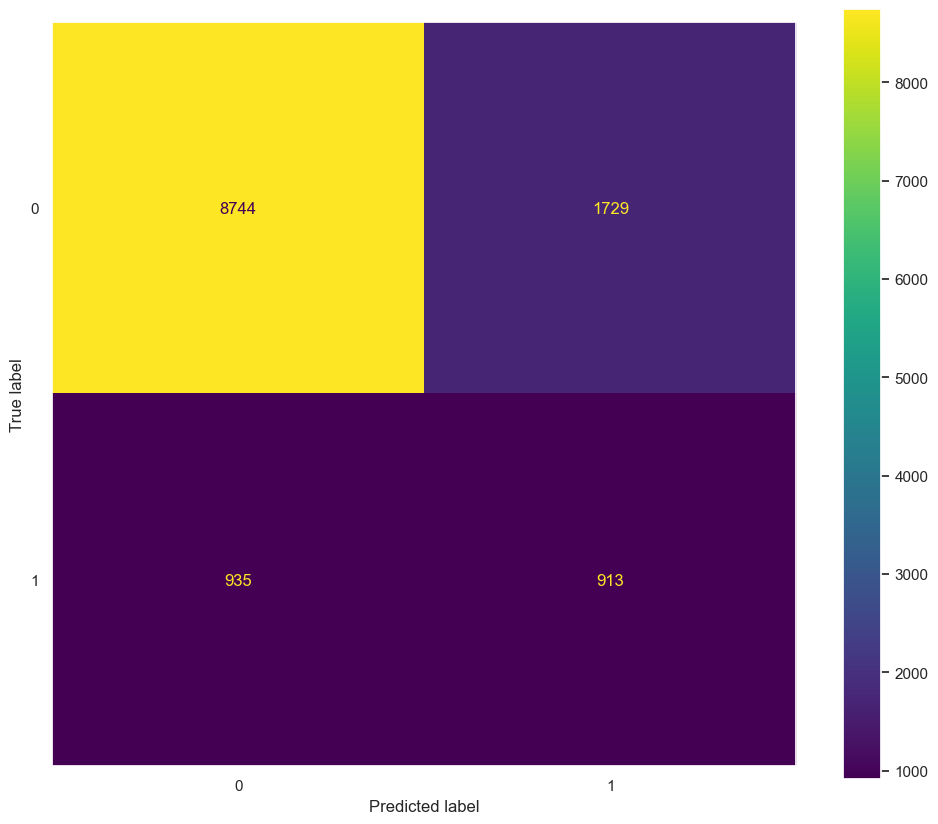

<Figure size 600x600 with 0 Axes>

In [29]:
cm = confusion_matrix(y_test, (prediction >= 0.5).astype(int))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])
cm_display.plot()
plt.grid(False)
plt.figure(figsize=(6,6))
plt.show()

From the matrix and the report, we can see that the model is quite good at identifying customers who will not make a purchase and will make a purchase. Let's see what parameters the model relied on and which of these parameters were important to it.

Feature Importance:
                  Feature  Importance
9     wants_extra_baggage    0.213051
11  wants_in_flight_meals    0.207383
10   wants_preferred_seat    0.166792
1           sales_channel    0.110280
2               trip_type    0.089522
4          length_of_stay    0.072602
5             flight_hour    0.072519
12        flight_duration    0.015692
0          num_passengers    0.015372
7                   route    0.014649
8          booking_origin    0.008878
6              flight_day    0.008204
3           purchase_lead    0.005056


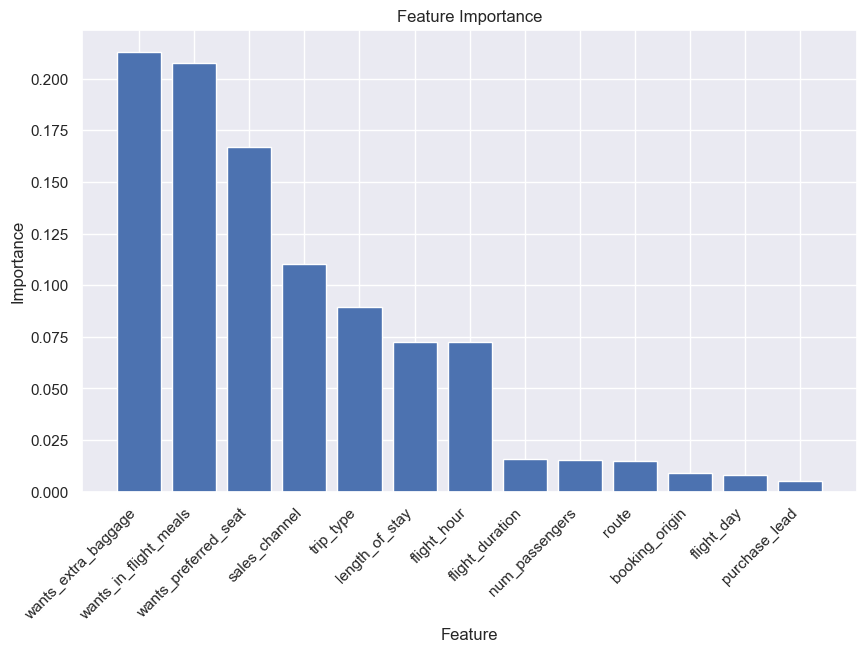

In [30]:
importance = grid_search_xgb.best_estimator_.named_steps['xgboost'].feature_importances_
 
feature_importance_df = pd.DataFrame({'Feature': X_test.columns, 'Importance': importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Output Feature Importance
print("Feature Importance:")
print(feature_importance_df)

# Visualizing the importance of features on a graph
plt.figure(figsize=(10, 6))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=45, ha='right')
plt.show()    

The important parameters on which the model was based were as follows: wants extra baggage, wants in flight meals, wants preferred seat.

## Conclusions

Created a model for predicting whether a customer will buy a ticket or not; the best model was XGBoost. Important criteria were wanting extra baggage, in-flight meals, and a preferred seat. These criteria played a role in the customer's decision to buy a ticket or not. We had unbalanced data, and even though we used the SMOTE+ENN method to balance the data and train the model on two classes, our model still better predicts the majority class, namely customers who will not make a purchase. Perhaps if more data is collected for the minority class, the model will predict that class better.

## List of sources

1.https://towardsdatascience.com/exploratory-data-analysis-8fc1cb20fd15

2.https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/

3.https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/

The dataset is from kaggle.com.